

---


## <center>TABLE OF CONTENTS</center>


---



1. [Load](#1.-Load)  

2. [Cleaning](#2.-Cleaning)  
    * 2.1) [Feature Selection](##2.1-Feature-Selection)  
    * 2.2) [Discard Null Values](##2.2-Discard-Null-Values)
    * 2.3) [Exclusion of Flights Exhibiting Irregular FOB Dynamics in Cruise Flight](##2.3-Exclusion-of-Flights-Exhibiting-Irregular-FOB-Dynamics-in-Cruise-Flight)
    * 2.4) [Noise Reduction](##2.4-Noise-Reduction)
      * 2.4.1) [Median Filter](##2.4.1-Median-Filter)
      * 2.4.2) [Gaussian Filter](###2.4.2-Gaussian-Filter)
      * 2.4.3) [Savgol Filter](###2.4.3-Savgol-Filter)
      * 2.4.4) [Choice of Filter](##2.4.4-Choice-of-Filte)
    * 2.5) [Noise Reduction for FUEL_USED_TOTAL](##2.5-Noise-Reduction-for-FUEL_USE_TOTAL)
    * 2.6) [Filter for Flight Phase 8](##2.6-Filter-for-Flight-Phase-8)
3. [Feature Engineering I](#3.-Feature-Engineering-I)
4. [Data Augmentation](#4.-Data-Augmentation)
    * 4.1) [Concat MSN02 and Artificial Flights](##4.1-Concat-MSN02-and-Artificial-Flights)
5. [Feature Engineering II](#5.-Feature-Engineering-II)
    * 5.1) [Inspect](##5.1-Inspect)
6. [Anomaly Detection](#6.-Anomaly-Detection)
    * 6.1) [Load prepocessed trainig data](##6.1-Load-preprrocessed-training-data)
    * 6.2) [Baseline Model](##6.2-Baseline-Model)
      * 6.2.1) [Train & Validation on MSN02](###6.2.1-Train-&-Validation)
      * 6.2.2) [Test Model on other MSN's](###6.2.2-Test-Model-on-other-MSN's)
      * 6.2.3) [Evaluation](###6.2.3-Evaluation)
    * 6.3) [Best Model](##6.3-1st-Improved-LSTM)
      * 6.3.1) [Test Model on other MSN's](###6.3.1-Test-Model-on-other-MSN's)
      * 6.3.2) [Adding Artificial Leakages to the Test data](###6.3.2-Adding-Artificial-Leakages-to-the-Test-data)
          * 6.3.2.1) [Ingesting 30 artificial leakages (1,0.8,0.5)](####6.3.2.1-Ingesting-30-artificial-leakages-(1,0.8,0.5))
          * 6.3.2.2) [Ingesting 20 artificial leakages (1,0.8)](####6.3.2.2-Ingesting-20-artificial-leakages-(1,0.8))
          * 6.3.2.3) [Ingesting 10 artificial leakages (20)](####6.3.2.1-Ingesting-10-artificial-leakages-(20))
      * 6.3.3) [Evaluation](###6.3.3-Evaluation)




---


# 1.Load


---



- **Code Explanation and Purpose:**
  - We've loaded the MSN02 dataset, which contains information about fuel consumption and flight details.
  
- **Why did we do it?**
  - To begin our analysis and modeling process, we need to load the dataset into memory.
  
- **What did we do next?**
  - We loaded the dataset from the provided file path into a Pandas DataFrame named `msn02`.
  - We set the Pandas display options to show all rows and columns for better visibility.
  - Mounted the Google Drive to access the dataset file.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
msn02= pd.read_csv("/content/drive/MyDrive/IE/CORPORATE_PROJECT_AIRBUS/01_DATA/msn_02_fuel_leak_signals_preprocessed.csv", delimiter=';')

In [ ]:
msn02.shape

(623580, 111)



---


# 2.Cleaning


---






---

## 2.1 Feature Selection


---





- **Code Explanation and Purpose:**
  - We're preparing the dataset for further analysis by selecting only the most important features, with which we are creating calculated rates and cumulative sums later on.
  
- **Why did we do it?**
  - By focusing on essential features related to fuel consumption and flight phases, we can streamline our analysis and modeling process.
  
- **What did we do next?**
  - We filtered the dataset to keep only the columns deemed important for our analysis.
  - We displayed information about the DataFrame to understand its structure and check for missing values.


In [ ]:
flight_phase_counts = msn02['FLIGHT_PHASE_COUNT'].value_counts()
pd.DataFrame(flight_phase_counts)

,FLIGHT_PHASE_COUNT
8.0,392705
1.0,59493
2.0,50511
11.0,33583
12.0,10026
9.0,5531
7.0,4448
6.0,1200
3.0,1075
10.0,1059


In [ ]:
columns_to_keep = ["UTC_TIME", "MSN", "Flight", "FLIGHT_PHASE_COUNT",
                   "FUEL_USED_1", "FUEL_USED_2", "FUEL_USED_3", "FUEL_USED_4", "VALUE_FOB"]

msn02 = msn02[columns_to_keep]

In [ ]:
msn02.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623580 entries, 0 to 623579
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   UTC_TIME            623580 non-null  object 
 1   MSN                 623580 non-null  object 
 2   Flight              623580 non-null  object 
 3   FLIGHT_PHASE_COUNT  560658 non-null  float64
 4   FUEL_USED_1         514944 non-null  float64
 5   FUEL_USED_2         516600 non-null  float64
 6   FUEL_USED_3         516601 non-null  float64
 7   FUEL_USED_4         514713 non-null  float64
 8   VALUE_FOB           560322 non-null  float64
dtypes: float64(6), object(3)
memory usage: 42.8+ MB


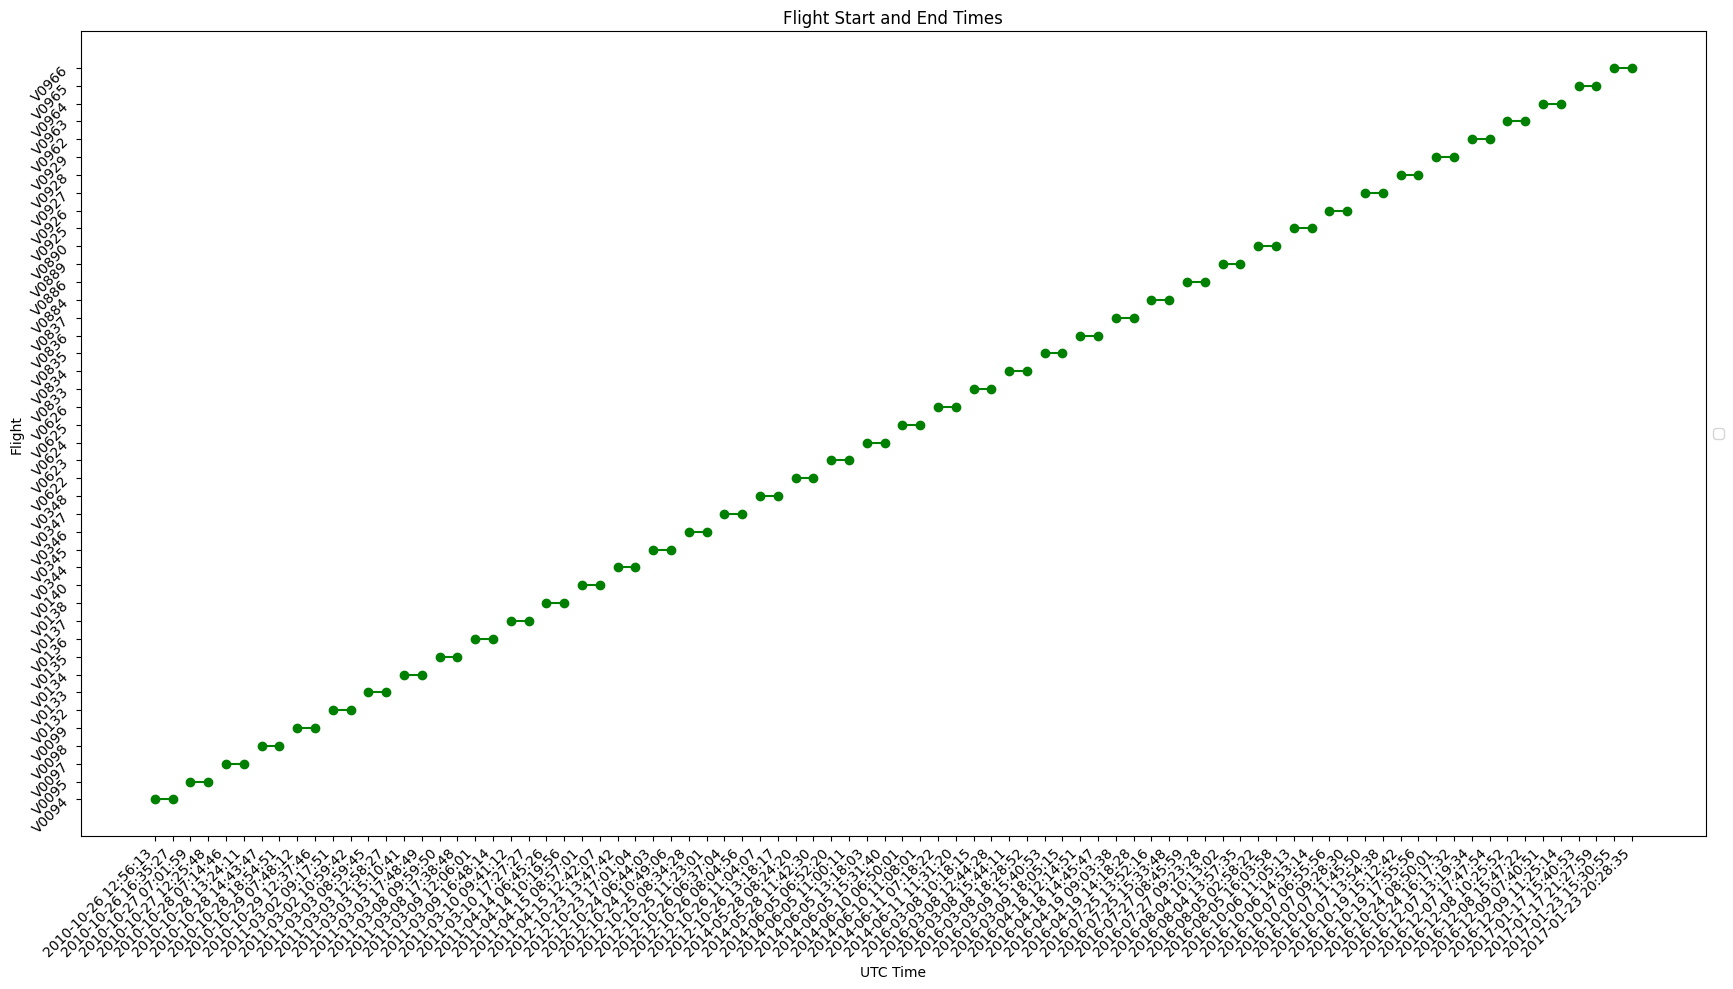

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


fig, ax = plt.subplots(figsize=(25, 10))

default_color = 'green'

flight_times = msn02.groupby('Flight')['UTC_TIME'].agg([min, max])

for flight, times in flight_times.iterrows():
    start, end = times['min'], times['max']

    ax.plot([start, end], [flight, flight], marker='o', linestyle='-', color=color)

ax.set_xlabel('UTC Time')
ax.set_ylabel('Flight')
ax.set_title('Flight Start and End Times')

# Improve the layout
plt.gcf().autofmt_xdate()
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')

plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.85)  # Adjust the right padding to make space for the legend

# Handling unique legend labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(dict.fromkeys(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


In [ ]:
len(msn02["Flight"].unique())

42



---


## 2.2 Discard Null Values

---


- **Code Explanation and Purpose:**
  - We're discarding rows with missing values in critical columns related to fuel consumption.
  
- **Why did we do it?**
  - To ensure data integrity and avoid potential issues during analysis and modeling, we remove rows with missing values in essential columns.
  
- **What did we do next?**
  - We removed rows with NaN values in columns `VALUE_FOB` and `FUEL_USED_1 - FUEL_USED_4` to clean the dataset.
  - We converted the 'UTC_TIME' column to datetime format for time-based analysis.
  - Created new columns for date and time to enhance dataset organization.


In [ ]:
msn02 = msn02.dropna(subset=['VALUE_FOB'])
msn02 = msn02.dropna(subset=['FUEL_USED_1'])
msn02 = msn02.dropna(subset=['FUEL_USED_2'])
msn02 = msn02.dropna(subset=['FUEL_USED_3'])
msn02 = msn02.dropna(subset=['FUEL_USED_4'])

In [ ]:
duplicate_count = msn02['UTC_TIME'].duplicated().sum()
print("Number of duplicate values in 'UTC_TIME':", duplicate_count)

Number of duplicate values in 'UTC_TIME': 11148


In [ ]:
# Dropping duplicate rows based on 'UTC_TIME'
msn02 = msn02.drop_duplicates(subset='UTC_TIME', keep='first')

In [ ]:
msn02.shape

(503515, 9)

In [ ]:
msn02["UTC_TIME_obj"] =msn02["UTC_TIME"].copy()
msn02['UTC_TIME'] = pd.to_datetime(msn02['UTC_TIME'])

# Create new columns for date and time
msn02['DATE'] = msn02['UTC_TIME'].dt.date
msn02['TIME'] = msn02['UTC_TIME'].dt.time

<ipython-input-223-a095f5149bc1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msn02["UTC_TIME_obj"] =msn02["UTC_TIME"].copy()


In [ ]:
msn02.shape

(503515, 12)

In [ ]:
msn02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503515 entries, 1 to 623579
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   UTC_TIME            503515 non-null  datetime64[ns]
 1   MSN                 503515 non-null  object        
 2   Flight              503515 non-null  object        
 3   FLIGHT_PHASE_COUNT  503478 non-null  float64       
 4   FUEL_USED_1         503515 non-null  float64       
 5   FUEL_USED_2         503515 non-null  float64       
 6   FUEL_USED_3         503515 non-null  float64       
 7   FUEL_USED_4         503515 non-null  float64       
 8   VALUE_FOB           503515 non-null  float64       
 9   UTC_TIME_obj        503515 non-null  object        
 10  DATE                503515 non-null  object        
 11  TIME                503515 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(5)
memory usage: 49.9+ MB


msn02 has now only 11 features and  almost 500.000 data points



---


## 2.3 Exclusion of Flights Exhibiting Irregular FOB Dynamics in Cruise Flight


---



To visually identifiying flights with abnormal behaviour we are ploting the Fuel on Board Behaviour and the change of it. We are discarding the visually strange looking flights totally, to reduce the noise in the training data.

- **Code Explanation and Purpose:**
  - We're identifying flights with abnormal fuel on board (FOB) behavior by visualizing FOB values and their changes.
  
- **Why did we do it?**
  - To identify and remove flights with anomalous FOB behavior, which could introduce noise and inaccuracies into our analysis and modeling.
  
- **What did we do next?**
  - We plotted FOB values and their changes over time for each flight to visually identify abnormal behavior.
  - Identified flights with abnormal FOB behavior based on visual inspection.
  - Removed the identified flights from the dataset to improve data quality.


In [ ]:
msn02["FOB_change"]=msn02["VALUE_FOB"].diff().fillna(0)

In [ ]:
import matplotlib.pyplot as plt

phase_8_flights=msn02[msn02["FLIGHT_PHASE_COUNT"]==8]
for element in list(phase_8_flights["Flight"].unique()):
    relation_FOB_FUSED = phase_8_flights[phase_8_flights["Flight"] == element]
    start_time = relation_FOB_FUSED['UTC_TIME'].min()
    end_time = relation_FOB_FUSED['UTC_TIME'].max()
    flight_duration = (end_time - start_time).total_seconds() / 60.0  # Convert to minutes


    fig, ax1 = plt.subplots(figsize=(14, 7))


    ax1.plot(relation_FOB_FUSED.index, relation_FOB_FUSED['VALUE_FOB'], label='VALUE_FOB', color='green')


    ax1.set_xlabel('Index')
    ax1.set_ylabel('FOB Value [kg]')
    ax1.set_title(f'FOB Value - Flight {element}\nFlight Duration: {flight_duration:.2f} mins', loc='center', pad=20)
    ax1.legend(loc='upper left')


    ax2 = ax1.twinx()
    # Skip the first value of FOB_change by starting from the second value (index 1)
    ax2.plot(relation_FOB_FUSED.index[1:], relation_FOB_FUSED['FOB_change'][1:], label='Difference', color='black', alpha=0.5)
    ax2.set_ylabel('Difference [kg/s]', color='grey')
    ax2.tick_params(axis='y', labelcolor='grey')
    ax2.legend(loc='upper right')

    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

We found those flights to have an **abnormal** Fuel on Board behaviour.
- V0095
- V0626
- V0346
- V0138

In [ ]:

flights_to_remove = ['V0095', 'V0626',"V0346","V0138"]
msn02= msn02[~msn02["Flight"].isin(flights_to_remove)]
msn02.shape


(449039, 13)

In [ ]:
msn02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 449039 entries, 1 to 623579
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   UTC_TIME            449039 non-null  datetime64[ns]
 1   MSN                 449039 non-null  object        
 2   Flight              449039 non-null  object        
 3   FLIGHT_PHASE_COUNT  449002 non-null  float64       
 4   FUEL_USED_1         449039 non-null  float64       
 5   FUEL_USED_2         449039 non-null  float64       
 6   FUEL_USED_3         449039 non-null  float64       
 7   FUEL_USED_4         449039 non-null  float64       
 8   VALUE_FOB           449039 non-null  float64       
 9   UTC_TIME_obj        449039 non-null  object        
 10  DATE                449039 non-null  object        
 11  TIME                449039 non-null  object        
 12  FOB_change          449039 non-null  float64       
dtypes: datetime64[ns](1), float64

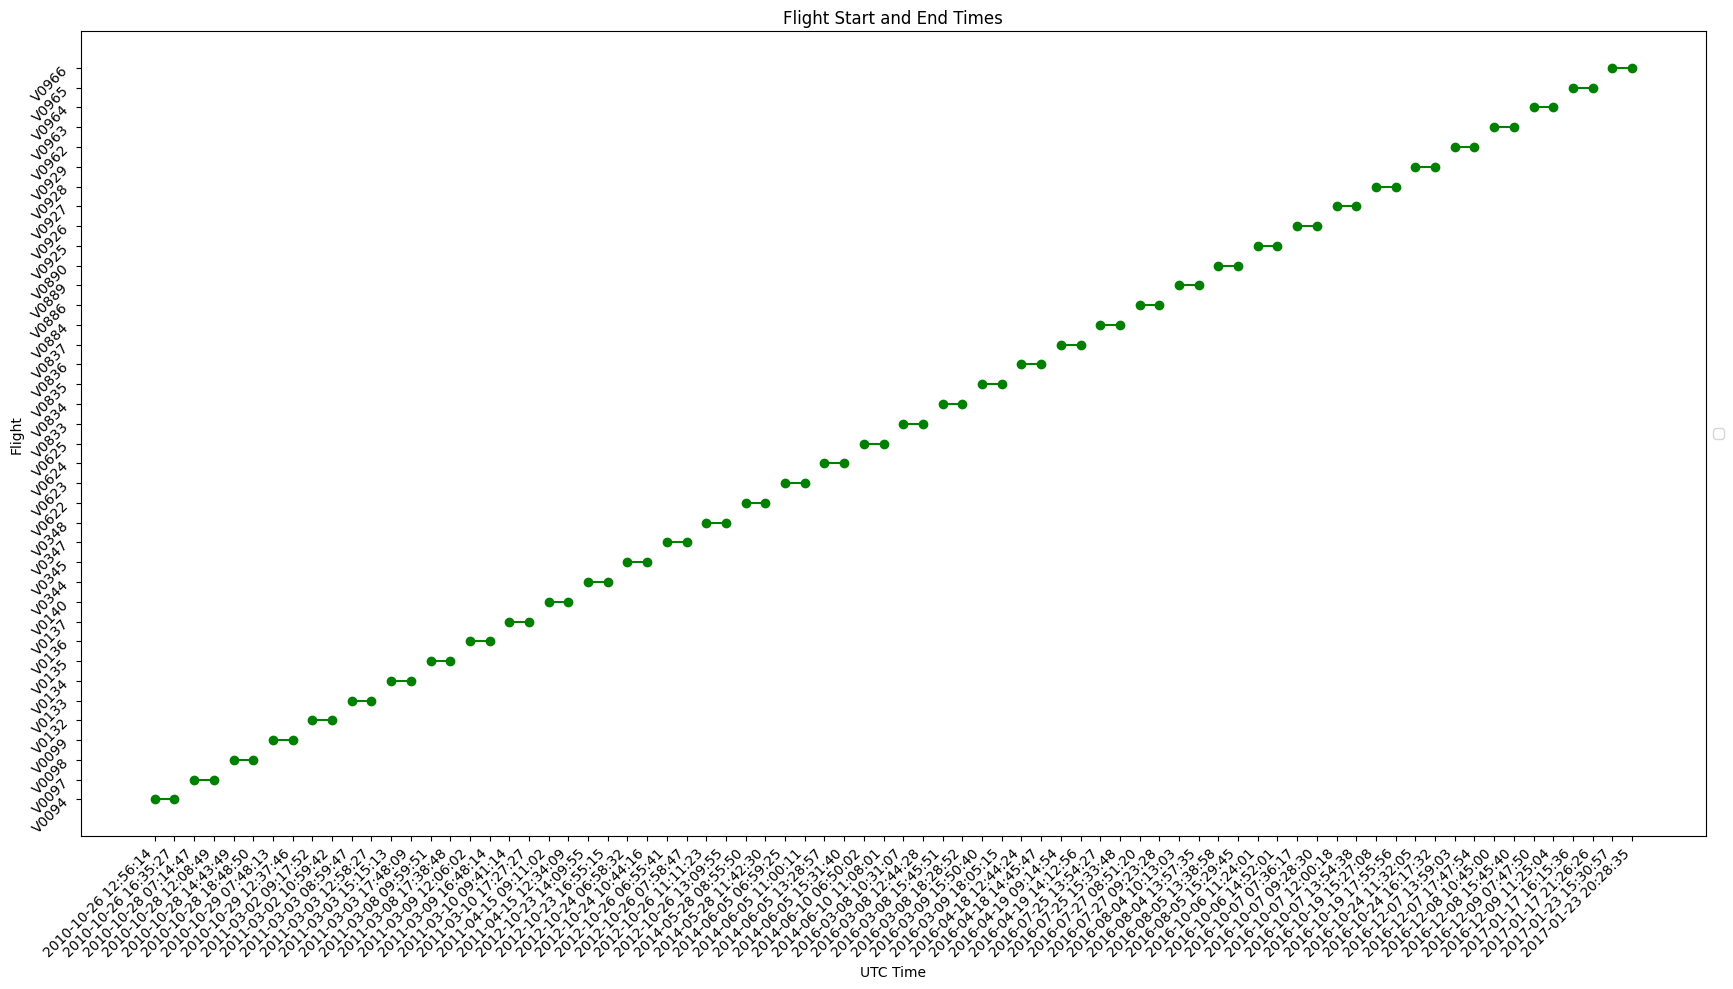

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


fig, ax = plt.subplots(figsize=(25, 10))

default_color = 'green'

flight_times = msn02.groupby('Flight')['UTC_TIME_obj'].agg([min, max])

for flight, times in flight_times.iterrows():
    start, end = times['min'], times['max']

    ax.plot([start, end], [flight, flight], marker='o', linestyle='-', color=color)

ax.set_xlabel('UTC Time')
ax.set_ylabel('Flight')
ax.set_title('Flight Start and End Times')

# Improve the layout
plt.gcf().autofmt_xdate()
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')

plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.85)  # Adjust the right padding to make space for the legend

# Handling unique legend labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(dict.fromkeys(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()




---


## 2.4 Noise Reduction

---



First FOB and then FUEL_USED_i



---


### 2.4.1 Median Filter


---


- **Code Explanation and Purpose:**
  - We're applying median filtering to smooth out the FOB values.
  
- **Why did we do it?**
  - Median filtering helps reduce noise and outliers in the FOB data, making it more suitable for analysis and modeling.
  
- **What did we do next?**
  - We applied median filtering with kernel sizes of 5 and 9 to the 'VALUE_FOB' column.
  - Visualized the effect of median filtering on FOB values to assess its impact.


In [ ]:
from scipy.signal import medfilt

msn02['VALUE_FOB_median_filtered_5'] = medfilt(msn02['VALUE_FOB'], kernel_size=5)
msn02['VALUE_FOB_median_filtered_9'] = medfilt(msn02['VALUE_FOB'], kernel_size=9)

In [ ]:
msn02['VALUE_FOB_median_filtered_5_change'] = msn02['VALUE_FOB_median_filtered_5'].diff().fillna(0)
msn02['VALUE_FOB_median_filtered_9_change']=msn02['VALUE_FOB_median_filtered_9'].diff().fillna(0)

In [ ]:
msn02["Difference_VALUE_FOB_vs_FOB_medianfiltered_5"]= msn02['VALUE_FOB_median_filtered_5']- msn02["VALUE_FOB"]
msn02["Difference_VALUE_FOB_vs_FOB_medianfiltered_9"]= msn02['VALUE_FOB_median_filtered_9']- msn02["VALUE_FOB"]

In [ ]:
msn02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 449039 entries, 1 to 623579
Data columns (total 19 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   UTC_TIME                                      449039 non-null  datetime64[ns]
 1   MSN                                           449039 non-null  object        
 2   Flight                                        449039 non-null  object        
 3   FLIGHT_PHASE_COUNT                            449002 non-null  float64       
 4   FUEL_USED_1                                   449039 non-null  float64       
 5   FUEL_USED_2                                   449039 non-null  float64       
 6   FUEL_USED_3                                   449039 non-null  float64       
 7   FUEL_USED_4                                   449039 non-null  float64       
 8   VALUE_FOB                                     449039 n

#### Comparing median filter kernel_size= 5 and 9

Now we compare those to by plotting them for each flight.

In [ ]:
import matplotlib.pyplot as plt

phase_8_flights = msn02[msn02["FLIGHT_PHASE_COUNT"] == 8]

for element in list(phase_8_flights["Flight"].unique()):

    relation_FOB_FUSED = phase_8_flights[phase_8_flights["Flight"] == element]


    fig, ax1 = plt.subplots(figsize=(14, 7))


    ax1.plot(relation_FOB_FUSED.index, relation_FOB_FUSED['FOB_change'], label='Original FOB Change', color='green', alpha=0.75)


    ax1.plot(relation_FOB_FUSED.index[1:], relation_FOB_FUSED['VALUE_FOB_median_filtered_5_change'][1:], label='Median Filtered 5 Change', color='blue', alpha=0.75)
    ax1.plot(relation_FOB_FUSED.index[1:], relation_FOB_FUSED['VALUE_FOB_median_filtered_9_change'][1:], label='Median Filtered 9 Change', color='red', alpha=0.75)

    ax1.set_xlabel('Index')
    ax1.set_ylabel('FOB Change [kg/s]')
    ax1.set_title(f'FOB Change - Flight {element}\nFlight Duration: {flight_duration:.2f} mins', loc='center', pad=20)
    ax1.legend(loc='upper left')


    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import pandas as pd
import numpy as np


phase_8_flights = msn02[msn02["FLIGHT_PHASE_COUNT"] == 8]

comparison_df = pd.DataFrame(columns=['Flight', 'FOB_Change_Range', 'Median_5_Change_Range', 'Median_9_Change_Range'])

for element in phase_8_flights["Flight"].unique():
    flight_data = phase_8_flights[phase_8_flights["Flight"] == element]


    fob_change_range = flight_data['FOB_change'].abs().max() - flight_data['FOB_change'].abs().min()
    median_5_change_range = flight_data['VALUE_FOB_median_filtered_5_change'].abs().max() - flight_data['VALUE_FOB_median_filtered_5_change'].abs().min()
    median_9_change_range = flight_data['VALUE_FOB_median_filtered_9_change'].abs().max() - flight_data['VALUE_FOB_median_filtered_9_change'].abs().min()


    comparison_df = comparison_df.append({'Flight': element,
                                          'FOB_Change_Range': fob_change_range,
                                          'Median_5_Change_Range': median_5_change_range,
                                          'Median_9_Change_Range': median_9_change_range}, ignore_index=True)

comparison_df


<ipython-input-236-71b216181a1f>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({'Flight': element,
<ipython-input-236-71b216181a1f>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({'Flight': element,
<ipython-input-236-71b216181a1f>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({'Flight': element,
<ipython-input-236-71b216181a1f>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({'Flight': element,
<ipython-input-236-71b216181a1f>:18: FutureWarning: The frame.append method is depre

,Flight,FOB_Change_Range,Median_5_Change_Range,Median_9_Change_Range
0,V0136,133.0,133.0,133.0
1,V0133,44.0,44.0,44.0
2,V0926,28.0,28.0,28.0
3,V0837,31.0,31.0,31.0
4,V0929,60.0,60.0,60.0
5,V0623,40.0,40.0,40.0
6,V0965,50.0,43.0,35.0
7,V0344,20.0,20.0,20.0
8,V0835,33.0,33.0,33.0
9,V0624,38.0,38.0,38.0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

phase_8_flights = msn02[msn02["FLIGHT_PHASE_COUNT"] == 8]

for element in list(phase_8_flights["Flight"].unique()):

    relation_FOB_FUSED = phase_8_flights[phase_8_flights["Flight"] == element].reset_index()


    start_time = relation_FOB_FUSED['UTC_TIME'].min()
    end_time = relation_FOB_FUSED['UTC_TIME'].max()
    flight_duration = (end_time - start_time).total_seconds() / 3600.0  # Convert to hours


    max_change_index = relation_FOB_FUSED['FOB_change'].idxmax()
    min_change_index = relation_FOB_FUSED['FOB_change'].idxmin()


    center_index = int(np.mean([max_change_index, min_change_index]))

    half_window_size = min(200, len(relation_FOB_FUSED) // 2)
    start_index = max(0, center_index - half_window_size)
    end_index = min(len(relation_FOB_FUSED), center_index + half_window_size)


    windowed_data = relation_FOB_FUSED.iloc[start_index:end_index]


    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.plot(windowed_data['index'], windowed_data['FOB_change'], label='Original FOB Change', color='green', alpha=0.75)
    ax1.plot(windowed_data['index'], windowed_data['VALUE_FOB_median_filtered_5_change'], label='Median Filtered 5 Change', color='blue', alpha=0.75)
    ax1.plot(windowed_data['index'], windowed_data['VALUE_FOB_median_filtered_9_change'], label='Median Filtered 9 Change', color='red', alpha=0.75)


    ax1.set_xlabel('Index')
    ax1.set_ylabel('Change in FOB [kg/s]')
    ax1.set_title(f'FOB Change - Flight {element}\nFlight Duration: {flight_duration:.2f} hours', loc='center', pad=20)
    ax1.legend(loc='upper left')


    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
msn02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 449039 entries, 1 to 623579
Data columns (total 19 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   UTC_TIME                                      449039 non-null  datetime64[ns]
 1   MSN                                           449039 non-null  object        
 2   Flight                                        449039 non-null  object        
 3   FLIGHT_PHASE_COUNT                            449002 non-null  float64       
 4   FUEL_USED_1                                   449039 non-null  float64       
 5   FUEL_USED_2                                   449039 non-null  float64       
 6   FUEL_USED_3                                   449039 non-null  float64       
 7   FUEL_USED_4                                   449039 non-null  float64       
 8   VALUE_FOB                                     449039 n



---


### 2.4.2 Gaussian Filter



---


 FOB and FUEL_USED (sigma = 6 & 10)





- **Code Explanation and Purpose:**
  - We're applying Gaussian filtering to further smooth the FOB values.
  
- **Why did we do it?**
  - Gaussian filtering provides additional smoothing to FOB values, complementing the median filtering process.
  
- **What did we do next?**
  - We applied Gaussian filtering with sigma values of 6 and 10 to the `VALUE_FOB` column and to all `FUEL_USED_i` columns
  - Visualized the effect of Gaussian filtering on FOB values to evaluate its impact.

- **Things to considr moving forward?**

  - Edge Effects:  Gaussian filter can produce artifacts at the start and end of the data. This is because the filter weights are not balanced by data on one side at the boundaries.

  - Outliers: If there are outliers near the edge, a Gaussian filter with a large sigma may excessively spread their influence, causing the smoothed line to overshoot the actual data.

  - Parameter Selection: The sigma value for the Gaussian filter determines the extent of smoothing. A larger sigma value means more smoothing, which can sometimes lead to overestimating the smoothed values if not balanced by appropriate weighting at the data boundaries.




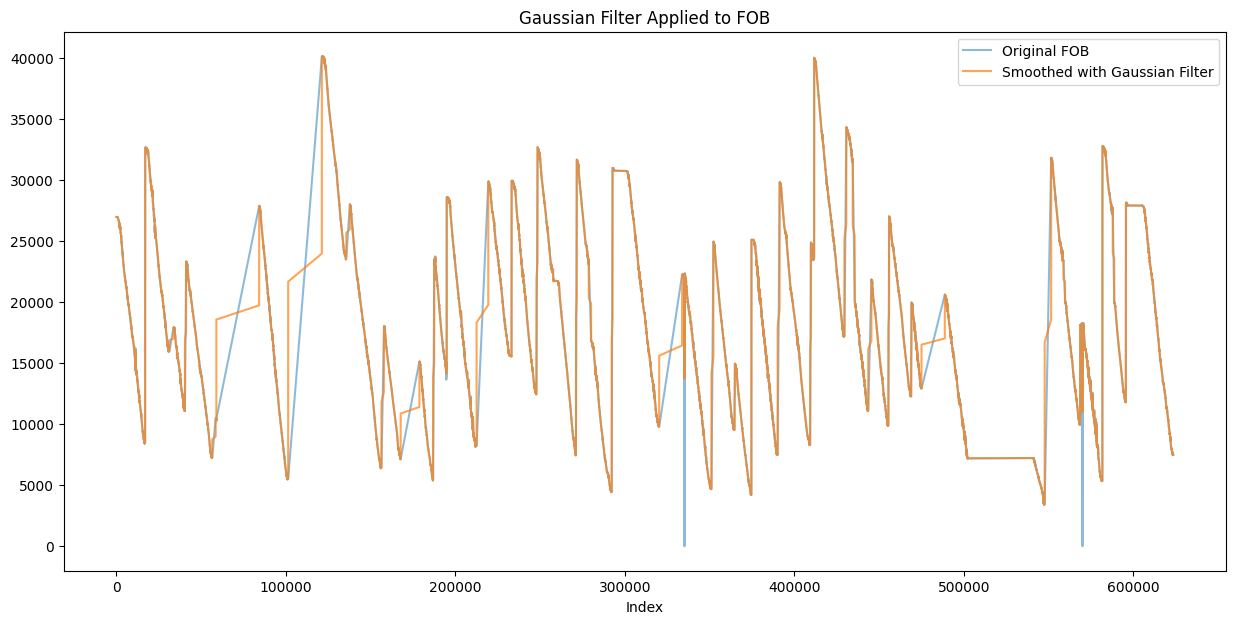

In [ ]:
from scipy.ndimage import gaussian_filter1d


sigma = 6

msn02[f'VALUE_FOB_gaussian_{sigma}'] = gaussian_filter1d(msn02['VALUE_FOB'], sigma)

# Visualize the smoothed versus original data for one of the columns, e.g., 'VALUE_FOB'
plt.figure(figsize=(15, 7))
plt.plot(msn02.index, msn02["VALUE_FOB"], label='Original FOB', alpha=0.5)
plt.plot(msn02.index, msn02[f'VALUE_FOB_gaussian_{sigma}'], label='Smoothed with Gaussian Filter', alpha=0.7)
plt.legend()
plt.title(f'Gaussian Filter Applied to FOB')
plt.xlabel('Index')

plt.show()

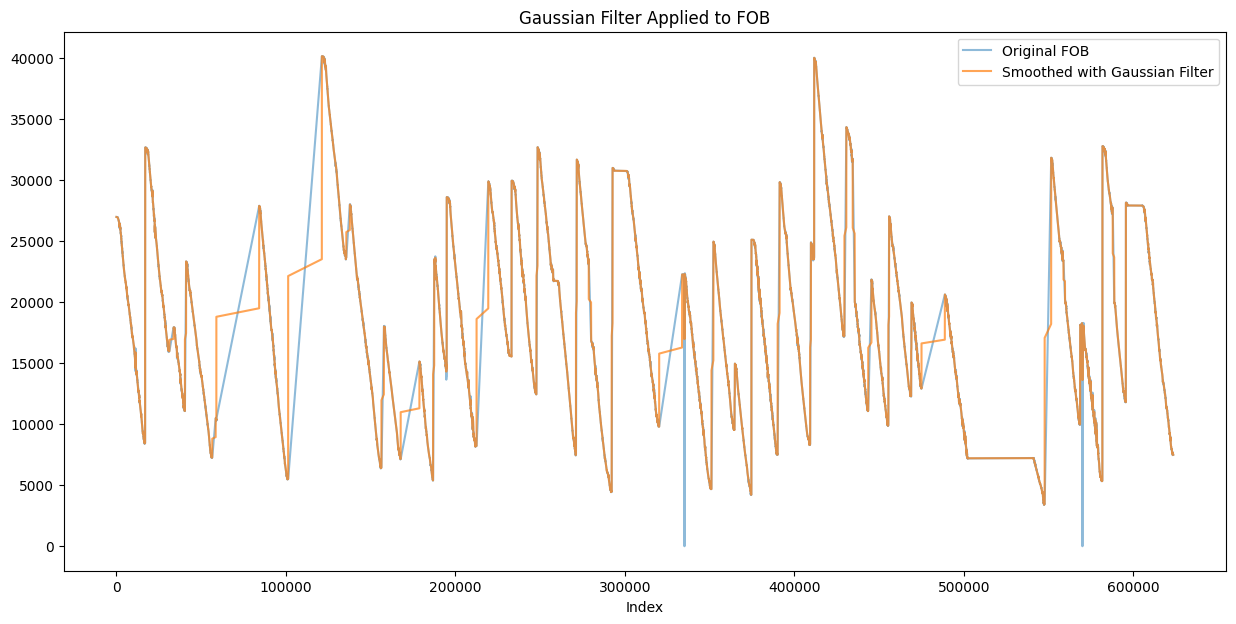

In [ ]:
from scipy.ndimage import gaussian_filter1d


sigma = 10

msn02[f'VALUE_FOB_gaussian_{sigma}'] = gaussian_filter1d(msn02['VALUE_FOB'], sigma)

# Visualize the smoothed versus original data for one of the columns, e.g., 'VALUE_FOB'
plt.figure(figsize=(15, 7))
plt.plot(msn02.index, msn02["VALUE_FOB"], label='Original FOB', alpha=0.5)
plt.plot(msn02.index, msn02[f'VALUE_FOB_gaussian_{sigma}'], label='Smoothed with Gaussian Filter', alpha=0.7)
plt.legend()
plt.title(f'Gaussian Filter Applied to FOB')
plt.xlabel('Index')

plt.show()

In [ ]:
msn02["Difference_VALUE_FOB_vs_FOB_gaussianfiltered_6"]= msn02['VALUE_FOB_gaussian_6']- msn02["VALUE_FOB"]
msn02["Difference_VALUE_FOB_vs_FOB_gaussianfiltered_10"]= msn02['VALUE_FOB_gaussian_10']- msn02["VALUE_FOB"]

In [ ]:
msn02['VALUE_FOB_gaussian_6_change'] =msn02['VALUE_FOB_gaussian_6'].diff().fillna(0)
msn02['VALUE_FOB_gaussian_10_change'] =msn02['VALUE_FOB_gaussian_10'].diff().fillna(0)

In [ ]:
msn02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 449039 entries, 1 to 623579
Data columns (total 25 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   UTC_TIME                                         449039 non-null  datetime64[ns]
 1   MSN                                              449039 non-null  object        
 2   Flight                                           449039 non-null  object        
 3   FLIGHT_PHASE_COUNT                               449002 non-null  float64       
 4   FUEL_USED_1                                      449039 non-null  float64       
 5   FUEL_USED_2                                      449039 non-null  float64       
 6   FUEL_USED_3                                      449039 non-null  float64       
 7   FUEL_USED_4                                      449039 non-null  float64       
 8   VALUE_FOB               

#### Comparing Gaussian Filter sigma=6 and sigma=10

In [ ]:
import pandas as pd
import numpy as np


comparison_df = pd.DataFrame(columns=['Flight', 'FOB_Change_Range',
                                      'Median_5_Change_Range', 'Median_9_Change_Range',
                                      'Gaussian_6_Change_Range', 'Gaussian_10_Change_Range'])
phase_8_flights=msn02[msn02["FLIGHT_PHASE_COUNT"]==8]
for element in phase_8_flights["Flight"].unique():
    flight_data = phase_8_flights[phase_8_flights["Flight"] == element]


    fob_change_range = flight_data['FOB_change'].abs().max() - flight_data['FOB_change'].abs().min()
    median_5_change_range = flight_data['VALUE_FOB_median_filtered_5_change'].abs().max() - flight_data['VALUE_FOB_median_filtered_5_change'].abs().min()
    median_9_change_range = flight_data['VALUE_FOB_median_filtered_9_change'].abs().max() - flight_data['VALUE_FOB_median_filtered_9_change'].abs().min()


    gaussian_6_change_range = flight_data['VALUE_FOB_gaussian_6_change'].abs().max() - flight_data['VALUE_FOB_gaussian_6_change'].abs().min()
    gaussian_10_change_range = flight_data['VALUE_FOB_gaussian_10_change'].abs().max() - flight_data['VALUE_FOB_gaussian_10_change'].abs().min()


    comparison_df = comparison_df.append({'Flight': element,
                                          'FOB_Change_Range': fob_change_range,
                                          'Median_5_Change_Range': median_5_change_range,
                                          'Median_9_Change_Range': median_9_change_range,
                                          'Gaussian_6_Change_Range': gaussian_6_change_range,
                                          'Gaussian_10_Change_Range': gaussian_10_change_range}, ignore_index=True)

comparison_df


<ipython-input-244-a01b4a3bb4ba>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({'Flight': element,
<ipython-input-244-a01b4a3bb4ba>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({'Flight': element,
<ipython-input-244-a01b4a3bb4ba>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({'Flight': element,
<ipython-input-244-a01b4a3bb4ba>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({'Flight': element,
<ipython-input-244-a01b4a3bb4ba>:22: FutureWarning: The frame.append method is depre

,Flight,FOB_Change_Range,Median_5_Change_Range,Median_9_Change_Range,Gaussian_6_Change_Range,Gaussian_10_Change_Range
0,V0136,133.0,133.0,133.0,85.631181,59.672275
1,V0133,44.0,44.0,44.0,27.538374,23.972984
2,V0926,28.0,28.0,28.0,13.989003,12.495785
3,V0837,31.0,31.0,31.0,13.080270,7.939012
4,V0929,60.0,60.0,60.0,14.536689,8.090056
5,V0623,40.0,40.0,40.0,17.753018,11.629218
6,V0965,50.0,43.0,35.0,11.410750,8.265546
7,V0344,20.0,20.0,20.0,10.244855,6.378812
8,V0835,33.0,33.0,33.0,16.600294,11.124290
9,V0624,38.0,38.0,38.0,14.313714,8.761590


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
phase_8_flights = msn02[msn02["FLIGHT_PHASE_COUNT"] == 8]

for element in list(phase_8_flights["Flight"].unique()):

    relation_FOB_FUSED = phase_8_flights[phase_8_flights["Flight"] == element].reset_index()


    start_time = relation_FOB_FUSED['UTC_TIME'].min()
    end_time = relation_FOB_FUSED['UTC_TIME'].max()
    flight_duration = (end_time - start_time).total_seconds() / 3600.0  # Convert to hours


    max_change_index = relation_FOB_FUSED['FOB_change'].idxmax()
    min_change_index = relation_FOB_FUSED['FOB_change'].idxmin()
    center_index = int(np.mean([max_change_index, min_change_index]))


    half_window_size = min(200, len(relation_FOB_FUSED) // 2)
    start_index = max(0, center_index - half_window_size)
    end_index = min(len(relation_FOB_FUSED), center_index + half_window_size)

    windowed_data = relation_FOB_FUSED.iloc[start_index:end_index]


    fig, ax1 = plt.subplots(figsize=(14, 7))


    ax1.plot(windowed_data['index'], windowed_data['FOB_change'], label='Original FOB Change', color='green', alpha=0.75)
    ax1.plot(windowed_data['index'], windowed_data['VALUE_FOB_gaussian_6_change'], label='Gaussian Filtered 6 Change', color='purple', alpha=0.75)
    ax1.plot(windowed_data['index'], windowed_data['VALUE_FOB_gaussian_10_change'], label='Gaussian Filtered 10 Change', color='orange', alpha=0.75)


    ax1.set_xlabel('Index')
    ax1.set_ylabel('Change in FOB [kg/s]')
    ax1.set_title(f'FOB Change - Flight {element}\nFlight Duration: {flight_duration:.2f} hours', loc='center', pad=20)
    ax1.legend(loc='upper left')


    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.show()



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
msn02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 449039 entries, 1 to 623579
Data columns (total 25 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   UTC_TIME                                         449039 non-null  datetime64[ns]
 1   MSN                                              449039 non-null  object        
 2   Flight                                           449039 non-null  object        
 3   FLIGHT_PHASE_COUNT                               449002 non-null  float64       
 4   FUEL_USED_1                                      449039 non-null  float64       
 5   FUEL_USED_2                                      449039 non-null  float64       
 6   FUEL_USED_3                                      449039 non-null  float64       
 7   FUEL_USED_4                                      449039 non-null  float64       
 8   VALUE_FOB               



---


### 2.4.3 Savgol Filter


---



FOB (polynomial order =3)

- **Code Explanation and Purpose:**
  - We're applying the Savitzky-Golay filter to smooth the `VALUE_FOB`.
  
- **Why did we do it?**
  - The Savitzky-Golay filter is another method for smoothing noisy data, which can help in improving the quality of the FOB data for analysis.
  
- **What did we do next?**
  - Applied the Savitzky-Golay filter to the 'VALUE_FOB' column with a specified window size and polynomial order.
  - Visualized the effect of the Savitzky-Golay filter on FOB values to assess its impact.


In [ ]:
import numpy as np
from scipy.signal import savgol_filter


window_size = 51  # Choose an odd number, the window size
poly_order = 3  # Polynomial order

msn02['VALUE_FOB_SG'] = savgol_filter(msn02['VALUE_FOB'], window_size, poly_order)

msn02["Difference_VALUE_FOB_vs_FOB_SG"]=msn02['VALUE_FOB_SG'] - msn02['VALUE_FOB']

msn02["VALUE_FOB_SG_change"]=msn02['VALUE_FOB_SG'].diff().fillna(0)

In [ ]:
# Alternative configuration
alt_window_size = 31  # A smaller window size for potentially less aggressive smoothing
alt_poly_order = 2  # A lower polynomial order to see the effect of a simpler curve fit


msn02['VALUE_FOB_SG_alt'] = savgol_filter(msn02['VALUE_FOB'], alt_window_size, alt_poly_order)


msn02["Difference_VALUE_FOB_vs_FOB_SG_alt"] = msn02['VALUE_FOB_SG_alt'] - msn02['VALUE_FOB']


msn02["VALUE_FOB_SG_alt_change"] = msn02['VALUE_FOB_SG_alt'].diff().fillna(0)


In [ ]:
msn02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 449039 entries, 1 to 623579
Data columns (total 31 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   UTC_TIME                                         449039 non-null  datetime64[ns]
 1   MSN                                              449039 non-null  object        
 2   Flight                                           449039 non-null  object        
 3   FLIGHT_PHASE_COUNT                               449002 non-null  float64       
 4   FUEL_USED_1                                      449039 non-null  float64       
 5   FUEL_USED_2                                      449039 non-null  float64       
 6   FUEL_USED_3                                      449039 non-null  float64       
 7   FUEL_USED_4                                      449039 non-null  float64       
 8   VALUE_FOB               

#### Comparing Savgol filter  (51,3) and (31,2)

In [ ]:
import pandas as pd
import numpy as np


comparison_df = pd.DataFrame(columns=['Flight', 'FOB_Change_Range',
                                      'Median_5_Change_Range', 'Median_9_Change_Range',
                                      'Gaussian_6_Change_Range', 'Gaussian_10_Change_Range',
                                      'Savgol_51_3_Change_Range', 'Savgol_Alt_Change_Range'])

phase_8_flights = msn02[msn02["FLIGHT_PHASE_COUNT"] == 8]
for element in phase_8_flights["Flight"].unique():
    flight_data = phase_8_flights[phase_8_flights["Flight"] == element]


    fob_change_range = flight_data['FOB_change'].abs().max() - flight_data['FOB_change'].abs().min()
    median_5_change_range = flight_data['VALUE_FOB_median_filtered_5_change'].abs().max() - flight_data['VALUE_FOB_median_filtered_5_change'].abs().min()
    median_9_change_range = flight_data['VALUE_FOB_median_filtered_9_change'].abs().max() - flight_data['VALUE_FOB_median_filtered_9_change'].abs().min()
    gaussian_6_change_range = flight_data['VALUE_FOB_gaussian_6_change'].abs().max() - flight_data['VALUE_FOB_gaussian_6_change'].abs().min()
    gaussian_10_change_range = flight_data['VALUE_FOB_gaussian_10_change'].abs().max() - flight_data['VALUE_FOB_gaussian_10_change'].abs().min()


    savgol_51_3_change_range = flight_data['VALUE_FOB_SG_change'].abs().max() - flight_data['VALUE_FOB_SG_change'].abs().min()
    savgol_alt_change_range = flight_data['VALUE_FOB_SG_alt_change'].abs().max() - flight_data['VALUE_FOB_SG_alt_change'].abs().min()


    comparison_df = comparison_df.append({'Flight': element,
                                          'FOB_Change_Range': fob_change_range,
                                          'Median_5_Change_Range': median_5_change_range,
                                          'Median_9_Change_Range': median_9_change_range,
                                          'Gaussian_6_Change_Range': gaussian_6_change_range,
                                          'Gaussian_10_Change_Range': gaussian_10_change_range,
                                          'Savgol_51_3_Change_Range': savgol_51_3_change_range,
                                          'Savgol_Alt_Change_Range': savgol_alt_change_range}, ignore_index=True)

comparison_df


<ipython-input-250-8d11f869a3ef>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({'Flight': element,
<ipython-input-250-8d11f869a3ef>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({'Flight': element,
<ipython-input-250-8d11f869a3ef>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({'Flight': element,
<ipython-input-250-8d11f869a3ef>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({'Flight': element,
<ipython-input-250-8d11f869a3ef>:26: FutureWarning: The frame.append method is depre

,Flight,FOB_Change_Range,Median_5_Change_Range,Median_9_Change_Range,Gaussian_6_Change_Range,Gaussian_10_Change_Range,Savgol_51_3_Change_Range,Savgol_Alt_Change_Range
0,V0136,133.0,133.0,133.0,85.631181,59.672275,78.836463,105.369299
1,V0133,44.0,44.0,44.0,27.538374,23.972984,28.094566,30.509455
2,V0926,28.0,28.0,28.0,13.989003,12.495785,14.970532,14.613914
3,V0837,31.0,31.0,31.0,13.080270,7.939012,9.726630,16.109516
4,V0929,60.0,60.0,60.0,14.536689,8.090056,11.965979,21.178683
5,V0623,40.0,40.0,40.0,17.753018,11.629218,13.964280,21.507938
6,V0965,50.0,43.0,35.0,11.410750,8.265546,10.243403,14.170796
7,V0344,20.0,20.0,20.0,10.244855,6.378812,7.917597,12.588330
8,V0835,33.0,33.0,33.0,16.600294,11.124290,13.248522,19.779755
9,V0624,38.0,38.0,38.0,14.313714,8.761590,10.402886,17.863282


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


for element in list(phase_8_flights["Flight"].unique()):

    relation_FOB_FUSED = phase_8_flights[phase_8_flights["Flight"] == element].reset_index()


    start_time = relation_FOB_FUSED['UTC_TIME'].min()
    end_time = relation_FOB_FUSED['UTC_TIME'].max()
    flight_duration = (end_time - start_time).total_seconds() / 3600.0  # Convert to hours


    max_change_index = relation_FOB_FUSED['FOB_change'].idxmax()
    min_change_index = relation_FOB_FUSED['FOB_change'].idxmin()
    center_index = int(np.mean([max_change_index, min_change_index]))


    half_window_size = min(200, len(relation_FOB_FUSED) // 2)
    start_index = max(0, center_index - half_window_size)
    end_index = min(len(relation_FOB_FUSED), center_index + half_window_size)

    windowed_data = relation_FOB_FUSED.iloc[start_index:end_index]


    fig, ax1 = plt.subplots(figsize=(14, 7))


    ax1.plot(windowed_data['index'], windowed_data['FOB_change'], label='Original FOB Change', color='green', alpha=0.75)
    ax1.plot(windowed_data['index'], windowed_data['VALUE_FOB_SG_alt_change'], label='Softer Savgol Filtered Change', color='pink', alpha=0.75)
    ax1.plot(windowed_data['index'], windowed_data['VALUE_FOB_SG_change'], label='Stronger Savgol Filtered Change', color='black', alpha=0.75)


    ax1.set_xlabel('Index')
    ax1.set_ylabel('Change in FOB [kg/s]')
    ax1.set_title(f'FOB Change - Flight {element}\nFlight Duration: {flight_duration:.2f} hours', loc='center', pad=20)
    ax1.legend(loc='upper left')


    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.



---


### 2.4.4 Choice of Filter

---



In [ ]:
filter_comparison=comparison_df
filter_comparison

,Flight,FOB_Change_Range,Median_5_Change_Range,Median_9_Change_Range,Gaussian_6_Change_Range,Gaussian_10_Change_Range,Savgol_51_3_Change_Range,Savgol_Alt_Change_Range
0,V0136,133.0,133.0,133.0,85.631181,59.672275,78.836463,105.369299
1,V0133,44.0,44.0,44.0,27.538374,23.972984,28.094566,30.509455
2,V0926,28.0,28.0,28.0,13.989003,12.495785,14.970532,14.613914
3,V0837,31.0,31.0,31.0,13.080270,7.939012,9.726630,16.109516
4,V0929,60.0,60.0,60.0,14.536689,8.090056,11.965979,21.178683
5,V0623,40.0,40.0,40.0,17.753018,11.629218,13.964280,21.507938
6,V0965,50.0,43.0,35.0,11.410750,8.265546,10.243403,14.170796
7,V0344,20.0,20.0,20.0,10.244855,6.378812,7.917597,12.588330
8,V0835,33.0,33.0,33.0,16.600294,11.124290,13.248522,19.779755
9,V0624,38.0,38.0,38.0,14.313714,8.761590,10.402886,17.863282


In [ ]:

for col in ['Median_5_Change_Range', 'Median_9_Change_Range', 'Gaussian_6_Change_Range', 'Gaussian_10_Change_Range', 'Savgol_51_3_Change_Range', 'Savgol_Alt_Change_Range']:
    comparison_df[f'{col}_Noise_Reduction'] = 100 * (1 - (comparison_df[col] / comparison_df['FOB_Change_Range']))


comparison_df


,Flight,FOB_Change_Range,Median_5_Change_Range,Median_9_Change_Range,Gaussian_6_Change_Range,Gaussian_10_Change_Range,Savgol_51_3_Change_Range,Savgol_Alt_Change_Range,Median_5_Change_Range_Noise_Reduction,Median_9_Change_Range_Noise_Reduction,Gaussian_6_Change_Range_Noise_Reduction,Gaussian_10_Change_Range_Noise_Reduction,Savgol_51_3_Change_Range_Noise_Reduction,Savgol_Alt_Change_Range_Noise_Reduction
0,V0136,133.0,133.0,133.0,85.631181,59.672275,78.836463,105.369299,0.000000,0.000000,35.615653,55.133628,40.724464,20.774963
1,V0133,44.0,44.0,44.0,27.538374,23.972984,28.094566,30.509455,0.000000,0.000000,37.412787,45.515946,36.148713,30.660330
2,V0926,28.0,28.0,28.0,13.989003,12.495785,14.970532,14.613914,0.000000,0.000000,50.039276,55.372198,46.533816,47.807448
3,V0837,31.0,31.0,31.0,13.080270,7.939012,9.726630,16.109516,0.000000,0.000000,57.805579,74.390284,68.623773,48.033821
4,V0929,60.0,60.0,60.0,14.536689,8.090056,11.965979,21.178683,0.000000,0.000000,75.772186,86.516574,80.056702,64.702194
5,V0623,40.0,40.0,40.0,17.753018,11.629218,13.964280,21.507938,0.000000,0.000000,55.617454,70.926955,65.089300,46.230155
6,V0965,50.0,43.0,35.0,11.410750,8.265546,10.243403,14.170796,14.000000,30.000000,77.178499,83.468909,79.513194,71.658408
7,V0344,20.0,20.0,20.0,10.244855,6.378812,7.917597,12.588330,0.000000,0.000000,48.775727,68.105938,60.412014,37.058348
8,V0835,33.0,33.0,33.0,16.600294,11.124290,13.248522,19.779755,0.000000,0.000000,49.696080,66.290029,59.852963,40.061348
9,V0624,38.0,38.0,38.0,14.313714,8.761590,10.402886,17.863282,0.000000,0.000000,62.332331,76.943185,72.623985,52.991362


In [ ]:
# Calculate the average noise reduction percentage for each filter
average_noise_reduction = {}
for col in ['Median_5_Change_Range', 'Median_9_Change_Range', 'Gaussian_6_Change_Range', 'Gaussian_10_Change_Range', 'Savgol_51_3_Change_Range', 'Savgol_Alt_Change_Range']:
    noise_reduction_column = f'{col}_Noise_Reduction'
    average_noise_reduction[col] = comparison_df[noise_reduction_column].mean()

average_noise_reduction


{'Median_5_Change_Range': 1.710639363996896,
 'Median_9_Change_Range': 2.4881982344350235,
 'Gaussian_6_Change_Range': 61.58643772979812,
 'Gaussian_10_Change_Range': 73.02505222804044,
 'Savgol_51_3_Change_Range': 65.42958869641313,
 'Savgol_Alt_Change_Range': 52.63504971745103}

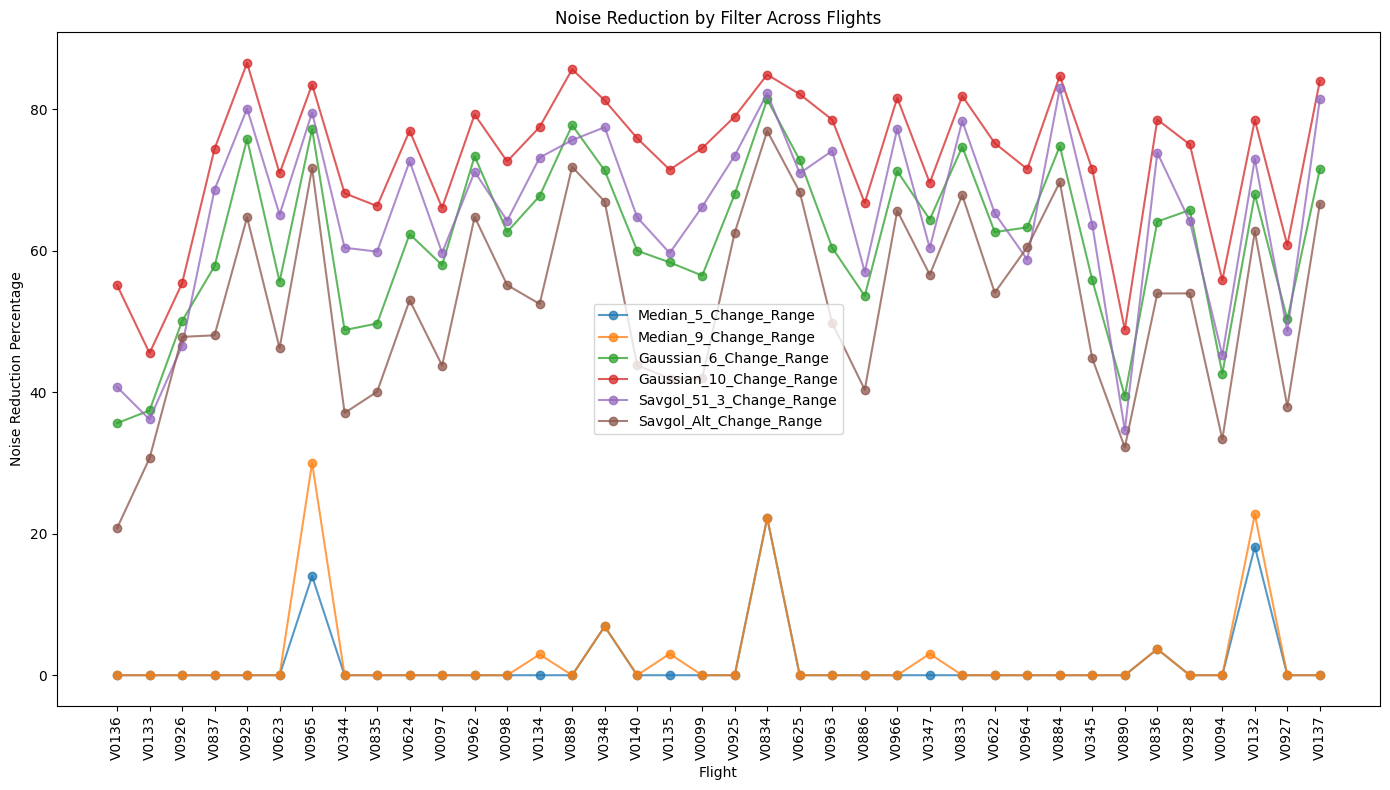

In [ ]:
import matplotlib.pyplot as plt


noise_reduction_columns = [col for col in comparison_df.columns if "Noise_Reduction" in col]
comparison_df_melted = comparison_df.melt(id_vars=['Flight'], value_vars=noise_reduction_columns, var_name='Filter', value_name='Noise Reduction Percentage')

plt.figure(figsize=(14, 8))
for filter_name in noise_reduction_columns:
    subset = comparison_df_melted[comparison_df_melted['Filter'] == filter_name]
    plt.plot(subset['Flight'], subset['Noise Reduction Percentage'], label=filter_name.replace('_Noise_Reduction', ''), marker='o', linestyle='-', alpha=0.75)

plt.xticks(rotation=90)
plt.ylabel('Noise Reduction Percentage')
plt.xlabel('Flight')
plt.title('Noise Reduction by Filter Across Flights')
plt.legend()
plt.tight_layout()
plt.show()




---


## 2.5 Noise Reduction for FUEL_USED_TOTAL


---



In [ ]:
msn02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 449039 entries, 1 to 623579
Data columns (total 31 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   UTC_TIME                                         449039 non-null  datetime64[ns]
 1   MSN                                              449039 non-null  object        
 2   Flight                                           449039 non-null  object        
 3   FLIGHT_PHASE_COUNT                               449002 non-null  float64       
 4   FUEL_USED_1                                      449039 non-null  float64       
 5   FUEL_USED_2                                      449039 non-null  float64       
 6   FUEL_USED_3                                      449039 non-null  float64       
 7   FUEL_USED_4                                      449039 non-null  float64       
 8   VALUE_FOB               

In [ ]:
msn02["FUEL_USED_TOTAL"] = msn02["FUEL_USED_1"] + msn02["FUEL_USED_2"] + msn02["FUEL_USED_3"] + msn02["FUEL_USED_4"]
msn02["FUEL_USED_TOTAL_change"]=msn02["FUEL_USED_TOTAL"].diff().fillna(0)

In [ ]:
from scipy.ndimage import gaussian_filter1d

msn02['FUEL_USED_TOTAL_gaussian_6'] = gaussian_filter1d(msn02["FUEL_USED_TOTAL"], 6)
msn02['FUEL_USED_TOTAL_gaussian_10'] = gaussian_filter1d(msn02["FUEL_USED_TOTAL"], 10)


In [ ]:
msn02['FUEL_USED_TOTAL_gaussian_6_change'] =msn02['FUEL_USED_TOTAL_gaussian_6'].diff().fillna(0)
msn02['FUEL_USED_TOTAL_gaussian_10_change']= msn02['FUEL_USED_TOTAL_gaussian_10'].diff().fillna(0)

In [ ]:
msn02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 449039 entries, 1 to 623579
Data columns (total 37 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   UTC_TIME                                         449039 non-null  datetime64[ns]
 1   MSN                                              449039 non-null  object        
 2   Flight                                           449039 non-null  object        
 3   FLIGHT_PHASE_COUNT                               449002 non-null  float64       
 4   FUEL_USED_1                                      449039 non-null  float64       
 5   FUEL_USED_2                                      449039 non-null  float64       
 6   FUEL_USED_3                                      449039 non-null  float64       
 7   FUEL_USED_4                                      449039 non-null  float64       
 8   VALUE_FOB               

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

phase_8_flights = msn02[msn02["FLIGHT_PHASE_COUNT"] == 8]
for element in list(phase_8_flights["Flight"].unique()):

    relation_FOB_FUSED = phase_8_flights[phase_8_flights["Flight"] == element].reset_index()


    start_time = relation_FOB_FUSED['UTC_TIME'].min()
    end_time = relation_FOB_FUSED['UTC_TIME'].max()
    flight_duration = (end_time - start_time).total_seconds() / 3600.0  # Convert to hours



    max_change_index = relation_FOB_FUSED["FUEL_USED_TOTAL_change"].idxmax()
    min_change_index = relation_FOB_FUSED['FUEL_USED_TOTAL_change'].idxmin()



    center_index = int(np.mean([max_change_index, min_change_index]))

    half_window_size = min(200, len(relation_FOB_FUSED) // 2)
    start_index = max(0, center_index - half_window_size)
    end_index = min(len(relation_FOB_FUSED), center_index + half_window_size)


    windowed_data = relation_FOB_FUSED.iloc[start_index:end_index]


    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.plot(windowed_data['index'], windowed_data['FUEL_USED_TOTAL_change'], label='Original TOTAL FUEL USED Change', color='green', alpha=0.75)
    ax1.plot(windowed_data['index'], windowed_data['FUEL_USED_TOTAL_gaussian_6_change'], label='Gaussian Filtered 6 TOTAL FUEL USED Change', color='purple', alpha=0.75)
    ax1.plot(windowed_data['index'], windowed_data['FUEL_USED_TOTAL_gaussian_10_change'], label='Gaussian Filtered 10 TOTAL FUEL USED Change', color='orange', alpha=0.75)


    ax1.set_xlabel('Index')
    ax1.set_ylabel('Change in TOTAL FUEL USED [kg/s]')
    ax1.set_title(f'TOTAL FUEL USED Change - Flight {element}\nFlight Duration: {flight_duration:.2f} hours', loc='center', pad=20)
    ax1.legend(loc='upper left')


    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
msn02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 449039 entries, 1 to 623579
Data columns (total 37 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   UTC_TIME                                         449039 non-null  datetime64[ns]
 1   MSN                                              449039 non-null  object        
 2   Flight                                           449039 non-null  object        
 3   FLIGHT_PHASE_COUNT                               449002 non-null  float64       
 4   FUEL_USED_1                                      449039 non-null  float64       
 5   FUEL_USED_2                                      449039 non-null  float64       
 6   FUEL_USED_3                                      449039 non-null  float64       
 7   FUEL_USED_4                                      449039 non-null  float64       
 8   VALUE_FOB               

In [ ]:
from scipy.signal import savgol_filter
import pandas as pd


window_size_1 = 51  # First Savgol filter configuration
poly_order_1 = 3

window_size_2 = 31  # Alternative Savgol filter configuration
poly_order_2 = 2

msn02['FUEL_USED_TOTAL_SG'] = savgol_filter(msn02["FUEL_USED_TOTAL"], window_size_1, poly_order_1)
msn02['FUEL_USED_TOTAL_SG_alt'] = savgol_filter(msn02["FUEL_USED_TOTAL"], window_size_2, poly_order_2)

msn02['FUEL_USED_TOTAL_SG_change']=msn02['FUEL_USED_TOTAL_SG'].diff().fillna(0)
msn02['FUEL_USED_TOTAL_SG_alt_change']=msn02['FUEL_USED_TOTAL_SG_alt'].diff().fillna(0)


In [ ]:
msn02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 449039 entries, 1 to 623579
Data columns (total 41 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   UTC_TIME                                         449039 non-null  datetime64[ns]
 1   MSN                                              449039 non-null  object        
 2   Flight                                           449039 non-null  object        
 3   FLIGHT_PHASE_COUNT                               449002 non-null  float64       
 4   FUEL_USED_1                                      449039 non-null  float64       
 5   FUEL_USED_2                                      449039 non-null  float64       
 6   FUEL_USED_3                                      449039 non-null  float64       
 7   FUEL_USED_4                                      449039 non-null  float64       
 8   VALUE_FOB               

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

phase_8_flights=msn02[msn02["FLIGHT_PHASE_COUNT"]==8]

for element in list(phase_8_flights["Flight"].unique()):

    relation_FOB_FUSED = phase_8_flights[phase_8_flights["Flight"] == element].reset_index()


    start_time = relation_FOB_FUSED['UTC_TIME'].min()
    end_time = relation_FOB_FUSED['UTC_TIME'].max()
    flight_duration = (end_time - start_time).total_seconds() / 3600.0  # Convert to hours


    max_change_index = relation_FOB_FUSED['FUEL_USED_TOTAL_change'].idxmax()
    min_change_index = relation_FOB_FUSED['FUEL_USED_TOTAL_change'].idxmin()



    center_index = int(np.mean([max_change_index, min_change_index]))

    half_window_size = min(200, len(relation_FOB_FUSED) // 2)
    start_index = max(0, center_index - half_window_size)
    end_index = min(len(relation_FOB_FUSED), center_index + half_window_size)


    windowed_data = relation_FOB_FUSED.iloc[start_index:end_index]


    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.plot(windowed_data['index'], windowed_data['FUEL_USED_TOTAL_change'], label='Original TOTAL FUEL USED Change', color='green', alpha=0.75)
    ax1.plot(windowed_data['index'], windowed_data['FUEL_USED_TOTAL_SG_change'], label='Savgol Filtered TOTAL FUEL USED Change', color='pink', alpha=0.75)
    ax1.plot(windowed_data['index'], windowed_data['FUEL_USED_TOTAL_SG_alt_change'], label='Soft Savgol Filtered TOTAL FUEL USED Change', color='black', alpha=0.75)


    ax1.set_xlabel('Index')
    ax1.set_ylabel('Change in TOTAL FUEL USED [kg/s]')
    ax1.set_title(f'TOTAL FUEL USED Change - Flight {element}\nFlight Duration: {flight_duration:.2f} hours', loc='center', pad=20)
    ax1.legend(loc='upper left')


    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
msn02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 449039 entries, 1 to 623579
Data columns (total 41 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   UTC_TIME                                         449039 non-null  datetime64[ns]
 1   MSN                                              449039 non-null  object        
 2   Flight                                           449039 non-null  object        
 3   FLIGHT_PHASE_COUNT                               449002 non-null  float64       
 4   FUEL_USED_1                                      449039 non-null  float64       
 5   FUEL_USED_2                                      449039 non-null  float64       
 6   FUEL_USED_3                                      449039 non-null  float64       
 7   FUEL_USED_4                                      449039 non-null  float64       
 8   VALUE_FOB               



---


### 2.5.1 Choice of Filter


---



In [ ]:
comparison_df = pd.DataFrame(columns=[
    'Flight',
    'FUEL_USED_TOTAL_Change_Range',
    'FUEL_USED_TOTAL_Gaussian_6_Change_Range',
    'FUEL_USED_TOTAL_Gaussian_10_Change_Range',
    'FUEL_USED_TOTAL_SG_Change_Range',
    'FUEL_USED_TOTAL_SG_Alt_Change_Range'
])
phase_8_flights = msn02[msn02["FLIGHT_PHASE_COUNT"] == 8]
for element in phase_8_flights["Flight"].unique():
    flight_data = phase_8_flights[phase_8_flights["Flight"] == element]

    # Calculating ranges for FUEL_USED_TOTAL_change and its Gaussian and Savgol filtered variants
    fuel_used_total_change_range = flight_data['FUEL_USED_TOTAL_change'].abs().max() - flight_data['FUEL_USED_TOTAL_change'].abs().min()
    fuel_used_total_gaussian_6_change_range = flight_data['FUEL_USED_TOTAL_gaussian_6_change'].abs().max() - flight_data['FUEL_USED_TOTAL_gaussian_6_change'].abs().min()
    fuel_used_total_gaussian_10_change_range = flight_data['FUEL_USED_TOTAL_gaussian_10_change'].abs().max() - flight_data['FUEL_USED_TOTAL_gaussian_10_change'].abs().min()
    fuel_used_total_sg_change_range = flight_data['FUEL_USED_TOTAL_SG_change'].abs().max() - flight_data['FUEL_USED_TOTAL_SG_change'].abs().min()
    fuel_used_total_sg_alt_change_range = flight_data['FUEL_USED_TOTAL_SG_alt_change'].abs().max() - flight_data['FUEL_USED_TOTAL_SG_alt_change'].abs().min()

    # Append the results to comparison_df
    comparison_df = comparison_df.append({
        'Flight': element,
        'FUEL_USED_TOTAL_Change_Range': fuel_used_total_change_range,
        'FUEL_USED_TOTAL_Gaussian_6_Change_Range': fuel_used_total_gaussian_6_change_range,
        'FUEL_USED_TOTAL_Gaussian_10_Change_Range': fuel_used_total_gaussian_10_change_range,
        'FUEL_USED_TOTAL_SG_Change_Range': fuel_used_total_sg_change_range,
        'FUEL_USED_TOTAL_SG_Alt_Change_Range': fuel_used_total_sg_alt_change_range
    }, ignore_index=True)

comparison_df

<ipython-input-267-8336fae5b37b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
<ipython-input-267-8336fae5b37b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
<ipython-input-267-8336fae5b37b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
<ipython-input-267-8336fae5b37b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
<ipython-input-267-8336fae5b37b>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

,Flight,FUEL_USED_TOTAL_Change_Range,FUEL_USED_TOTAL_Gaussian_6_Change_Range,FUEL_USED_TOTAL_Gaussian_10_Change_Range,FUEL_USED_TOTAL_SG_Change_Range,FUEL_USED_TOTAL_SG_Alt_Change_Range
0,V0136,1.98800,1.748190,1.754731,1.900492,1.904179
1,V0133,1.94600,1.763953,1.747142,1.928802,1.922652
2,V0926,1.87800,1.790783,1.787976,1.860010,1.847644
3,V0837,1.93820,1.806619,1.798897,1.894485,1.881403
4,V0929,2.01590,1.858458,1.855127,1.886324,1.917754
5,V0623,2.10880,1.894774,1.883753,1.932095,1.929592
6,V0965,2.10867,1.939987,1.919876,1.977723,1.978037
7,V0344,2.09542,1.930531,1.925345,1.934066,2.017458
8,V0835,2.11288,1.912590,1.899312,1.967703,1.961983
9,V0624,2.30671,3.205412,2.399765,2.556284,3.712611


In [ ]:
for col in ['FUEL_USED_TOTAL_Gaussian_6_Change_Range', 'FUEL_USED_TOTAL_Gaussian_10_Change_Range', 'FUEL_USED_TOTAL_SG_Change_Range','FUEL_USED_TOTAL_SG_Alt_Change_Range']:
    comparison_df[f'{col}_Noise_Reduction'] = 100 * (1 - (comparison_df[col] / comparison_df['FUEL_USED_TOTAL_Change_Range']))


comparison_df



,Flight,FUEL_USED_TOTAL_Change_Range,FUEL_USED_TOTAL_Gaussian_6_Change_Range,FUEL_USED_TOTAL_Gaussian_10_Change_Range,FUEL_USED_TOTAL_SG_Change_Range,FUEL_USED_TOTAL_SG_Alt_Change_Range,FUEL_USED_TOTAL_Gaussian_6_Change_Range_Noise_Reduction,FUEL_USED_TOTAL_Gaussian_10_Change_Range_Noise_Reduction,FUEL_USED_TOTAL_SG_Change_Range_Noise_Reduction,FUEL_USED_TOTAL_SG_Alt_Change_Range_Noise_Reduction
0,V0136,1.98800,1.748190,1.754731,1.900492,1.904179,12.062859,11.733842,4.401824,4.216339
1,V0133,1.94600,1.763953,1.747142,1.928802,1.922652,9.354952,10.218789,0.883780,1.199777
2,V0926,1.87800,1.790783,1.787976,1.860010,1.847644,4.644164,4.793611,0.957958,1.616393
3,V0837,1.93820,1.806619,1.798897,1.894485,1.881403,6.788824,7.187258,2.255455,2.930417
4,V0929,2.01590,1.858458,1.855127,1.886324,1.917754,7.810005,7.975232,6.427690,4.868606
5,V0623,2.10880,1.894774,1.883753,1.932095,1.929592,10.149192,10.671817,8.379396,8.498109
6,V0965,2.10867,1.939987,1.919876,1.977723,1.978037,7.999500,8.953223,6.209949,6.195046
7,V0344,2.09542,1.930531,1.925345,1.934066,2.017458,7.869041,8.116517,7.700295,3.720605
8,V0835,2.11288,1.912590,1.899312,1.967703,1.961983,9.479477,10.107911,6.871043,7.141763
9,V0624,2.30671,3.205412,2.399765,2.556284,3.712611,-38.960340,-4.034085,-10.819474,-60.948317


In [ ]:
# Calculate the average noise reduction percentage for each filter
average_noise_reduction = {}
for col in ['FUEL_USED_TOTAL_Gaussian_6_Change_Range', 'FUEL_USED_TOTAL_Gaussian_10_Change_Range', 'FUEL_USED_TOTAL_SG_Change_Range','FUEL_USED_TOTAL_SG_Alt_Change_Range']:
    noise_reduction_column = f'{col}_Noise_Reduction'
    average_noise_reduction[col] = comparison_df[noise_reduction_column].mean()

average_noise_reduction

{'FUEL_USED_TOTAL_Gaussian_6_Change_Range': 10.806942588157902,
 'FUEL_USED_TOTAL_Gaussian_10_Change_Range': 12.885373604102485,
 'FUEL_USED_TOTAL_SG_Change_Range': 7.931008250635915,
 'FUEL_USED_TOTAL_SG_Alt_Change_Range': 6.023058433063435}

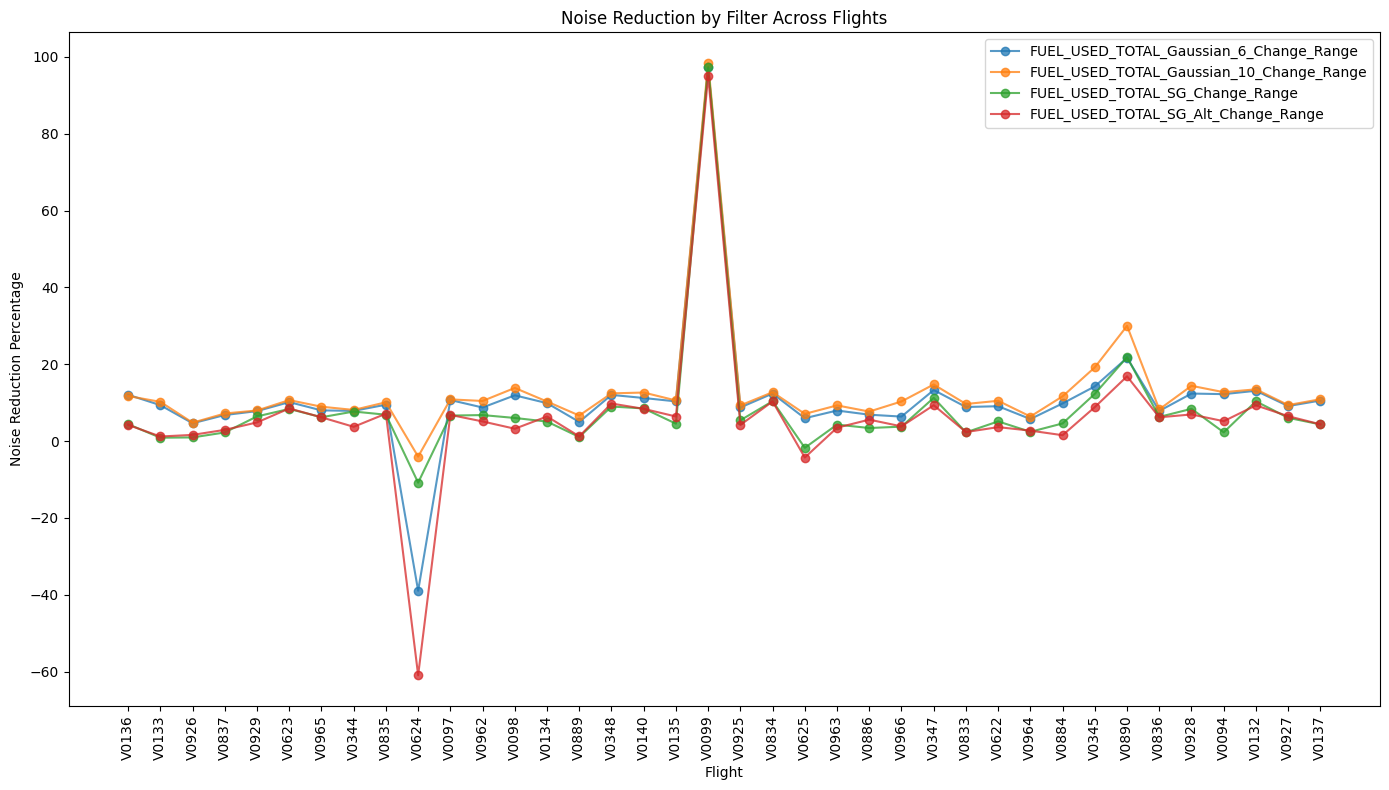

In [ ]:
import matplotlib.pyplot as plt


noise_reduction_columns = [col for col in comparison_df.columns if "Noise_Reduction" in col]
comparison_df_melted = comparison_df.melt(id_vars=['Flight'], value_vars=noise_reduction_columns, var_name='Filter', value_name='Noise Reduction Percentage')

plt.figure(figsize=(14, 8))
for filter_name in noise_reduction_columns:
    subset = comparison_df_melted[comparison_df_melted['Filter'] == filter_name]
    plt.plot(subset['Flight'], subset['Noise Reduction Percentage'], label=filter_name.replace('_Noise_Reduction', ''), marker='o', linestyle='-', alpha=0.75)

plt.xticks(rotation=90)
plt.ylabel('Noise Reduction Percentage')
plt.xlabel('Flight')
plt.title('Noise Reduction by Filter Across Flights')
plt.legend()
plt.tight_layout()
plt.show()

we continue the FUEL_USED_TOTAL with the gaussian 10 !!

In [ ]:
msn02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 449039 entries, 1 to 623579
Data columns (total 41 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   UTC_TIME                                         449039 non-null  datetime64[ns]
 1   MSN                                              449039 non-null  object        
 2   Flight                                           449039 non-null  object        
 3   FLIGHT_PHASE_COUNT                               449002 non-null  float64       
 4   FUEL_USED_1                                      449039 non-null  float64       
 5   FUEL_USED_2                                      449039 non-null  float64       
 6   FUEL_USED_3                                      449039 non-null  float64       
 7   FUEL_USED_4                                      449039 non-null  float64       
 8   VALUE_FOB               

In [ ]:
msn02.shape

(449039, 41)



---


## 2.6 Filter for Flight Phase 8


---



- **Code Explanation and Purpose:**
  - We're filtering for flight phase 8 to focus on a specific phase of flight.
  
- **Why did we do it?**
  - Filtering for flight phase 8 allows us to narrow down our analysis to a specific phase of flight where we expect the data to be most relevant for our purposes.
  - Also as previously mentioned the smoothing techniques caused Edge Effects, so too avoid it we filtered only for the stable cruise flight phase.
  
- **What did we do next?**
  - Compared Gaussian and Savgol again but now for Flight Phase 8


In [ ]:
msn02 = msn02[msn02['FLIGHT_PHASE_COUNT'].isin([8])]

In [ ]:
msn02.shape

(361384, 41)



---


# 3.Feature Engineering I


---





- **Code Explanation and Purpose**:
  - Here we perform feature engineering to understand fuel leakages in the dataset better.
- **Why did we do it?**
  - We aim to create features that help us analyze fuel leakages and their appearance patterns.
- **What did we do next?**
  - We continue by calculating various fuel-related metrics and preparing the data for further analysis.

---


- How and Why?
  - These calculations provide us with essential metrics related to fuel consumption, which are crucial for identifying and analyzing fuel leakages.





---



1. we sum the `FUEL_USED_1` - `FUEL_USED_4` rowwise. Those columns show th amount of fuel in **Kg/s** used for each engine. so this sum shows the *consumption of fuel* in **kg/s** for the aircraft.

$$
\text{FUEL_USED_TOTAL} (t) = \sum_{i=1}^{4} \text{FUEL_USED_i} (t)
$$

2. We calculate the change of consumption of fuel in kg/s

$$
\text{FUEL_USED_TOTAL_change} (t) = \text{FUEL_USED_TOTAL} (t) - \text{FUEL_USED_TOTAL} (t - 1)
$$

3. And now we did the sum of the change of consumption of fuel to get the Amount of Fuel in Kg up until a point of time t

$$
\text{FUEL_USED_TOTAL_cumulative} (t) = \sum_{i=1}^{t} \text{FUEL_USED_TOTAL_change} (t=i)
$$

4. Now we calculated the expected/estimated Fuel on Board in Kg based on the first value of `VALUE_FOB` at **t=0 ** - the amount of Fuel used in kg up until a point of time t (`FUEL_USED_TOTAL_cumulative`)

$$
\text{FOB_EST} (t) =  \text{VALUE_FOB}(t=0) -  \text{FUEL_USED_TOTAL_cumulative} (t=i)
$$

In [ ]:
msn02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361384 entries, 2298 to 622953
Data columns (total 41 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   UTC_TIME                                         361384 non-null  datetime64[ns]
 1   MSN                                              361384 non-null  object        
 2   Flight                                           361384 non-null  object        
 3   FLIGHT_PHASE_COUNT                               361384 non-null  float64       
 4   FUEL_USED_1                                      361384 non-null  float64       
 5   FUEL_USED_2                                      361384 non-null  float64       
 6   FUEL_USED_3                                      361384 non-null  float64       
 7   FUEL_USED_4                                      361384 non-null  float64       
 8   VALUE_FOB            

In [ ]:

msn02['Time_diff_seconds'] = msn02.groupby('Flight')['UTC_TIME'].diff().dt.total_seconds().fillna(0)


msn02['FUEL_USED_TOTAL_cumulative'] =msn02.groupby("Flight") ['FUEL_USED_TOTAL_change'].cumsum()
msn02['FUEL_USED_TOTAL_cumulative_gaussian'] = msn02.groupby("Flight")['FUEL_USED_TOTAL_gaussian_10_change'].cumsum()
msn02['FUEL_USED_TOTAL_cumulative_SG'] = msn02.groupby("Flight")['FUEL_USED_TOTAL_SG_change'].cumsum()
msn02['FUEL_USED_TOTAL_cumulative_SG_alt'] = msn02.groupby("Flight")['FUEL_USED_TOTAL_SG_alt_change'].cumsum()

In [ ]:
msn02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361384 entries, 2298 to 622953
Data columns (total 46 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   UTC_TIME                                         361384 non-null  datetime64[ns]
 1   MSN                                              361384 non-null  object        
 2   Flight                                           361384 non-null  object        
 3   FLIGHT_PHASE_COUNT                               361384 non-null  float64       
 4   FUEL_USED_1                                      361384 non-null  float64       
 5   FUEL_USED_2                                      361384 non-null  float64       
 6   FUEL_USED_3                                      361384 non-null  float64       
 7   FUEL_USED_4                                      361384 non-null  float64       
 8   VALUE_FOB            

In [ ]:
# Group by 'Flight' and transform 'VALUE_FOB' to get the first value for each flight
msn02['VALUE_FOB_first'] = msn02.groupby('Flight')['VALUE_FOB'].transform('first')
msn02['VALUE_FOB_gaussian_first'] = msn02.groupby('Flight')['VALUE_FOB_gaussian_10'].transform('first')
msn02["VALUE_FOB_median_filtered_first"]=msn02.groupby('Flight')['VALUE_FOB_median_filtered_9'].transform('first')
msn02["VALUE_FOB_SG_first"]=msn02.groupby('Flight')['VALUE_FOB_SG'].transform('first')
msn02["VALUE_FOB_SG_alt_first"]=msn02.groupby('Flight')['VALUE_FOB_SG_alt'].transform('first')

# Recalculate FOB_EST using the first VALUE_FOB of each flight
msn02["FOB_EST"] = msn02["VALUE_FOB_first"] - msn02["FUEL_USED_TOTAL_cumulative"]
msn02["FOB_EST_gaussian"] = msn02["VALUE_FOB_gaussian_first"] - msn02["FUEL_USED_TOTAL_cumulative_gaussian"]
msn02["FOB_EST_median_filtered"] = msn02["VALUE_FOB_median_filtered_first"] - msn02["FUEL_USED_TOTAL_cumulative"]


#because we decided to continue with gaussian filterd fuel_used_Total
msn02["FOB_EST_SG"]=msn02["VALUE_FOB_SG_first"] - msn02["FUEL_USED_TOTAL_cumulative_SG"]
msn02["FOB_EST_SG_alt"]=msn02["VALUE_FOB_SG_first"] - msn02["FUEL_USED_TOTAL_cumulative_SG_alt"]

In [ ]:
msn02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361384 entries, 2298 to 622953
Data columns (total 56 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   UTC_TIME                                         361384 non-null  datetime64[ns]
 1   MSN                                              361384 non-null  object        
 2   Flight                                           361384 non-null  object        
 3   FLIGHT_PHASE_COUNT                               361384 non-null  float64       
 4   FUEL_USED_1                                      361384 non-null  float64       
 5   FUEL_USED_2                                      361384 non-null  float64       
 6   FUEL_USED_3                                      361384 non-null  float64       
 7   FUEL_USED_4                                      361384 non-null  float64       
 8   VALUE_FOB            

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'msn02' is a DataFrame with 'Flight', 'UTC_TIME', 'VALUE_FOB', and other relevant columns

window_size = 150  # This is the number of indices before and after the max change you want to display

for element in msn02["Flight"].unique():
    # Filter the dataframe for the current element (flight)
    relation_FOB_FUSED = msn02[msn02["Flight"] == element].reset_index()

    # Find the index of the maximum change
    max_change_index = relation_FOB_FUSED['FOB_change'].idxmax()

    # Define the window around the maximum change
    window_start = max(max_change_index - window_size, 0)
    window_end = min(max_change_index + window_size, len(relation_FOB_FUSED) - 1)

    # Filter the dataframe to only include the window around the maximum change
    windowed_data = relation_FOB_FUSED.iloc[window_start:window_end+1]

    start_time = windowed_data['UTC_TIME'].iloc[0]
    end_time = windowed_data['UTC_TIME'].iloc[-1]
    flight_duration = (end_time - start_time).total_seconds() / 60.0  # Convert to minutes

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(windowed_data['index'], windowed_data['VALUE_FOB_SG'], label='FOB SG Value')
    ax.plot(windowed_data['index'], windowed_data['VALUE_FOB_SG_alt'], label='FOB Soft SG Value')
    ax.plot(windowed_data['index'], windowed_data['VALUE_FOB_gaussian_10'], label='FOB Gaussian Value')
    ax.plot(windowed_data['index'], windowed_data['FOB_EST_gaussian'], label='EST. FOB Gaussian Filter Value')
    ax.plot(windowed_data['index'], windowed_data['FOB_EST_SG'], label='EST. FOB Savgol Filter Value')
    ax.plot(windowed_data['index'], windowed_data['FOB_EST_SG_alt'], label='EST. FOB Soft Savgol Filter Value')

    # Set labels and title
    ax.set_xlabel('Index')
    ax.set_ylabel('FOB Value [kg]')
    ax.set_title(f"Window around Max FOB Change - Flight {element}\nFlight Duration: {flight_duration:.2f} mins")

    ax.legend(loc='upper left')
    plt.xticks(rotation=45)

    fig.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for element in list(msn02["Flight"].unique()):
  import matplotlib.pyplot as plt
  relation_FOB_FUSED = msn02[msn02["Flight"] == element]
  # Plotting
  plt.figure(figsize=(10, 6))
  #plt.plot(relation_FOB_FUSED['UTC_TIME'], relation_FOB_FUSED['VALUE_FOB_median_filtered_9'], label='FOB Median Filter Value')
  plt.plot(relation_FOB_FUSED['UTC_TIME'], relation_FOB_FUSED['VALUE_FOB_SG'], label='FOB SG Value')
  #plt.plot(relation_FOB_FUSED['UTC_TIME'], relation_FOB_FUSED['VALUE_FOB'], label='Original FOB Value')
  plt.plot(relation_FOB_FUSED['UTC_TIME'], relation_FOB_FUSED['FOB_EST_gaussian'], label='EST. FOB Gaussian Filter Value')
  plt.plot(relation_FOB_FUSED['UTC_TIME'], relation_FOB_FUSED['FOB_EST_SG'], label='EST. FOB Savgol Filter Value')
  #plt.plot(relation_FOB_FUSED['UTC_TIME'], relation_FOB_FUSED['FOB_EST_median_filtered'], label='EST. FOB Median Filter Value')
  plt.xlabel('UTC Time')
  plt.ylabel('Value')
  plt.title(f'All smootheed: FOB Value and EST FOB Value -  Over Time for Flight {element}')
  plt.legend()
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
  plt.show()

Output hidden; open in https://colab.research.google.com to view.


---

# 4.Data Augmentation


---




Create Aritficial Flights

- **Code Explanation and Purpose:**
  - This section creates artificial flights with simulated fuel leakages at different rates to train the LSTM model for binary target classification.

- **Why did we do it?**
  - Artificial flights are created to provide additional training data for the LSTM model. These flights simulate fuel leakages at various rates (heavy, medium, light) to enable the model to learn and classify flights based on the presence or absence of fuel leaks.

- **What did we do next?**
  - After creating the artificial flights, we proceeded with feature engineering and analysis to prepare the data for training the LSTM model.


In [ ]:
len(msn02["Flight"].unique())

38

In [ ]:
print("WORKED")

WORKED


In [ ]:
msn02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361384 entries, 2298 to 622953
Data columns (total 56 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   UTC_TIME                                         361384 non-null  datetime64[ns]
 1   MSN                                              361384 non-null  object        
 2   Flight                                           361384 non-null  object        
 3   FLIGHT_PHASE_COUNT                               361384 non-null  float64       
 4   FUEL_USED_1                                      361384 non-null  float64       
 5   FUEL_USED_2                                      361384 non-null  float64       
 6   FUEL_USED_3                                      361384 non-null  float64       
 7   FUEL_USED_4                                      361384 non-null  float64       
 8   VALUE_FOB            

In [ ]:
import pandas as pd
import numpy as np


last_utc = pd.to_datetime(msn02['UTC_TIME'].max())

first_utc = pd.to_datetime('2002-01-01')


new_flights_with_leak = []


leakage_rates = [1, 0.5, 0.8]


flights_per_rate = 6


def create_flights(start_date, pre=True):
    global new_flights_with_leak
    start_sequence = 1
    for leakage_rate in leakage_rates:
        for _ in range(flights_per_rate):
            random_flight = np.random.choice(msn02['Flight'].unique(), replace=False)
            flight_data = msn02[msn02['Flight'] == random_flight].copy()
            flight_data.reset_index(drop=True, inplace=True)


            valid_start_points = flight_data[flight_data['FLIGHT_PHASE_COUNT'] == 8].index

            new_flight_name = f"{'Pre' if pre else 'Post'}_Artificial_V{start_sequence:04d}_{leakage_rate}"
            flight_data['Flight'] = new_flight_name

            # Assign new UTC_TIME for the artificial flight
            flight_data['UTC_TIME'] = pd.date_range(start=start_date, periods=len(flight_data), freq='S')

            if not valid_start_points.empty:
                leakage_start_point = np.random.choice(valid_start_points)
                flight_data.loc[leakage_start_point:, 'REAL_LEAK'] = 1  # Set REAL_LEAK to 1 from leakage start point


                flight_data.loc[leakage_start_point:, 'VALUE_FOB'] -= leakage_rate * (flight_data.loc[leakage_start_point:, 'UTC_TIME'].diff().dt.total_seconds().cumsum().fillna(0))
                flight_data.loc[leakage_start_point:, 'VALUE_FOB_gaussian_10'] -= leakage_rate *(flight_data.loc[leakage_start_point:, 'UTC_TIME'].diff().dt.total_seconds().cumsum().fillna(0))
                flight_data.loc[leakage_start_point:, 'VALUE_FOB_SG'] -= leakage_rate *(flight_data.loc[leakage_start_point:, 'UTC_TIME'].diff().dt.total_seconds().cumsum().fillna(0))
                flight_data.loc[leakage_start_point:, 'VALUE_FOB_median_filtered_9'] -= leakage_rate *(flight_data.loc[leakage_start_point:, 'UTC_TIME'].diff().dt.total_seconds().cumsum().fillna(0))


            new_flights_with_leak.append(flight_data)

            # Update start_sequence for unique naming
            start_sequence += 1

            # Update start_date for the next
            start_date += pd.Timedelta(days=182)  # Move half a year for the next flight


pre_start_date = first_utc - pd.Timedelta(days=182 * flights_per_rate)
create_flights(pre_start_date, pre=True)


post_start_date = last_utc + pd.Timedelta(days=182 * flights_per_rate)
create_flights(post_start_date, pre=False)


new_flights_with_leak_df = pd.concat(new_flights_with_leak)


In [ ]:
"""import pandas as pd
import numpy as np

# Define the last UTC_TIME and start_date for creating artificial flights
last_utc = pd.to_datetime(msn02['UTC_TIME'].max())
start_date = last_utc + pd.Timedelta(days=1)

# Initialize the list to store artificial flights
new_flights_with_leak = []

# Define a list of leakage rates
leakage_rates = [1, 0.5, 0.8]

# Iterate over leakage rates to create artificial flights
for leakage_rate in leakage_rates:
    start_sequence = 1
    random_flights = np.random.choice(msn02['Flight'].unique(), 10, replace=False)  # Using 2 for demonstration

    for flight_index, flight in enumerate(random_flights, start=1):
        flight_data = msn02[msn02['Flight'] == flight].copy()
        flight_data.reset_index(drop=True, inplace=True)

        new_flight_name = f"Artificial_V{start_sequence + flight_index:04d}_{leakage_rate}"
        flight_data['Flight'] = new_flight_name

        # Assign new UTC_TIME for the artificial flight
        flight_data['UTC_TIME'] = pd.date_range(start=start_date, periods=len(flight_data), freq='S')

        # Initialize 'REAL_LEAK' column to 0 (no leak)
        flight_data['REAL_LEAK'] = 0

        # Identify valid start points for leakage (FLIGHT_PHASE_COUNT == 8)
        valid_start_points = flight_data[flight_data['FLIGHT_PHASE_COUNT'] == 8].index

        if not valid_start_points.empty:
            leakage_start_point = np.random.choice(valid_start_points)
            flight_data.loc[leakage_start_point:, 'REAL_LEAK'] = 1  # Set REAL_LEAK to 1 from leakage start point

            # Apply the leakage rate to the FOB values after the leakage start point
            #flight_data.loc[leakage_start_point:, 'VALUE_FOB'] -= leakage_rate * (flight_data.loc[leakage_start_point:, 'UTC_TIME'].diff().dt.total_seconds().cumsum().fillna(0))
            flight_data.loc[leakage_start_point:, 'VALUE_FOB'] -= leakage_rate *(flight_data.loc[leakage_start_point:, 'UTC_TIME'].diff().dt.total_seconds().cumsum().fillna(0))
            flight_data.loc[leakage_start_point:, 'VALUE_FOB_gaussian_10'] -= leakage_rate *(flight_data.loc[leakage_start_point:, 'UTC_TIME'].diff().dt.total_seconds().cumsum().fillna(0))
            flight_data.loc[leakage_start_point:, 'VALUE_FOB_SG'] -= leakage_rate *(flight_data.loc[leakage_start_point:, 'UTC_TIME'].diff().dt.total_seconds().cumsum().fillna(0))
            flight_data.loc[leakage_start_point:, 'VALUE_FOB_median_filtered_9'] -= leakage_rate *(flight_data.loc[leakage_start_point:, 'UTC_TIME'].diff().dt.total_seconds().cumsum().fillna(0))

        # Update start_date for the next artificial flight
        start_date = flight_data['UTC_TIME'].iloc[-1] + pd.Timedelta(seconds=1)

        # Append modified flight_data to the list of new flights
        new_flights_with_leak.append(flight_data)

        # Increment start_sequence for unique naming in the next batch
        start_sequence += 10

# Combine all new flights into a single DataFrame
new_flights_with_leak_df = pd.concat(new_flights_with_leak)"""




'import pandas as pd\nimport numpy as np\n\n# Define the last UTC_TIME and start_date for creating artificial flights\nlast_utc = pd.to_datetime(msn02[\'UTC_TIME\'].max())\nstart_date = last_utc + pd.Timedelta(days=1)\n\n# Initialize the list to store artificial flights\nnew_flights_with_leak = []\n\n# Define a list of leakage rates\nleakage_rates = [1, 0.5, 0.8]\n\n# Iterate over leakage rates to create artificial flights\nfor leakage_rate in leakage_rates:\n    start_sequence = 1\n    random_flights = np.random.choice(msn02[\'Flight\'].unique(), 10, replace=False)  # Using 2 for demonstration\n\n    for flight_index, flight in enumerate(random_flights, start=1):\n        flight_data = msn02[msn02[\'Flight\'] == flight].copy()\n        flight_data.reset_index(drop=True, inplace=True)\n\n        new_flight_name = f"Artificial_V{start_sequence + flight_index:04d}_{leakage_rate}"\n        flight_data[\'Flight\'] = new_flight_name\n\n        # Assign new UTC_TIME for the artificial flight

In [ ]:
new_flights_with_leak_df.head()

,UTC_TIME,MSN,Flight,FLIGHT_PHASE_COUNT,FUEL_USED_1,FUEL_USED_2,FUEL_USED_3,FUEL_USED_4,VALUE_FOB,UTC_TIME_obj,DATE,TIME,FOB_change,VALUE_FOB_median_filtered_5,VALUE_FOB_median_filtered_9,VALUE_FOB_median_filtered_5_change,VALUE_FOB_median_filtered_9_change,Difference_VALUE_FOB_vs_FOB_medianfiltered_5,Difference_VALUE_FOB_vs_FOB_medianfiltered_9,VALUE_FOB_gaussian_6,VALUE_FOB_gaussian_10,Difference_VALUE_FOB_vs_FOB_gaussianfiltered_6,Difference_VALUE_FOB_vs_FOB_gaussianfiltered_10,VALUE_FOB_gaussian_6_change,VALUE_FOB_gaussian_10_change,VALUE_FOB_SG,Difference_VALUE_FOB_vs_FOB_SG,VALUE_FOB_SG_change,VALUE_FOB_SG_alt,Difference_VALUE_FOB_vs_FOB_SG_alt,VALUE_FOB_SG_alt_change,FUEL_USED_TOTAL,FUEL_USED_TOTAL_change,FUEL_USED_TOTAL_gaussian_6,FUEL_USED_TOTAL_gaussian_10,FUEL_USED_TOTAL_gaussian_6_change,FUEL_USED_TOTAL_gaussian_10_change,FUEL_USED_TOTAL_SG,FUEL_USED_TOTAL_SG_alt,FUEL_USED_TOTAL_SG_change,FUEL_USED_TOTAL_SG_alt_change,Time_diff_seconds,FUEL_USED_TOTAL_cumulative,FUEL_USED_TOTAL_cumulative_gaussian,FUEL_USED_TOTAL_cumulative_SG,FUEL_USED_TOTAL_cumulative_SG_alt,VALUE_FOB_first,VALUE_FOB_gaussian_first,VALUE_FOB_median_filtered_first,VALUE_FOB_SG_first,VALUE_FOB_SG_alt_first,FOB_EST,FOB_EST_gaussian,FOB_EST_median_filtered,FOB_EST_SG,FOB_EST_SG_alt,REAL_LEAK
0,1999-01-05 00:00:00,A400M-0002,Pre_Artificial_V0001_1,8.0,106.9889,102.9023,100.0469,96.66387,17651.0,2012-10-23 14:21:03,2012-10-23,14:21:03,1.0,17650.0,17650.0,-1.0,-1.0,-1.0,-1.0,17653.586710,17657.771230,2.586710,6.771230,-3.221921,-3.528339,17651.844821,0.844821,-3.330019,17651.228537,0.228537,-3.249772,406.60197,2.30503,406.587543,406.548895,2.273649,2.273307,406.606158,406.606175,2.272549,2.274533,0.0,2.30503,2.273307,2.272549,2.274533,17651.0,17657.77123,17650.0,17651.844821,17651.228537,17648.69497,17655.497923,17647.69497,17649.572272,17649.570288,NaN
1,1999-01-05 00:00:01,A400M-0002,Pre_Artificial_V0001_1,8.0,107.5555,103.4602,100.6122,97.22472,17648.0,2012-10-23 14:21:04,2012-10-23,14:21:04,-3.0,17648.0,17648.0,-2.0,-2.0,0.0,0.0,17650.517497,17654.365353,2.517497,6.365353,-3.069213,-3.405877,17648.871141,0.871141,-2.973680,17648.421074,0.421074,-2.807463,408.85262,2.25065,408.859962,408.821003,2.272419,2.272108,408.880693,408.880122,2.274535,2.273947,1.0,4.55568,4.545415,4.547084,4.548480,17651.0,17657.77123,17650.0,17651.844821,17651.228537,17646.44432,17653.225815,17645.44432,17647.297737,17647.296341,NaN
2,1999-01-05 00:00:02,A400M-0002,Pre_Artificial_V0001_1,8.0,108.1210,104.0192,101.2268,97.83674,17643.0,2012-10-23 14:21:05,2012-10-23,14:21:05,-5.0,17645.0,17645.0,-3.0,-3.0,2.0,2.0,17647.584287,17651.074231,4.584287,8.074231,-2.933210,-3.291122,17645.875490,2.875490,-2.995651,17645.641622,2.641622,-2.779452,411.20374,2.35112,411.131134,411.091907,2.271173,2.270904,411.152515,411.152828,2.271822,2.272706,1.0,6.90680,6.816318,6.818906,6.821186,17651.0,17657.77123,17650.0,17651.844821,17651.228537,17644.09320,17650.954912,17643.09320,17645.025915,17645.023635,NaN
3,1999-01-05 00:00:03,A400M-0002,Pre_Artificial_V0001_1,8.0,108.6849,104.5785,101.7917,98.39786,17645.0,2012-10-23 14:21:06,2012-10-23,14:21:06,2.0,17643.0,17643.0,-2.0,-2.0,-2.0,-2.0,17644.768677,17647.890272,-0.231323,2.890272,-2.815610,-3.183960,17643.085121,-1.914879,-2.790369,17642.999090,-2.000910,-2.642532,413.45296,2.24922,413.401049,413.361600,2.269914,2.269693,413.423254,413.424671,2.270739,2.271844,1.0,9.15602,9.086011,9.089646,9.093030,17651.0,17657.77123,17650.0,17651.844821,17651.228537,17641.84398,17648.685219,17640.84398,17642.755175,17642.751791,NaN
4,1999-01-05 00:00:04,A400M-0002,Pre_Artificial_V0001_1,8.0,109.2466,105.1400,102.3553,98.95853,17642.0,2012-10-23 14:21:07,2012-10-23,14:21:07,-3.0,17642.0,17642.0,-1.0,-1.0,0.0,0.0,17642.050813,17644.805642,0.050813,2.805642,-2.717864,-3.084629,17640.242882,-1.757118,-2.842239,17640.509556,-1.490444,-2.489534,415.70043,2.24747,415.669698,415.630076,2.268649,2.268476,415.693901,415.695638,2.270647,2.270966,1.0,11.40349,11.354

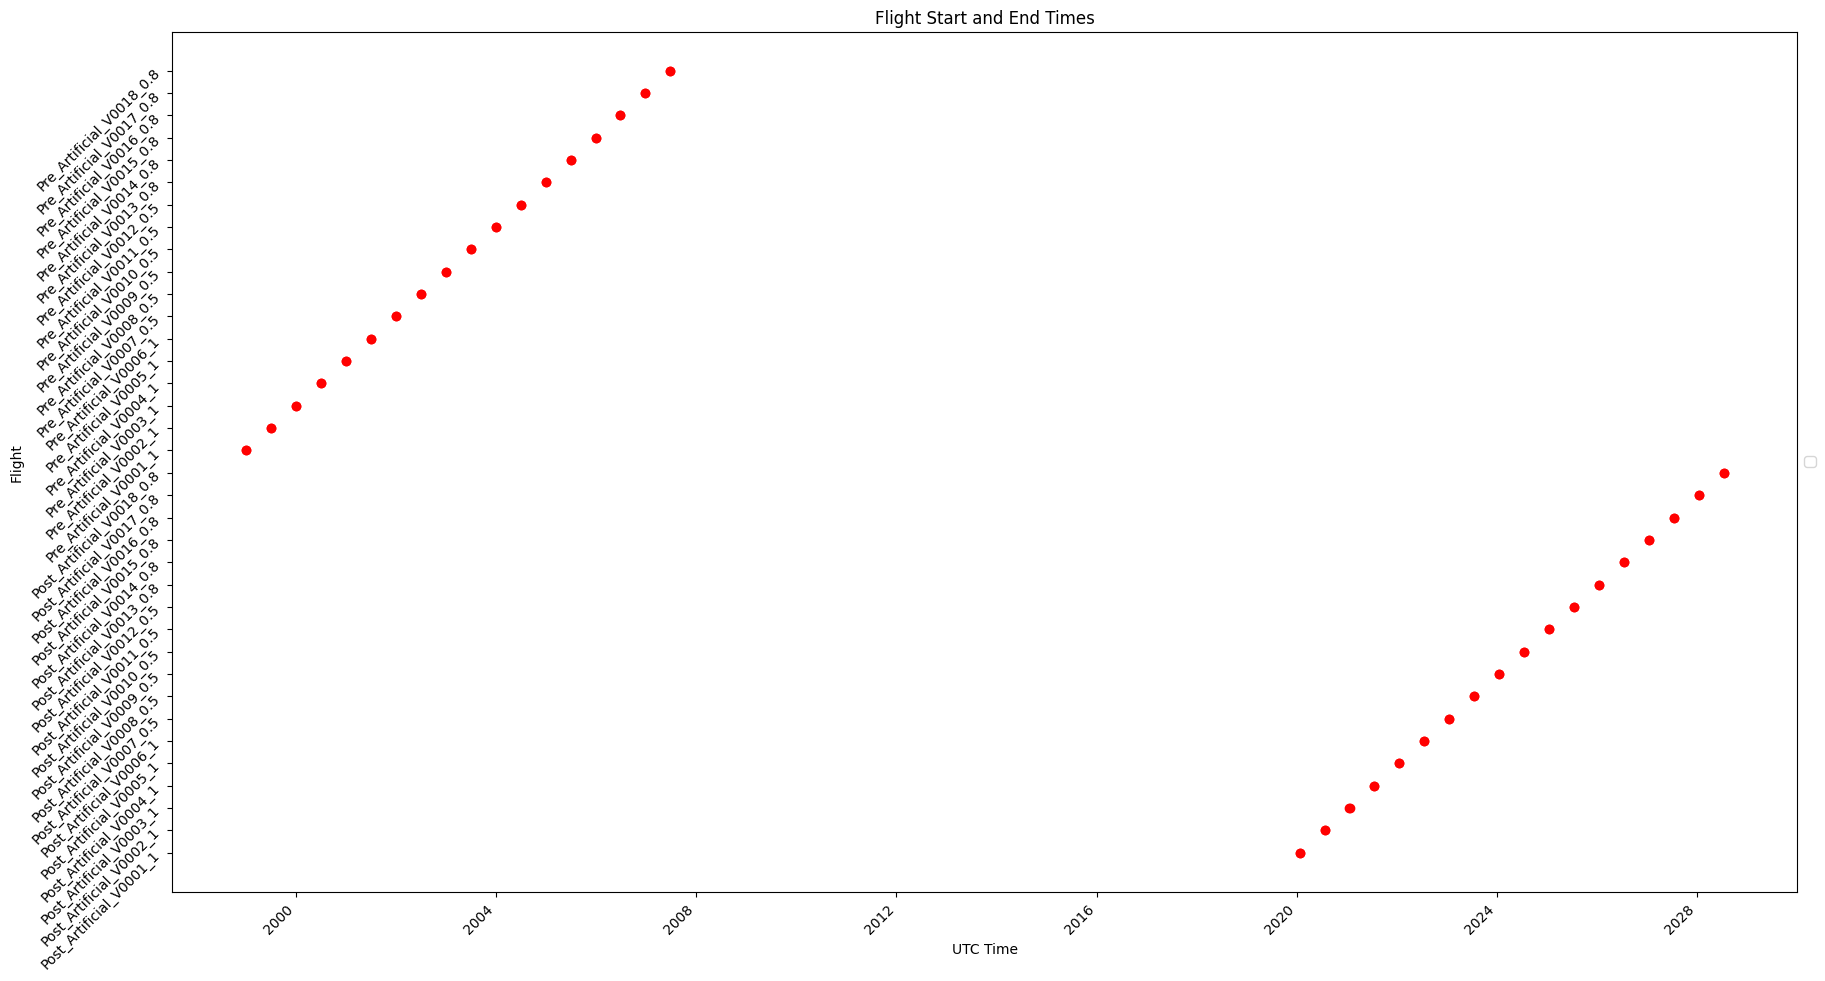

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


fig, ax = plt.subplots(figsize=(25, 10))

default_color = 'red'

flight_times = new_flights_with_leak_df.groupby('Flight')['UTC_TIME'].agg([min, max])

for flight, times in flight_times.iterrows():
    start, end = times['min'], times['max']

    ax.plot([start, end], [flight, flight], marker='o', linestyle='-', color=default_color)

ax.set_xlabel('UTC Time')
ax.set_ylabel('Flight')
ax.set_title('Flight Start and End Times')

# Improve the layout
plt.gcf().autofmt_xdate()
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')

plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.85)  # Adjust the right padding to make space for the legend

# Handling unique legend labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(dict.fromkeys(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


Introducing a **constant leakage rate** that subtracts a specific amount (`leakage_rate`) from `VALUE_FOB` (and also from `VALUE_FOB_SG`) at some random point in time during valid flight phases (**excluding phases 1 and 12**). This simulation of fuel leakage should, in theory, result in `VALUE_FOB` **decreasing at a constant rate from the point of leakage onset for the remainder of the flight.**

Given this setup, when you calculate `FOB_EST` (Estimated Fuel On Board) using the **initial** `VALUE_FOB` and subtracting the cumulative fuel used (`FUEL_USED_TOTAL_cumulative`), you should indeed observe that at some point after the leakage starts, `VALUE_FOB` becomes consistently** lower than **`FOB_EST`. This is because `FOB_EST `is based on the calculated cumulative fuel usage without accounting for the additional leakage, while `VALUE_FOB` is being directly decreased by the leakage rate, leading to a faster reduction in actual fuel onboard than estimated.

To visualize or confirm this effect, you would compare `VALUE_FOB` against `FOB_EST` over time for the flights where leakage was introduced. A plot showing both variables over time should reveal points where `VALUE_FOB` starts to deviate more significantly from `FOB_EST`, indicating the onset of leakage. This deviation would appear as `VALUE_FOB `trending downwards more sharply than `FOB_EST`, reflecting the unaccounted fuel loss due to leakage.

 visibility of this effect in your data and plots depends on:

- The magnitude of the leakage rate compared to typical fuel consumption rates.
- The timing of the leakage start point within the flight.
- The resolution and scale of your plots.
- If the leakage rate is relatively small compared to the overall fuel consumption or if it starts very late in the flight, the effect might be subtle.

In [ ]:
new_flights_with_leak_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338439 entries, 0 to 11373
Data columns (total 57 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   UTC_TIME                                         338439 non-null  datetime64[ns]
 1   MSN                                              338439 non-null  object        
 2   Flight                                           338439 non-null  object        
 3   FLIGHT_PHASE_COUNT                               338439 non-null  float64       
 4   FUEL_USED_1                                      338439 non-null  float64       
 5   FUEL_USED_2                                      338439 non-null  float64       
 6   FUEL_USED_3                                      338439 non-null  float64       
 7   FUEL_USED_4                                      338439 non-null  float64       
 8   VALUE_FOB                

In [ ]:
new_flights_with_leak_df.isnull().sum()

UTC_TIME                                                0
MSN                                                     0
Flight                                                  0
FLIGHT_PHASE_COUNT                                      0
FUEL_USED_1                                             0
FUEL_USED_2                                             0
FUEL_USED_3                                             0
FUEL_USED_4                                             0
VALUE_FOB                                               0
UTC_TIME_obj                                            0
DATE                                                    0
TIME                                                    0
FOB_change                                              0
VALUE_FOB_median_filtered_5                             0
VALUE_FOB_median_filtered_9                             0
VALUE_FOB_median_filtered_5_change                      0
VALUE_FOB_median_filtered_9_change                      0
Difference_VAL

In [ ]:

new_flights_with_leak_df['REAL_LEAK'] = new_flights_with_leak_df['REAL_LEAK'].fillna(0)


In [ ]:
new_flights_with_leak_df.isnull().sum()

UTC_TIME                                           0
MSN                                                0
Flight                                             0
FLIGHT_PHASE_COUNT                                 0
FUEL_USED_1                                        0
FUEL_USED_2                                        0
FUEL_USED_3                                        0
FUEL_USED_4                                        0
VALUE_FOB                                          0
UTC_TIME_obj                                       0
DATE                                               0
TIME                                               0
FOB_change                                         0
VALUE_FOB_median_filtered_5                        0
VALUE_FOB_median_filtered_9                        0
VALUE_FOB_median_filtered_5_change                 0
VALUE_FOB_median_filtered_9_change                 0
Difference_VALUE_FOB_vs_FOB_medianfiltered_5       0
Difference_VALUE_FOB_vs_FOB_medianfiltered_9  

In [ ]:
import matplotlib.pyplot as plt


for element in list(new_flights_with_leak_df["Flight"].unique()):
    relation_FOB_FUSED = new_flights_with_leak_df[new_flights_with_leak_df["Flight"] == element]


    start_time = relation_FOB_FUSED['UTC_TIME'].min()
    end_time = relation_FOB_FUSED['UTC_TIME'].max()
    flight_duration = (end_time - start_time).total_seconds() / 60.0  # Convert to minutes


    plt.figure(figsize=(10, 6))
    plt.plot(relation_FOB_FUSED.index, relation_FOB_FUSED['VALUE_FOB_SG'], label='FOB SG Value', marker='.', linestyle='-', markersize=3)
    plt.plot(relation_FOB_FUSED.index, relation_FOB_FUSED['FUEL_USED_TOTAL_gaussian_10'], label='TOTAL FUEL USED Gaussian 10 Value', marker='.', linestyle='-', markersize=3)
    plt.plot(relation_FOB_FUSED.index, relation_FOB_FUSED['FOB_EST_SG'], label='EST. FOB SG Value', marker='x', linestyle='--', markersize=3)


    plt.xlabel('Index')
    plt.ylabel('Fuel on Board [kg]')
    plt.title(f'FOB Value Comparison - Over Time for Flight {element}\nStart: {start_time}, End: {end_time}, Duration: {flight_duration:.2f} mins')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.



---


## 4.1 Concat MSN02 and Artificial Flights


---



In [ ]:
msn02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361384 entries, 2298 to 622953
Data columns (total 56 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   UTC_TIME                                         361384 non-null  datetime64[ns]
 1   MSN                                              361384 non-null  object        
 2   Flight                                           361384 non-null  object        
 3   FLIGHT_PHASE_COUNT                               361384 non-null  float64       
 4   FUEL_USED_1                                      361384 non-null  float64       
 5   FUEL_USED_2                                      361384 non-null  float64       
 6   FUEL_USED_3                                      361384 non-null  float64       
 7   FUEL_USED_4                                      361384 non-null  float64       
 8   VALUE_FOB            

In [ ]:
new_flights_with_leak_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338439 entries, 0 to 11373
Data columns (total 57 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   UTC_TIME                                         338439 non-null  datetime64[ns]
 1   MSN                                              338439 non-null  object        
 2   Flight                                           338439 non-null  object        
 3   FLIGHT_PHASE_COUNT                               338439 non-null  float64       
 4   FUEL_USED_1                                      338439 non-null  float64       
 5   FUEL_USED_2                                      338439 non-null  float64       
 6   FUEL_USED_3                                      338439 non-null  float64       
 7   FUEL_USED_4                                      338439 non-null  float64       
 8   VALUE_FOB                

In [ ]:
msn02["REAL_LEAK"]=0

In [ ]:
# List of specific columns you want to include
specific_columns = ['UTC_TIME', "MSN", 'Flight', "FLIGHT_PHASE_COUNT", 'VALUE_FOB_SG',  "FUEL_USED_TOTAL_gaussian_10", "FUEL_USED_TOTAL_cumulative_gaussian", 'FOB_EST_SG',"REAL_LEAK"]



# Select only the specific columns from msn02 DataFrame
msn02_selected_columns = msn02[specific_columns]

new_flights_selected_columns=new_flights_with_leak_df[specific_columns]

# Concatenate the selected columns from both DataFrames
final_df = pd.concat([msn02_selected_columns, new_flights_selected_columns], ignore_index=True)



In [ ]:
final_df.isnull().sum()

UTC_TIME                               0
MSN                                    0
Flight                                 0
FLIGHT_PHASE_COUNT                     0
VALUE_FOB_SG                           0
FUEL_USED_TOTAL_gaussian_10            0
FUEL_USED_TOTAL_cumulative_gaussian    0
FOB_EST_SG                             0
REAL_LEAK                              0
dtype: int64



---


# 5.Feature Engineering II


---



5. Now we creataed the Difference between estimated Fuel on Board and the measured Fuel on Board

$$
\text{DISCREPANCY} (t) =  \text{FOB_EST}(t) -  \text{VALUE_FOB} (t)
$$

 --> so if the estimated *Fuel on Board is higher then the actual FUEL on Board* the Error **should be positiv** - indicating a possible `LEAKAGE`, BUT we can only confirm this as leakage if the error is staying consistently positive and is growing linearly.


6. To understand the changes/growth of that error we also created an Leakage change

$$
\text{DISCREPANCY_change} (t) =  \text{DISCREPANCY}(t) -  \text{DISCREPANCY} (t-1)
$$

7. To understand the Lost Fuel up till point t in time we created  LEAKAGE_change_cumulative.

$$
\text{DISCREPANCY_change_cumulative} (t) =  \sum_{i=1}^{t} \text{DISCREPANCY_change} (t=i)
$$


8. For the model to understand the time passed since flight phase 8 started we created time elapsd.

$$
\text{TIME_ELAPSED} (t) =  \text{UTC_TIME} (t) - \text{UTC_TIME} (t=1)
$$

9. Binary column for Real Leak
$$
\text{REAL_LEAK}(t) =\begin{cases}
0, & \text{if time } t < \text{leakage start time} \\
1, & \text{if time } t \geq \text{leakage start time}
\end{cases}
$$

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699823 entries, 0 to 699822
Data columns (total 9 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   UTC_TIME                             699823 non-null  datetime64[ns]
 1   MSN                                  699823 non-null  object        
 2   Flight                               699823 non-null  object        
 3   FLIGHT_PHASE_COUNT                   699823 non-null  float64       
 4   VALUE_FOB_SG                         699823 non-null  float64       
 5   FUEL_USED_TOTAL_gaussian_10          699823 non-null  float64       
 6   FUEL_USED_TOTAL_cumulative_gaussian  699823 non-null  float64       
 7   FOB_EST_SG                           699823 non-null  float64       
 8   REAL_LEAK                            699823 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 48.1+ MB


In [ ]:
# Calculate LEAKAGE by subtracting VALUE_FOB from FOB_EST
final_df["LEAKAGE"] =final_df["FOB_EST_SG"] -final_df["VALUE_FOB_SG"]
final_df["LEAKAGE_change"]= final_df.groupby("Flight")["LEAKAGE"].diff().abs().fillna(0)

# Calculate LEAKAGE_smoothed by subtracting VALUE_FOB_smoothed from FOB_EST_smoothed
#final_df["LEAKAGE_smoothed"] = final_df["FOB_EST_smoothed"] -final_df["VALUE_FOB_smoothed"]
#final_df["LEAKAGE_smoothed_change"]= final_df.groupby("Flight")["LEAKAGE_smoothed"].diff().abs().fillna(0)

#final_df["LEAKAGE_median_filtered"] =final_df["FOB_EST_median_filtered"]- final_df["VALUE_FOB_median_filtered"]
#final_df["LEAKAGE_median_filtered_change"]= final_df.groupby("Flight")["LEAKAGE_median_filtered"].diff().abs().fillna(0)

final_df["LEAKAGE_change_cumulative"]=final_df.groupby("Flight")["LEAKAGE_change"].cumsum()

In [ ]:
final_df['TIME_ELAPSED'] = (final_df['UTC_TIME'] - final_df.groupby('Flight')['UTC_TIME'].transform('first')).dt.total_seconds()




---


## 5.1 Inspect


---



In [ ]:
# Calculate mean LEAKAGE and LEAKAGE_smoothed per flight
leakage_stats = final_df.groupby('Flight').agg({
    'LEAKAGE': ['mean', 'sum', 'median']
}).reset_index()

print(leakage_stats)

                       Flight      LEAKAGE                           
                                      mean           sum       median
0     Post_Artificial_V0001_1   735.545054  1.073234e+07   174.242585
1     Post_Artificial_V0002_1   991.554769  9.063802e+06   -51.569109
2     Post_Artificial_V0003_1  -348.688641 -5.893884e+06  -426.265231
3     Post_Artificial_V0004_1   772.628133  6.864028e+06   -15.777790
4     Post_Artificial_V0005_1  1757.326518  8.577511e+06  1503.615850
5     Post_Artificial_V0006_1   -12.518004 -1.440572e+05  -128.722544
6   Post_Artificial_V0007_0.5   374.241490  6.027908e+06   160.951948
7   Post_Artificial_V0008_0.5   234.323957  1.143735e+06   104.698049
8   Post_Artificial_V0009_0.5    90.607408  8.363064e+04    66.352371
9   Post_Artificial_V0010_0.5   106.800004  2.947680e+04   100.651557
10  Post_Artificial_V0011_0.5   601.707320  5.345568e+06    37.123128
11  Post_Artificial_V0012_0.5   -16.787597 -2.358490e+05  -206.151455
12  Post_Artificial_

In [ ]:
# Sum of LEAKAGE per flight
leakage_sum_per_flight = final_df.groupby('Flight')['LEAKAGE'].sum().reset_index(name='LEAKAGE_sum')

# Sum of LEAKAGE_smoothed per flight
#leakage_smoothed_sum_per_flight = final_df.groupby('Flight')['LEAKAGE_smoothed'].sum().reset_index(name='LEAKAGE_smoothed_sum')

# Sum of LEAKAGE_smoothed per flight
#leakage_median_filtered_sum_per_flight = final_df.groupby('Flight')['LEAKAGE_median_filtered'].sum().reset_index(name='LEAKAGE_median_filtered_sum')

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699823 entries, 0 to 699822
Data columns (total 13 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   UTC_TIME                             699823 non-null  datetime64[ns]
 1   MSN                                  699823 non-null  object        
 2   Flight                               699823 non-null  object        
 3   FLIGHT_PHASE_COUNT                   699823 non-null  float64       
 4   VALUE_FOB_SG                         699823 non-null  float64       
 5   FUEL_USED_TOTAL_gaussian_10          699823 non-null  float64       
 6   FUEL_USED_TOTAL_cumulative_gaussian  699823 non-null  float64       
 7   FOB_EST_SG                           699823 non-null  float64       
 8   REAL_LEAK                            699823 non-null  float64       
 9   LEAKAGE                              699823 non-null  float64       
 

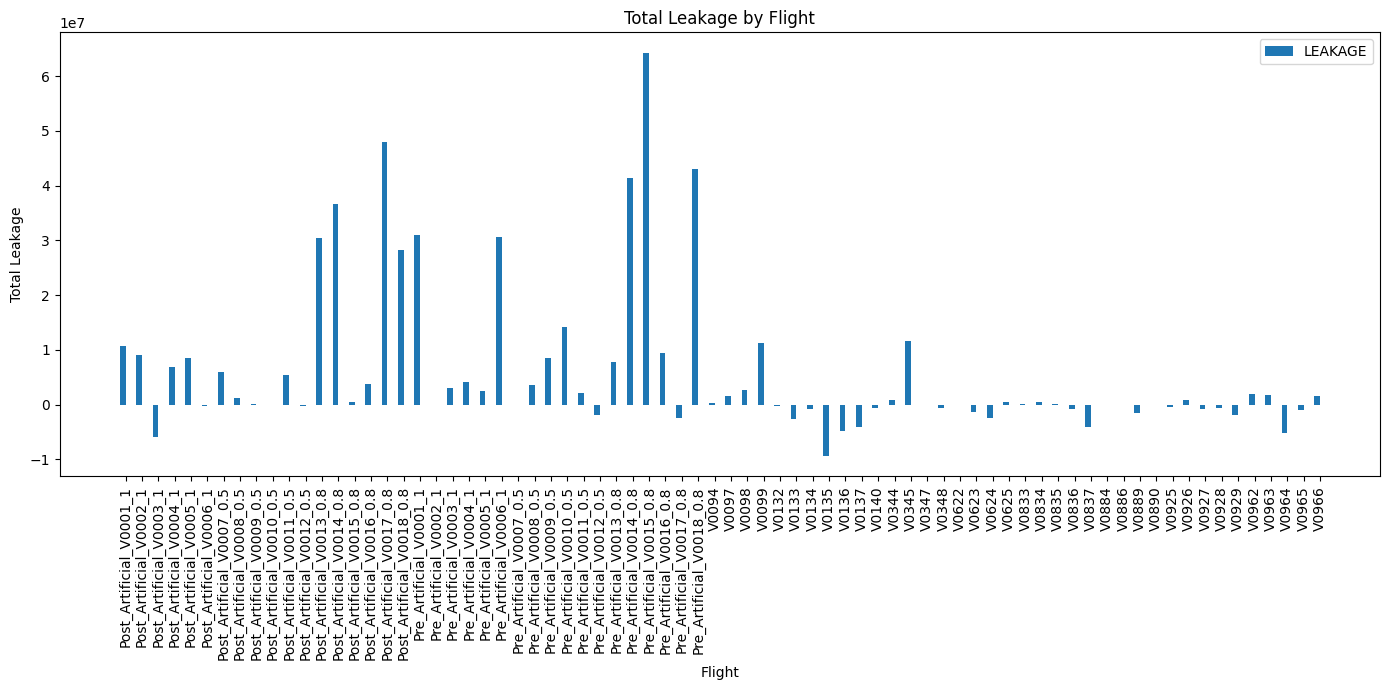

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(14, 7))


n_flights = len(leakage_sum_per_flight['Flight'])

ind = np.arange(n_flights)

width = 0.35


plt.bar(ind - width/2, leakage_sum_per_flight['LEAKAGE_sum'], width, label='LEAKAGE')


plt.xlabel('Flight')
plt.ylabel('Total Leakage')
plt.title('Total Leakage by Flight')


plt.xticks(ind, leakage_sum_per_flight['Flight'], rotation='vertical')

plt.legend()

plt.tight_layout()

plt.show()


In [ ]:
final_df.shape

(699823, 13)

In [ ]:
final_df.to_csv('/content/drive/My Drive/IE/CORPORATE_PROJECT_AIRBUS/01_DATA/PREPROS/preprocessed_msn02_with_leakage.csv', index=False)

In [30]:
# Define the path in your Google Drive where you want to save the file
file_path = '/content/drive/My Drive/filtered_flight_data.csv'

# Save the DataFrame to a CSV file in the specified path
filtered_df.to_csv(file_path, index=False)

# Print a confirmation message
print(f'File saved to {file_path}')


File saved to /content/drive/My Drive/filtered_flight_data.csv


In [ ]:
FOB_EST_SG

In [ ]:
FUEL_USED_TOTAL_cumulative_gaussianVALUE_FOB_SG

In [12]:
filtered_df.head()

,UTC_TIME,MSN,Flight,FLIGHT_PHASE_COUNT,VALUE_FOB_SG,FUEL_USED_TOTAL_gaussian_10,FUEL_USED_TOTAL_cumulative_gaussian,FOB_EST_SG,REAL_LEAK,LEAKAGE,LEAKAGE_change,LEAKAGE_change_cumulative,TIME_ELAPSED
426021,2003-07-01 00:00:00,A400M-0002,Pre_Artificial_V0010_0.5,8.0,27516.579741,396.327237,2.219681,27514.359843,0.0,-2.219898,0.000000,0.000000,0.0
426022,2003-07-01 00:00:01,A400M-0002,Pre_Artificial_V0010_0.5,8.0,27510.322250,398.536586,4.429030,27512.151472,0.0,1.829222,4.049120,4.049120,1.0
426023,2003-07-01 00:00:02,A400M-0002,Pre_Artificial_V0010_0.5,8.0,27504.437315,400.735476,6.627920,27509.954892,0.0,5.517577,3.688355,7.737475,2.0
426024,2003-07-01 00:00:03,A400M-0002,Pre_Artificial_V0010_0.5,8.0,27498.848966,402.923880,8.816324,27507.766939,0.0,8.917973,3.400396,11.137872,3.0
426025,2003-07-01 00:00:04,A400M-0002,Pre_Artificial_V0010_0.5,8.0,27493.203244,405.101870,10.994314,27505.590045,0.0,12.386801,3.468828,14.606700,4.0




---


# 6.Anomaly Detection


---



LSTM Architecture for Anomaly Detection

An LSTM (Long Short-Term Memory) model is well-suited for detecting anomalies in time-series data due to its ability to capture long-term dependencies and patterns. The model architecture consists of:

- **Input Layer**: Corresponding to the number of features in the dataset.
- **LSTM Layers**: Can have one or more LSTM layers. The number of units (neurons) in these layers defines the model's capacity to learn from data.
- **Output Layer**: Typically a single neuron with a sigmoid activation function for binary classification tasks.



---


## 6.1 Load prepocessed trainig data


---



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
final_df =pd.read_csv('/content/drive/My Drive/IE/CORPORATE_PROJECT_AIRBUS/01_DATA/PREPROS/preprocessed_msn02_with_leakage.csv')

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699823 entries, 0 to 699822
Data columns (total 13 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UTC_TIME                             699823 non-null  object 
 1   MSN                                  699823 non-null  object 
 2   Flight                               699823 non-null  object 
 3   FLIGHT_PHASE_COUNT                   699823 non-null  float64
 4   VALUE_FOB_SG                         699823 non-null  float64
 5   FUEL_USED_TOTAL_gaussian_10          699823 non-null  float64
 6   FUEL_USED_TOTAL_cumulative_gaussian  699823 non-null  float64
 7   FOB_EST_SG                           699823 non-null  float64
 8   REAL_LEAK                            699823 non-null  float64
 9   LEAKAGE                              699823 non-null  float64
 10  LEAKAGE_change                       699823 non-null  float64
 11  LEAKAGE_chang

In [ ]:
final_df['UTC_TIME_obj']= final_df["UTC_TIME"].copy()
final_df['UTC_TIME'] = pd.to_datetime(final_df['UTC_TIME'])

In [ ]:
#final_df = final_df.sort_values('UTC_TIME')

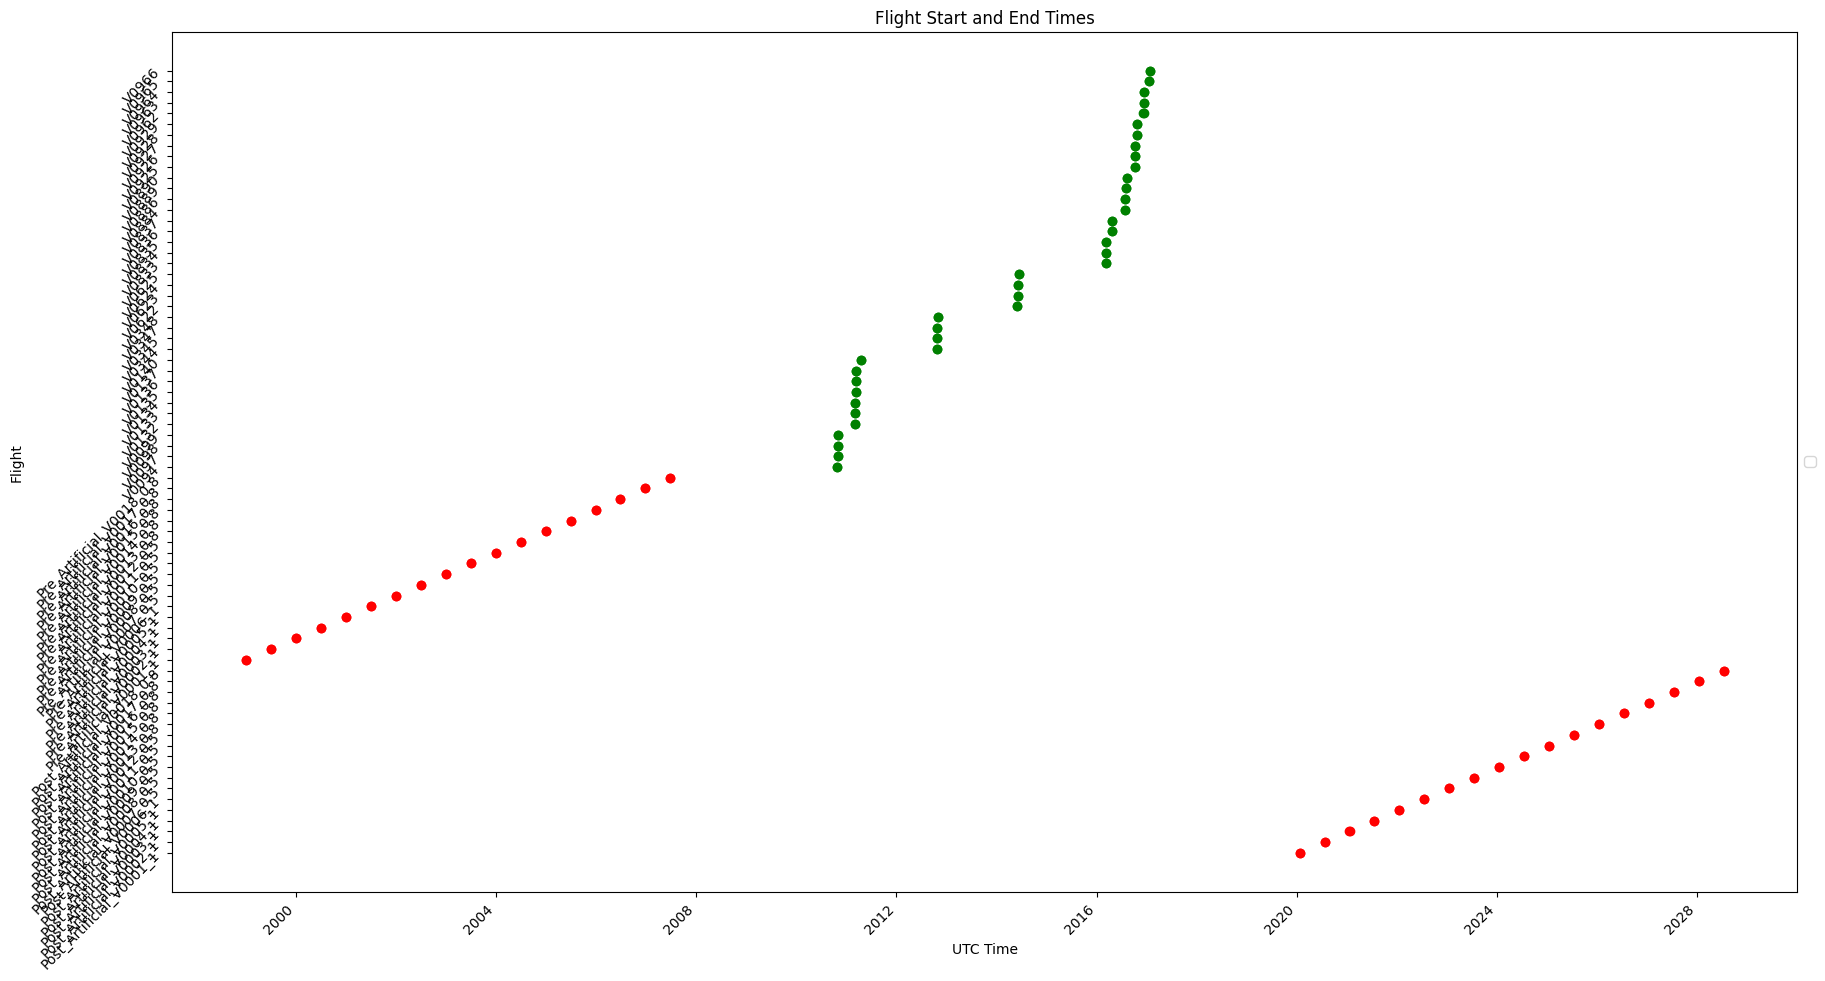

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


flight_times = final_df.groupby('Flight')['UTC_TIME'].agg([min, max])

fig, ax = plt.subplots(figsize=(25, 10))

color_for_a_flights = 'red'  # Color for flights with artificial leak
default_color = 'green'  # Default color for other normal flights

for flight, times in flight_times.iterrows():
    start, end = times['min'], times['max']
    color = color_for_a_flights if flight.startswith('P') else default_color
    ax.plot([start, end], [flight, flight], marker='o', linestyle='-', color=color)

ax.set_xlabel('UTC Time')
ax.set_ylabel('Flight')
ax.set_title('Flight Start and End Times')

# Improve the layout
plt.gcf().autofmt_xdate()
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')

plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.85)  # Adjust the right padding to make space for the legend

# Handling unique legend labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(dict.fromkeys(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()




---


## 6.2 Baseline Model


---



Model Architecture - "Simple_First_Try"

The "Simple_First_Try" model is designed with a focus on simplicity and efficiency, constructed using the Sequential API to linearly stack the LSTM and Dense layers. Here's a breakdown of the model components and choices:

LSTM Layer

- The LSTM (Long Short-Term Memory) layer with 64 units is chosen for its ability to capture long-term dependencies in time-series data, which is crucial for understanding patterns over time in our fuel consumption dataset. It's the first layer after the input, configured to process sequences of data with a length defined by `sequence_length` and a feature dimensionality given by `len(features)`.

Dense Layer

- Following the LSTM, we have a Dense layer with a single unit, which serves as the output layer for binary classification. The use of a single neuron reflects our task's binary nature: detecting the presence or absence of anomalies in the data.

Activation Function
- The `sigmoid` activation function in the output layer is apt for binary classification problems. It squashes the output to a range between 0 and 1, which we can interpret as the probability of the input belonging to the positive class.

Compilation Parameters

- **Optimizer**: We use `adam`, a popular optimizer that combines the benefits of two other extensions of stochastic gradient descent: Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp). Adam is computationally efficient, has little memory requirements, and is well-suited for problems with large datasets and parameters or when the input data is noisy.
- **Loss Function**: For binary classification, `binary_crossentropy` is an appropriate loss function as it measures the "distance" between the distribution of the predictions and the true labels. It is well-suited for probabilities outputs in binary classification tasks.
- **Metrics**: We monitor `accuracy` as it provides a straightforward interpretation of the model's performance - the fraction of predictions our model got right.

Summary

This architecture, selected for its simplicity and suitability for binary classification tasks, will serve as our baseline. Its performance on the fuel consumption dataset will help us understand the need for potentially more complex models or further feature engineering.



In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699823 entries, 0 to 699822
Data columns (total 14 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   UTC_TIME                             699823 non-null  datetime64[ns]
 1   MSN                                  699823 non-null  object        
 2   Flight                               699823 non-null  object        
 3   FLIGHT_PHASE_COUNT                   699823 non-null  float64       
 4   VALUE_FOB_SG                         699823 non-null  float64       
 5   FUEL_USED_TOTAL_gaussian_10          699823 non-null  float64       
 6   FUEL_USED_TOTAL_cumulative_gaussian  699823 non-null  float64       
 7   FOB_EST_SG                           699823 non-null  float64       
 8   REAL_LEAK                            699823 non-null  float64       
 9   LEAKAGE                              699823 non-null  float64       
 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import Sequence


features = [ "LEAKAGE","LEAKAGE_change",'LEAKAGE_change_cumulative',  'TIME_ELAPSED']  # Add other relevant features here
target = 'REAL_LEAK'

# Define sequence length (e.g., 60 seconds)
sequence_length = 60

# Add 'Has_Leak' column to final_df
final_df['Has_Leak'] = final_df.groupby('Flight')[target].transform('max')

# Sort flights with leakages by their minimum UTC time
flights_with_leak_sorted = final_df[final_df['Has_Leak'] == 1].groupby('Flight')['UTC_TIME'].min().sort_values().index

# Sort flights without leakages by their minimum UTC time
flights_without_leak_sorted = final_df[final_df['Has_Leak'] == 0].groupby('Flight')['UTC_TIME'].min().sort_values().index

# Split flights into training and validation sets, ensuring the earlier flights are in the training set
train_flights_with_leak, val_flights_with_leak = train_test_split(flights_with_leak_sorted, test_size=0.3, shuffle=False)
train_flights_without_leak, val_flights_without_leak = train_test_split(flights_without_leak_sorted, test_size=0.3, shuffle=False)

# Combine the training flights and validation flights back
train_data = final_df[final_df['Flight'].isin(train_flights_with_leak) | final_df['Flight'].isin(train_flights_without_leak)]
val_data = final_df[final_df['Flight'].isin(val_flights_with_leak) | final_df['Flight'].isin(val_flights_without_leak)]

class DataGenerator(Sequence):
    def __init__(self, data, target, sequence_length, batch_size=64):
        self.data = data
        self.target = target
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.indexes = np.arange(len(data) - sequence_length)  # Updated indexes

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        X = np.empty((self.batch_size, self.sequence_length, len(features)))
        y = np.empty(self.batch_size)
        for i, idx in enumerate(indexes):
            sequence_idx = np.arange(idx, idx + self.sequence_length)  # Generate sequence indexes
            X[i, :, :] = self.data.iloc[sequence_idx][features].values  # Use sequence indexes to extract features
            y[i] = self.data.iloc[idx + self.sequence_length][target]
        return X, y

# Create data generators
train_generator = DataGenerator(train_data, target, sequence_length)
val_generator = DataGenerator(val_data, target, sequence_length)

# Build LSTM model
model = Sequential(name="Simple_First_Try")
model.add(LSTM(64, input_shape=(sequence_length, len(features))))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Train model with data generators
history = model.fit(train_generator, epochs=5, validation_data=val_generator)

# Evaluate model
val_loss, val_accuracy = model.evaluate(val_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


Model: "Simple_First_Try"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17664     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 17729 (69.25 KB)
Trainable params: 17729 (69.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
6869/6869 [==============================] - 1171s 170ms/step - loss: 0.3011 - accuracy: 0.8748 - val_loss: 0.1692 - val_accuracy: 0.9674
Epoch 2/5
6869/6869 [==============================] - 1159s 169ms/step - loss: 0.2361 - accuracy: 0.9127 - val_loss: 0.1125 - val_accuracy: 0.9715
Epoch 3/5
6869/6869 [==============================] - 1114s 162ms/step - loss: 0.2186 - accuracy: 0.9251 - val_lo

In [ ]:
import pickle
history_dict = history.history
# Save history to Pickle
with open('/content/drive/MyDrive/IE/CORPORATE_PROJECT_AIRBUS/03_MODELS/lstm_model_simple_history.pkl', 'wb') as file:
    pickle.dump(history_dict, file)

In [ ]:
model.save('/content/drive/MyDrive/IE/CORPORATE_PROJECT_AIRBUS/03_MODELS/lstm_simple_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


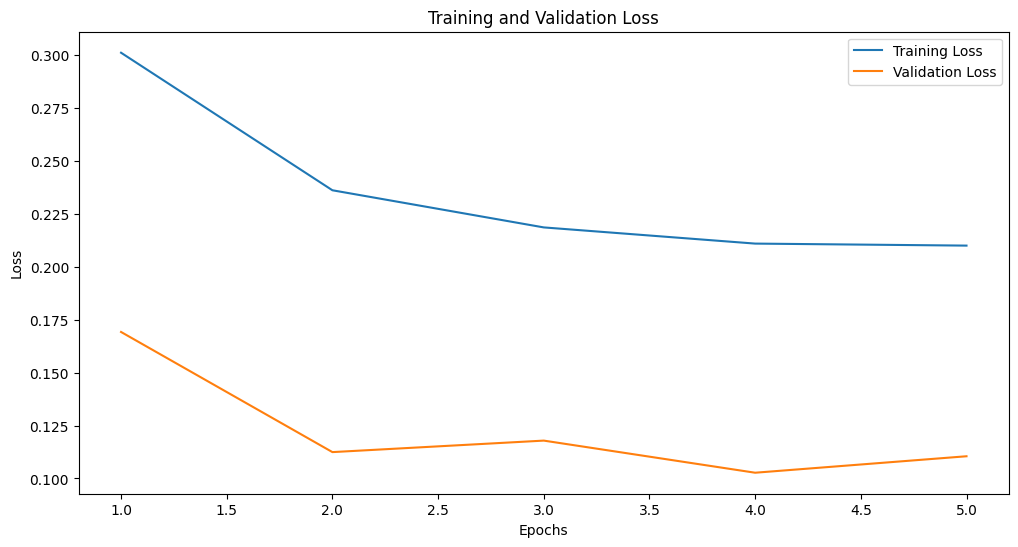

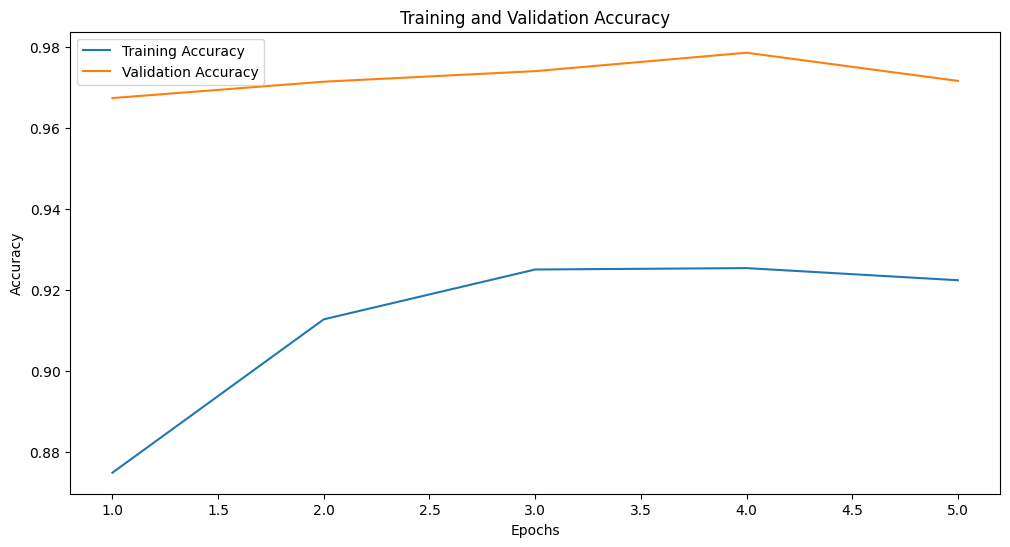

In [ ]:
import matplotlib.pyplot as plt

# Get the training and validation loss
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Get the training and validation accuracy
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



---


### 6.2.1 Test Model on other MSN's


---



In [ ]:
test = pd.read_csv('/content/drive/My Drive/IE/CORPORATE_PROJECT_AIRBUS/01_DATA/msn_test_df.csv')
test.describe()

,FUEL_USED_2,FUEL_USED_3,FUEL_USED_4,VALUE_FOB,FLIGHT_PHASE_COUNT,FUEL_USED_1,Flight,FOB_change,FUEL_USED_1_smoothed_10,FUEL_USED_2_smoothed_10,FUEL_USED_3_smoothed_10,FUEL_USED_4_smoothed_10,VALUE_FOB_SG,Difference_VALUE_FOB_vs_FOB_SG,FUEL_USED_TOTAL,FUEL_USED_TOTAL_smoothed,FUEL_USED_TOTAL_change,FUEL_USED_TOTAL_change_smoothed,Time_diff_seconds,FUEL_USED_TOTAL_cumulative,FUEL_USED_TOTAL_cumulative_smoothed,VALUE_FOB_SG_first,FOB_EST_SG,LEAKAGE,LEAKAGE_change,LEAKAGE_change_cumulative,REAL_LEAKAGE
count,179231.000000,179231.000000,179231.000000,179231.000000,179231.0,179231.000000,179231.000000,179231.000000,1.792310e+05,1.792310e+05,1.792310e+05,1.792310e+05,1.792310e+05,179231.000000,179231.000000,1.792310e+05,179231.000000,179231.000000,1.792310e+05,179231.000000,1.792310e+05,179231.000000,1.792310e+05,179231.000000,1.792310e+05,1.792310e+05,179231.0
mean,3305.107275,3320.785964,3337.188740,21783.277262,8.0,3356.408619,478.380425,-16.348545,-3.171517e-16,3.678960e-16,-2.410353e-16,2.613330e-16,-1.528671e-16,31.593010,13319.490598,2.384981e-16,5.126449,13.249923,8.970288e+02,4245.121134,-7.611641e-18,28207.485538,5.252032e-16,0.000000,4.186403e-17,1.192490e-16,0.0
std,1497.128845,1505.547125,1516.162065,6262.982899,0.0,1511.569652,413.848039,396.814009,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,694.783137,6027.814504,1.000003e+00,240.400474,211.742780,2.207086e+05,5262.791896,1.000003e+00,6165.811475,1.000003e+00,1.000003,1.000003e+00,1.000003e+00,0.0
min,1500.011841,1500.161011,1500.000854,5903.000000,8.0,1500.040527,9.000000,-27539.000000,-1.671680e+00,-1.659994e+00,-1.660290e+00,-1.651332e+00,-2.852614e+00,-13398.680831,6019.664673,-1.661567e+00,-22041.813965,-25701.388615,-2.254844e+07,-13438.668945,-2.534621e+00,10415.387325,-3.573573e+00,-6.563010,-9.475818e-02,-1.084394e+00,0.0
25%,2180.204468,2189.302246,2188.955566,16806.000000,8.0,2211.903442,347.000000,-3.000000,-7.564454e-01,-7.527635e-01,-7.535461e-01,-7.580361e-01,-7.922178e-01,-3.420372,8769.729248,-7.556802e-01,1.154053,1.254732,1.000000e+00,295.549438,-7.052174e-01,23197.665293,-6.754534e-01,-0.331707,-9.346912e-02,-6.107255e-01,0.0
50%,2914.104248,2929.355225,2941.629150,21547.000000,8.0,2960.530518,395.000000,-1.000000,-2.600197e-01,-2.601934e-01,-2.591182e-01,-2.597481e-01,-3.854018e-02,-0.001178,11753.560059,-2.591811e-01,1.265625,1.356301,1.000000e+00,2757.484497,-2.671974e-01,28360.548529,4.152540e-02,0.338994,-9.150610e-02,-3.575236e-01,0.0
75%,4071.707520,4084.409058,4127.934326,26097.000000,8.0,4145.365479,448.000000,0.000000,5.253830e-01,5.144337e-01,5.099259e-01,5.229306e-01,6.861831e-01,3.427994,16456.472046,5.217073e-01,1.361816,2.188159,1.000000e+00,6667.349792,4.817660e-01,32242.077510,7.168392e-01,0.610409,-8.518074e-02,2.970909e-01,0.0
max,8786.003906,8783.727539,9014.974609,39596.000000,8.0,9069.362305,2198.000000,4561.000000,3.876984e+00,3.757462e+00,3.724987e+00,3.843068e+00,3.126909e+00,15900.073093,35654.068359,3.802548e+00,20789.116943,9679.059505,2.886743e+07,29558.700928,4.331100e+00,41365.535459,2.613591e+00,4.327784,1.432101e+02,7.560884e+00,0.0


In [ ]:
# Load complete new data
test = pd.read_csv('/content/drive/My Drive/IE/CORPORATE_PROJECT_AIRBUS/01_DATA/msn_test_df.csv')
test['UTC_TIME'] = pd.to_datetime(test['UTC_TIME'])
test['TIME_ELAPSED'] = (test['UTC_TIME'] - test.groupby('Flight')['UTC_TIME'].transform('first')).dt.total_seconds()
test["REAL_LEAK"]=test["REAL_LEAKAGE"]
from sklearn.metrics import confusion_matrix
# Generate sequences from the test data
test_generator = DataGenerator(test, target, sequence_length)

# Make predictions using the trained model on the test set
y_test_pred = model.predict(test_generator)
y_test_pred_classes = (y_test_pred > 0.5).astype(int)

# Get true labels for the test set
y_test_true = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]
    y_test_true.extend(labels)

# Compute confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test_true, y_test_pred_classes)

# Visualize confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()


2799/2799 [==============================] - 272s 97ms/step


NameError: name 'confusion_matrix' is not defined

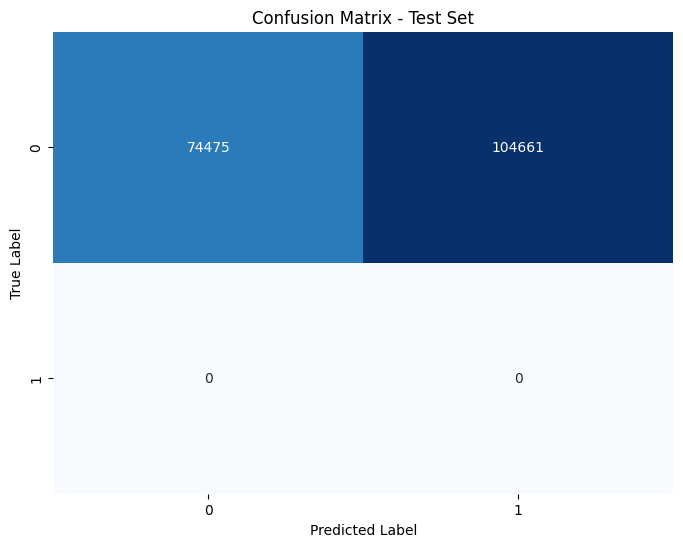

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Compute confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test_true, y_test_pred_classes)

# Visualize confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()


In [ ]:
# Calculate True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN)
TP = conf_matrix_test[1, 1]
TN = conf_matrix_test[0, 0]
FP = conf_matrix_test[0, 1]
FN = conf_matrix_test[1, 0]

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Calculate precision
precision = TP / (TP + FP)

# Calculate recall (sensitivity)
recall = TP / (TP + FN)

# Calculate specificity
specificity = TN / (TN + FP)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)


<ipython-input-16-18c6e9688db6>:14: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP / (TP + FN)


In [ ]:
print(accuracy)
print(precision)
print(recall)
print(f1_score)

0.41574557877813506
0.0
nan
nan




---


### 6.2.3 Evaluation


---





Model Evaluation - "Simple_First_Try"

**Architecture Summary**

Our baseline model, named "Simple_First_Try", was implemented with a minimalistic design to establish a performance benchmark. The architecture comprises a single LSTM layer with 64 units, followed by a densely connected output layer with a single unit for binary classification. The simplicity of this model is reflected in its parameter count, totaling 17,729, which allows for rapid training and inference.

**Training Summary**

The model was trained over 5 epochs, showing an initial training accuracy of 87.48% which improved to 92.24% by the final epoch. However, the validation accuracy displayed a more nuanced trend, starting at 96.74% and peaking at 97.86% in the fourth epoch before slightly declining to 97.17% in the final epoch.

**Validation Performance**

Upon evaluation, the model achieved a validation accuracy of 97.17% with a loss of 0.1105. This indicates a high level of performance on the validation set, suggesting that the model is capable of capturing the underlying patterns within the data with a reasonable level of generalization.

**Loss and Accuracy Trends**

The above chart illustrates the training and validation accuracy across epochs. The model demonstrates stable convergence, with validation accuracy consistently surpassing training accuracy, indicating a robust generalization on unseen data.

**Confusion Matrix**

The confusion matrix for the test set showcases the model's prediction capabilities, with a high number of true positives and true negatives, and notably zero false negatives and false positives. This result is indicative of the model's strong discriminative power in this particular testing scenario.


**Overfitting Detected**

The trained model shows signs of overfitting as evidenced by the significant difference between the training and validation accuracies. During training, the model achieved a high accuracy on the training data, but this accuracy did not generalize well to unseen validation data. This discrepancy suggests that the model may have memorized the training data instead of learning meaningful patterns.

**Performance on Unbalanced New Data**

When the trained model was applied to unbalanced new data, where more than half of the instances were misclassified, it highlighted a potential limitation of the model's generalization capability. Despite achieving reasonable performance on the training and validation sets, the model struggled to classify instances accurately in real-world scenarios with imbalanced classes.

**Conclusion**

The presence of overfitting and the model's suboptimal performance on unbalanced new data underscore the importance of further model refinement and evaluation. Strategies such as regularization techniques, data augmentation, or exploring alternative model architectures may help mitigate overfitting and improve the model's robustness to imbalanced data distributions.



---


## 6.3 Best Model


---






Model Architecture - "Advanced_Analysis_Model"

The "Advanced_Analysis_Model" showcases a refined approach to sequence modeling, addressing the complex nature of time-series anomaly detection within our fuel consumption data. Constructed using a sequential layering in the Keras framework, the model's architecture is designed to identify subtle patterns indicative of fuel leaks.

 LSTM Layers

- **First LSTM Layer**: The initial LSTM layer has 50 units and is responsible for processing the input sequences. Each sequence spans 150 time steps, providing the model with ample temporal context to detect anomalies.
- **Second LSTM Layer**: A subsequent LSTM layer, also with 50 units, further processes the information. This layer is designed to condense the temporal information into a dense representation.

 Dropout Regularization

- **Dropout Layers**: To combat overfitting, dropout layers with a rate of 0.2 are introduced after each LSTM layer. These layers randomly deactivate a portion of the neurons during training, forcing the network to learn more robust features that aren't dependent on specific weights.

Output Layer

- **Dense Output Layer**: The architecture concludes with a single-unit dense layer, employing a `sigmoid` activation function to deliver a binary output that indicates the likelihood of a leakage event.

Compilation Parameters

- **Optimizer**: Adam optimizer, known for its effectiveness and efficiency in training neural networks.
- **Loss Function**: Binary cross-entropy loss function, chosen for its suitability in binary classification tasks.
- **Metrics**: Accuracy metric, providing a clear indication of the model's performance in predicting the correct class labels.

Summary

Our "Advanced_Analysis_Model" represents a significant step forward in our modeling capabilities, embodying a more nuanced and sophisticated approach to the challenge of anomaly detection in aviation fuel systems. Its design is a testament to our commitment to leveraging deep learning techniques to improve the safety and reliability of flight operations.



In [ ]:
final_df =pd.read_csv('/content/drive/My Drive/IE/CORPORATE_PROJECT_AIRBUS/01_DATA/PREPROS/preprocessed_msn02_with_leakage.csv')
final_df['UTC_TIME_obj']= final_df["UTC_TIME"].copy()
final_df['UTC_TIME'] = pd.to_datetime(final_df['UTC_TIME'])

In [ ]:
scaler = StandardScaler()
final_df[feature_columns] = scaler.fit_transform(final_df[feature_columns])

here we are using the final_df with the different artificial leak ingestion strategy

In [ ]:
# Add a helper column to identify flights with any leakage
final_df['Has_Leak'] = final_df.groupby('Flight')['REAL_LEAK'].transform('max')

# Separate flights with and without leaks
flights_with_leak = final_df[final_df['Has_Leak'] == 1]['Flight'].unique()
flights_without_leak = final_df[final_df['Has_Leak'] == 0]['Flight'].unique()

from sklearn.model_selection import train_test_split

# Split flights into training and validation sets
train_flights_with_leak, val_flights_with_leak = train_test_split(flights_with_leak, test_size=0.2, random_state=42)
train_flights_without_leak, val_flights_without_leak = train_test_split(flights_without_leak, test_size=0.2, random_state=42)

# Combine the training flights and validation flights back
train_flights = np.concatenate([train_flights_with_leak, train_flights_without_leak])
val_flights = np.concatenate([val_flights_with_leak, val_flights_without_leak])

# Create training and validation DataFrames
train_df = final_df[final_df['Flight'].isin(train_flights)]
val_df =final_df[final_df['Flight'].isin(val_flights)]

# Verify the split
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# Check the proportion of leak to non-leak flights in each set
print("Training set leaks:", train_df['REAL_LEAK'].sum() / len(train_df))
print("Validation set leaks:", val_df['REAL_LEAK'].sum() / len(val_df))

import tensorflow as tf

Training set size: 552028
Validation set size: 147795
Training set leaks: 0.2200196366850957
Validation set leaks: 0.3128725599648161


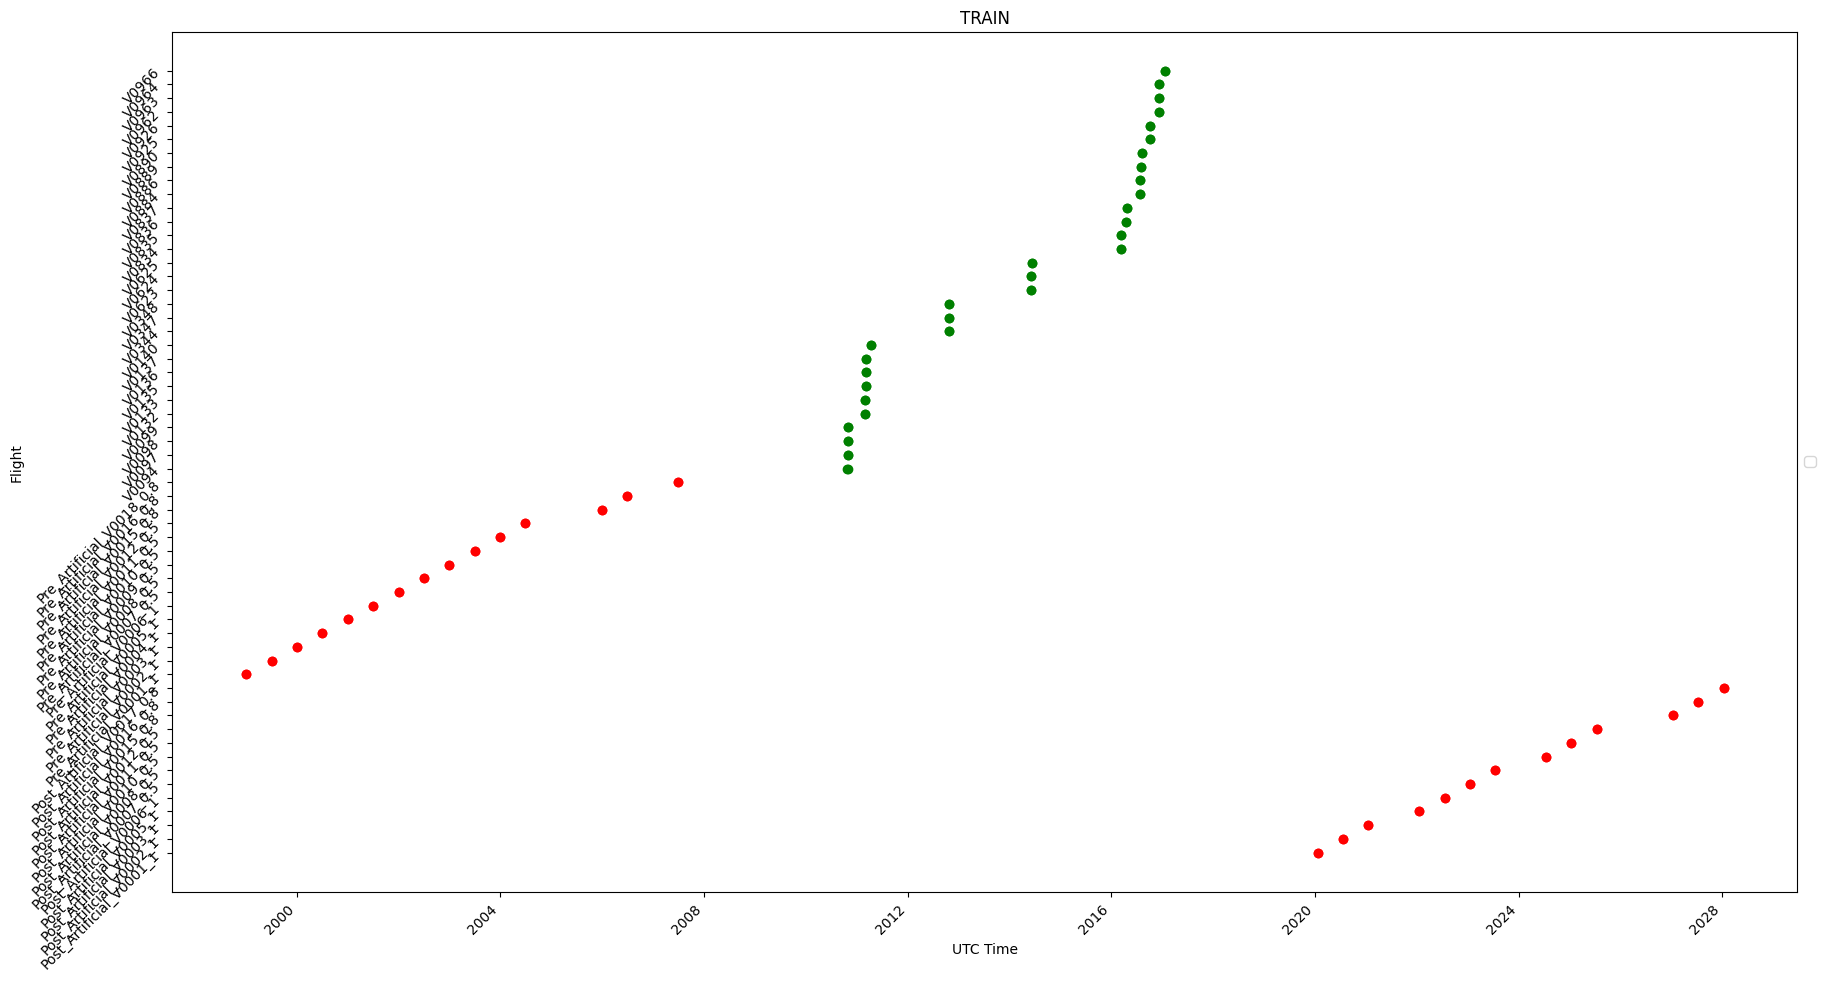

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


flight_times = train_df.groupby('Flight')['UTC_TIME'].agg([min, max])

fig, ax = plt.subplots(figsize=(25, 10))

color_for_a_flights = 'red'  # Color for flights with artificial leak
default_color = 'green'  # Default color for other normal flights

for flight, times in flight_times.iterrows():
    start, end = times['min'], times['max']
    color = color_for_a_flights if flight.startswith('P') else default_color
    ax.plot([start, end], [flight, flight], marker='o', linestyle='-', color=color)

ax.set_xlabel('UTC Time')
ax.set_ylabel('Flight')
ax.set_title('TRAIN')

# Improve the layout
plt.gcf().autofmt_xdate()
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')

plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.85)  # Adjust the right padding to make space for the legend

# Handling unique legend labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(dict.fromkeys(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

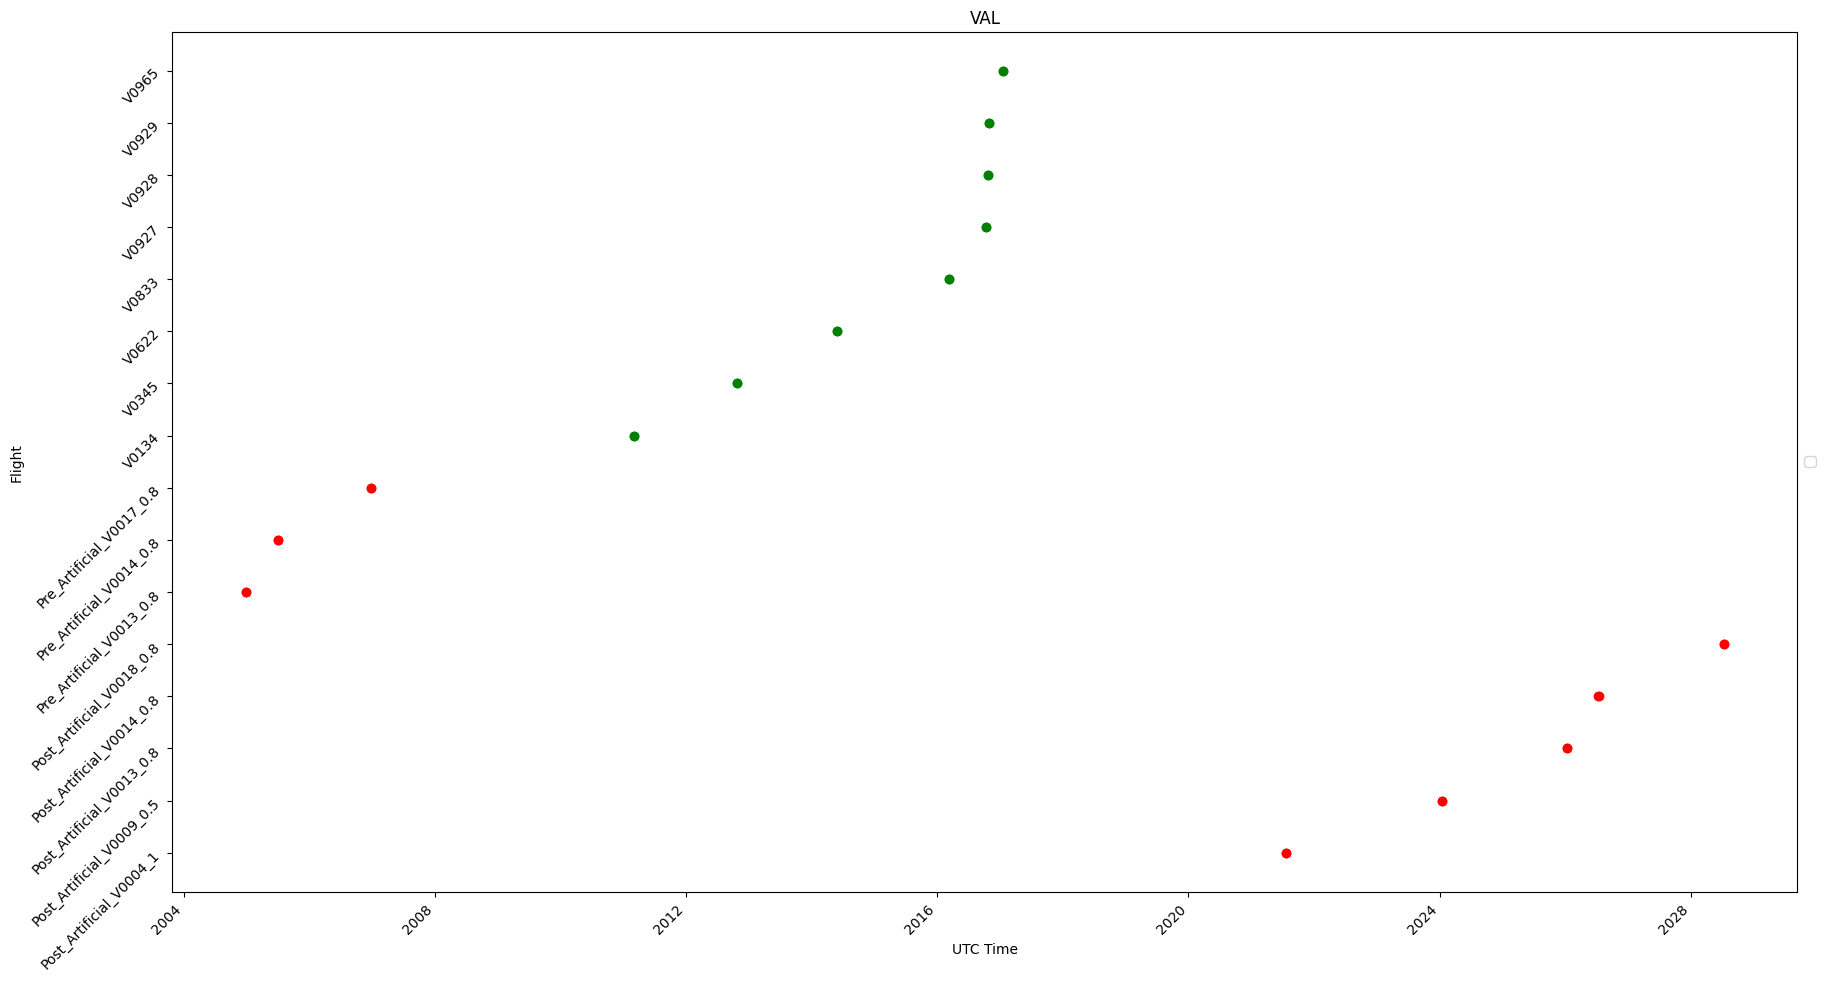

In [ ]:
flight_times = val_df.groupby('Flight')['UTC_TIME'].agg([min, max])

fig, ax = plt.subplots(figsize=(25, 10))

color_for_a_flights = 'red'  # Color for flights with artificial leak
default_color = 'green'  # Default color for other normal flights

for flight, times in flight_times.iterrows():
    start, end = times['min'], times['max']
    color = color_for_a_flights if flight.startswith('P') else default_color
    ax.plot([start, end], [flight, flight], marker='o', linestyle='-', color=color)

ax.set_xlabel('UTC Time')
ax.set_ylabel('Flight')
ax.set_title('VAL')

# Improve the layout
plt.gcf().autofmt_xdate()
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')

plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.85)  # Adjust the right padding to make space for the legend

# Handling unique legend labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(dict.fromkeys(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [ ]:
print(train_df["UTC_TIME"].min())
print(train_df["UTC_TIME"].max())

1999-01-05 00:00:00
2028-01-11 00:10:17


In [ ]:
print(val_df["UTC_TIME"].min())
print(val_df["UTC_TIME"].max())

2004-12-28 00:00:00
2028-07-10 23:27:21


In [ ]:
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Assuming final_df is your DataFrame containing the data

# Prepare the feature columns and target column
feature_columns = ['LEAKAGE_change_cumulative', 'TIME_ELAPSED', "VALUE_FOB_SG", "FUEL_USED_TOTAL_cumulative_gaussian"]
target_column = "REAL_LEAK"

# Normalize the feature columns
scaler = StandardScaler()
final_df[feature_columns] = scaler.fit_transform(final_df[feature_columns])

# Define the sequence length and batch size for the model
sequence_length = 150

class DataGenerator(Sequence):
    def __init__(self, data, target, sequence_length, batch_size=64):
        self.data = data
        self.target = target
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.indexes = np.arange(len(data) - sequence_length)  # Updated indexes

    def __len__(self):
        # Corrected to ensure the last incomplete batch is dropped
        return (len(self.indexes) - self.sequence_length) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        X = np.empty((self.batch_size, self.sequence_length, len(feature_columns)))
        y = np.empty((self.batch_size, 1))  # Make sure y is 2D
        for i, idx in enumerate(indexes):
            sequence_idx = np.arange(idx, idx + self.sequence_length)  # Generate sequence indexes
            X[i, :, :] = self.data.iloc[sequence_idx][feature_columns].values  # Use sequence indexes to extract features
            y[i] = self.target.iloc[idx + self.sequence_length]  # Get the target value immediately after the sequence
        return X, y

# Instantiate data generators
train_generator = DataGenerator(final_df.loc[train_df.index, feature_columns],
                                final_df.loc[train_df.index, target_column],
                                sequence_length)
val_generator = DataGenerator(final_df.loc[val_df.index, feature_columns],
                              final_df.loc[val_df.index, target_column],
                              sequence_length)

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(50, input_shape=(sequence_length, len(feature_columns)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Model summary
model.summary()

# Train the model using the generated datasets
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150, 50)           11000     
                                                                 
 dropout (Dropout)           (None, 150, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 31251 (122.07 KB)
Trainable params: 31251 (122.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
8620/86

In [ ]:
import pickle
history_dict = history.history
# Save history to Pickle
with open('/content/drive/MyDrive/IE/CORPORATE_PROJECT_AIRBUS/03_MODELS/01_1st_Improvement/lstm_best_model_history.pkl', 'wb') as file:
    pickle.dump(history_dict, file)

In [ ]:
model.save('/content/drive/MyDrive/IE/CORPORATE_PROJECT_AIRBUS/03_MODELS/01_1st_Improvement/lstm_best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


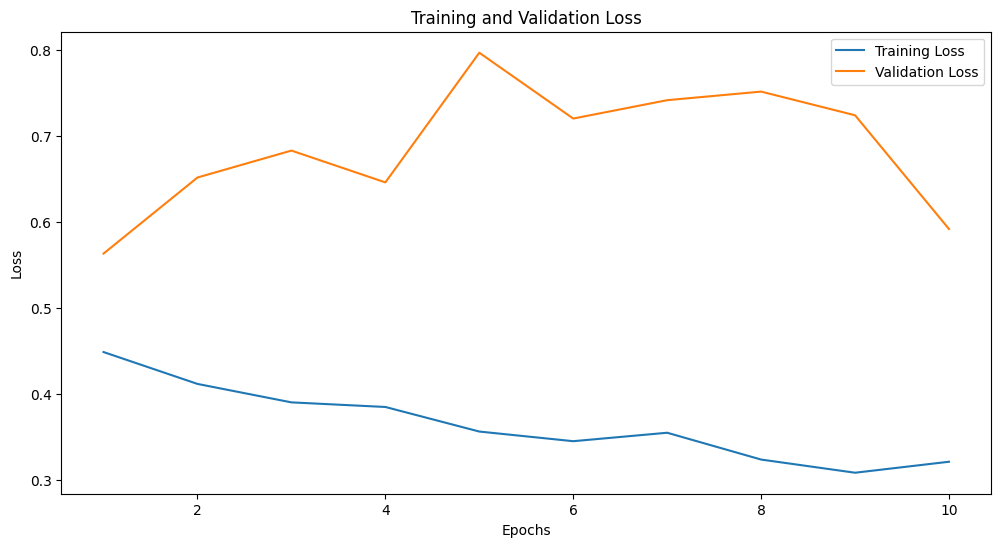

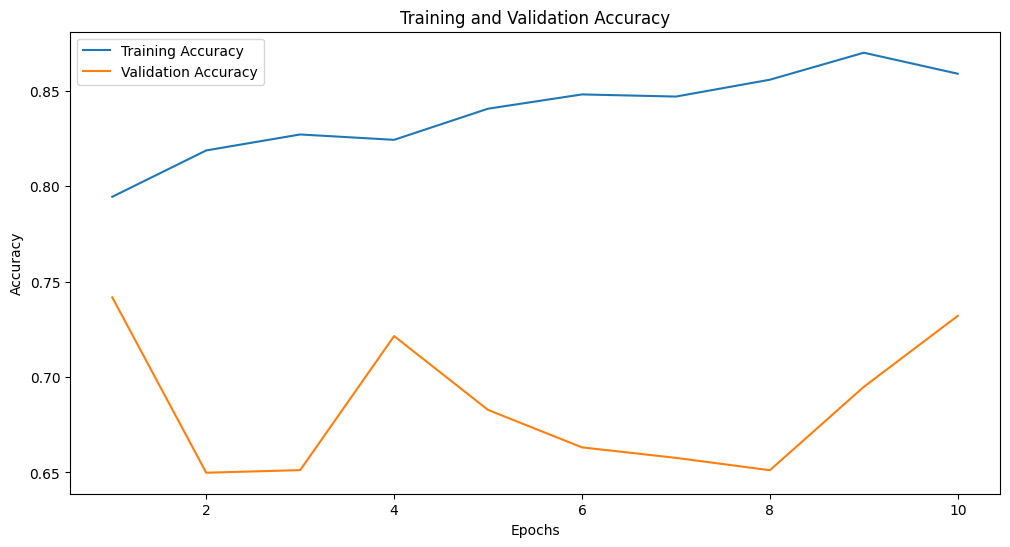

In [ ]:
import matplotlib.pyplot as plt

# Get the training and validation loss
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Get the training and validation accuracy
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 6.3.1 Test Model on other MSN's

In [ ]:
from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/IE/CORPORATE_PROJECT_AIRBUS/03_MODELS/01_1st_Improvement/lstm_best_model.h5'
model = load_model(model_path)

In [ ]:
test = pd.read_csv('/content/drive/My Drive/IE/CORPORATE_PROJECT_AIRBUS/01_DATA/PREPROS/02_msn_test_df.csv')
test.describe()

,FUEL_USED_2,FUEL_USED_3,FUEL_USED_4,VALUE_FOB,FLIGHT_PHASE_COUNT,FUEL_USED_1,Flight,FOB_change,FUEL_USED_1_gaussian_10,FUEL_USED_2_gaussian_10,FUEL_USED_3_gaussian_10,FUEL_USED_4_gaussian_10,VALUE_FOB_SG,Difference_VALUE_FOB_vs_FOB_SG,FUEL_USED_TOTAL,FUEL_USED_TOTAL_gaussian_10,FUEL_USED_TOTAL_change_gaussian,Time_diff_seconds,FUEL_USED_TOTAL_cumulative_gaussian,VALUE_FOB_SG_first,FOB_EST_SG,LEAKAGE,LEAKAGE_change,LEAKAGE_change_cumulative,REAL_LEAK
count,179231.000000,179231.000000,179231.000000,179231.000000,179231.0,179231.000000,179231.000000,179231.000000,179231.000000,179231.000000,179231.000000,179231.000000,179231.000000,179231.000000,179231.000000,179231.000000,179231.000000,1.792310e+05,179231.000000,179231.000000,179231.000000,179231.000000,179231.000000,179231.000000,179231.0
mean,3305.107275,3320.785964,3337.188740,21783.277262,8.0,3356.408619,478.380425,-16.348545,3354.721795,3303.751788,3319.407296,3335.786454,21814.870272,31.593010,13319.490598,13313.667333,13.249923,8.970288e+02,6713.448611,28207.485538,21494.036927,-320.833346,21.397963,10209.969619,0.0
std,1497.128845,1505.547125,1516.162065,6262.982899,0.0,1511.569652,413.848039,396.814009,1510.879747,1496.251061,1504.697736,1515.233080,6252.410789,694.783137,6027.814504,6024.351712,211.742780,2.207086e+05,5405.773338,6165.811475,7603.160558,5020.137259,225.817168,9415.399553,0.0
min,1500.011841,1500.161011,1500.000854,5903.000000,8.0,1500.040527,9.000000,-27539.000000,829.020701,819.990471,821.179998,833.640872,3979.204965,-13398.680831,6019.664673,3303.832042,-25701.388615,-2.254844e+07,-6988.101244,10415.387325,-5676.338891,-33267.954367,0.000000,0.000000,0.0
25%,2180.204468,2189.302246,2188.955566,16806.000000,8.0,2211.903442,347.000000,-3.000000,2211.826890,2177.431804,2185.551328,2187.188342,16861.612913,-3.420372,8769.729248,8761.196605,1.254732,1.000000e+00,2901.213891,23197.665293,16358.470903,-1986.041490,0.291090,4459.761388,0.0
50%,2914.104248,2929.355225,2941.629150,21547.000000,8.0,2960.530518,395.000000,-1.000000,2961.864350,2914.438269,2929.513749,2942.208702,21573.901923,-0.001178,11753.560059,11752.273632,1.356301,1.000000e+00,5269.044041,28360.548529,21809.760332,1380.959670,0.734373,6843.751086,0.0
75%,4071.707520,4084.409058,4127.934326,26097.000000,8.0,4145.365479,448.000000,0.000000,4148.510091,4073.471680,4086.689556,4128.145930,26105.156855,3.427994,16456.472046,16456.607010,2.188159,1.000000e+00,9317.759072,32242.077510,26944.265096,2743.495380,2.162744,13007.191470,0.0
max,8786.003906,8783.727539,9014.974609,39596.000000,8.0,9069.362305,2198.000000,4561.000000,9212.361767,8925.842574,8924.371864,9158.913234,41365.535459,15900.073093,35654.068359,36221.489439,9679.059505,2.886743e+07,30126.326250,41365.535459,41365.535459,21405.176390,32360.606188,81398.510328,0.0


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179231 entries, 0 to 179230
Data columns (total 30 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UTC_TIME                             179231 non-null  object 
 1   FUEL_USED_2                          179231 non-null  float64
 2   FUEL_USED_3                          179231 non-null  float64
 3   FUEL_USED_4                          179231 non-null  float64
 4   VALUE_FOB                            179231 non-null  float64
 5   FLIGHT_PHASE_COUNT                   179231 non-null  float64
 6   FUEL_USED_1                          179231 non-null  float64
 7   Flight                               179231 non-null  float64
 8   MSN                                  179231 non-null  object 
 9   UTC_TIME_obj                         179231 non-null  object 
 10  DATE                                 179231 non-null  object 
 11  TIME         

In [ ]:
test['UTC_TIME_obj'] = test['UTC_TIME'].copy()
test['UTC_TIME'] = pd.to_datetime(test['UTC_TIME'])
test['TIME_ELAPSED'] = (test['UTC_TIME'] - test.groupby('Flight')['UTC_TIME'].transform('first')).dt.total_seconds()

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, data, target, sequence_length, batch_size=64, predict_mode=False):
        self.data = data
        self.target = target
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.predict_mode = predict_mode
        if self.predict_mode:
            # In predict_mode, cover all data points
            self.indexes = np.arange(len(data))
        else:
            # Exclude the last part that doesn't fit into a sequence
            self.indexes = np.arange(len(data) - sequence_length)

    def __len__(self):
        if self.predict_mode:
            # Handle the last batch separately if it's smaller than batch_size
            return np.ceil(len(self.indexes) / self.batch_size).astype(np.int64)
        else:
            return (len(self.indexes) - self.sequence_length) // self.batch_size

    def __getitem__(self, index):
        if self.predict_mode and index == self.__len__() - 1:  # Last batch in predict_mode
            indexes = self.indexes[index * self.batch_size:]
            X = np.empty((len(indexes), self.sequence_length, len(feature_columns)))
            y = np.empty((len(indexes), 1))  # Adjusted for variable batch size
        else:
            indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
            X = np.empty((self.batch_size, self.sequence_length, len(feature_columns)))
            y = np.empty((self.batch_size, 1))

        for i, idx in enumerate(indexes):
            # Adjust sequence index calculation for predict_mode
            if self.predict_mode:
                sequence_idx = np.arange(max(0, idx - self.sequence_length + 1), idx + 1)
            else:
                sequence_idx = np.arange(idx, idx + self.sequence_length)

            # Pad sequences if necessary
            sequence_pad_length = self.sequence_length - len(sequence_idx)
            sequence_data = self.data.iloc[sequence_idx][feature_columns].values
            X[i, :, :] = np.pad(sequence_data, ((sequence_pad_length, 0), (0, 0)), 'constant', constant_values=0)
            if not self.predict_mode or idx < len(self.target):
                y[i] = self.target.iloc[min(idx, len(self.target) - 1)]
        return X, y


2801/2801 [==============================] - 220s 77ms/step


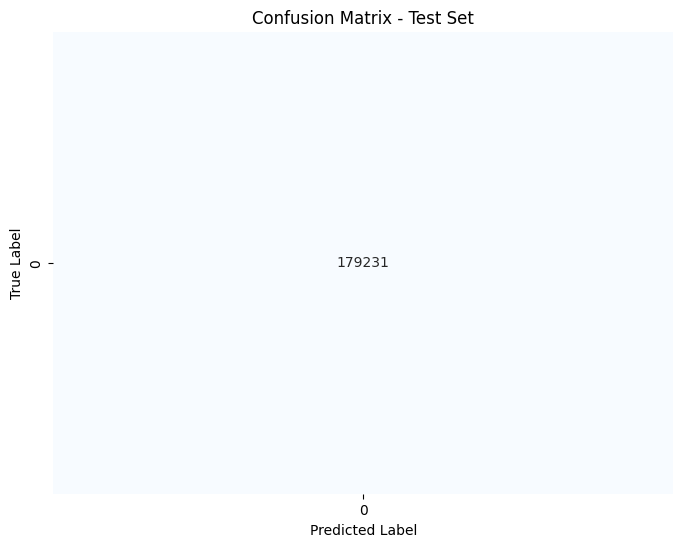

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# Assuming 'test' DataFrame is already loaded and prepared similarly to 'final_df'
# Correct the typo in variable name
target_column = "REAL_LEAK"
feature_columns = ['LEAKAGE_change_cumulative', 'TIME_ELAPSED', "VALUE_FOB_SG", "FUEL_USED_TOTAL_cumulative_gaussian"]


# Assuming 'scaler' was fit on the training data somewhere earlier in your code
test[feature_columns] = scaler.transform(test[feature_columns])

# Assuming DataGenerator class definition is correct and included above this code block
test_generator = DataGenerator(test[feature_columns], test[target_column], sequence_length, batch_size=64, predict_mode=True)


# Make predictions using the trained model on the test set
y_test_pred = model.predict(test_generator)
y_test_pred_classes = (y_test_pred > 0.5).astype(np.int64)

# Align true labels with predictions
y_test_true = test[target_column].values[-len(y_test_pred):]

# Compute confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test_true, y_test_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()


100 % accurancy



---


### 6.3.2 Adding Artificial Leakages to the Test data


---



In [ ]:
len(test['Flight'].unique())

218

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179231 entries, 0 to 179230
Data columns (total 31 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   UTC_TIME                             179231 non-null  datetime64[ns]
 1   FUEL_USED_2                          179231 non-null  float64       
 2   FUEL_USED_3                          179231 non-null  float64       
 3   FUEL_USED_4                          179231 non-null  float64       
 4   VALUE_FOB                            179231 non-null  float64       
 5   FLIGHT_PHASE_COUNT                   179231 non-null  float64       
 6   FUEL_USED_1                          179231 non-null  float64       
 7   Flight                               179231 non-null  float64       
 8   MSN                                  179231 non-null  object        
 9   UTC_TIME_obj                         179231 non-null  object        
 

In [ ]:
import pandas as pd
import numpy as np

# Define the last UTC_TIME and start_date for creating artificial flights
last_utc = pd.to_datetime(test['UTC_TIME'].max())
start_date = last_utc + pd.Timedelta(days=1)

# Initialize the list to store artificial flights
new_flights_with_leak = []

# Define a list of leakage rates
leakage_rates = [20]

# Iterate over leakage rates to create artificial flights
for leakage_rate in leakage_rates:
    start_sequence = 1
    random_flights = np.random.choice(test['Flight'].unique(), 12, replace=False)

    for flight_index, flight in enumerate(random_flights, start=1):
        flight_data = test[test['Flight'] == flight].copy()
        flight_data.reset_index(drop=True, inplace=True)

        new_flight_name = f"Artificial_V{start_sequence + flight_index:04d}_{leakage_rate}"
        flight_data['Flight'] = new_flight_name

        # Assign new UTC_TIME for the artificial flight
        flight_data['UTC_TIME'] = pd.date_range(start=start_date, periods=len(flight_data), freq='S')

        # Initialize 'REAL_LEAK' column to 0 (no leak)
        flight_data['REAL_LEAK'] = 0

        # Identify valid start points for leakage (FLIGHT_PHASE_COUNT == 8)
        valid_start_points = flight_data[flight_data['FLIGHT_PHASE_COUNT'] == 8].index

        if not valid_start_points.empty:
            leakage_start_point = np.random.choice(valid_start_points)
            flight_data.loc[leakage_start_point:, 'REAL_LEAK'] = 1  # Set REAL_LEAK to 1 from leakage start point

            # Apply the leakage rate to the FOB values after the leakage start point
            flight_data.loc[leakage_start_point:, 'VALUE_FOB_SG'] -= leakage_rate *(flight_data.loc[leakage_start_point:, 'UTC_TIME'].diff().dt.total_seconds().cumsum().fillna(0))

        # Update start_date for the next artificial flight
        start_date = flight_data['UTC_TIME'].iloc[-1] + pd.Timedelta(seconds=1)

        # Append modified flight_data to the list of new flights
        new_flights_with_leak.append(flight_data)

        # Increment start_sequence for unique naming in the next batch
        start_sequence += 10

# Combine all new flights into a single DataFrame
new_flights_with_leak_df = pd.concat(new_flights_with_leak)

In [ ]:
# Concatenate the selected columns from both DataFrames
test_new = pd.concat([test, new_flights_with_leak_df], ignore_index=True)


In [ ]:
test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196984 entries, 0 to 196983
Data columns (total 31 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   UTC_TIME                             196984 non-null  datetime64[ns]
 1   FUEL_USED_2                          196984 non-null  float64       
 2   FUEL_USED_3                          196984 non-null  float64       
 3   FUEL_USED_4                          196984 non-null  float64       
 4   VALUE_FOB                            196984 non-null  float64       
 5   FLIGHT_PHASE_COUNT                   196984 non-null  float64       
 6   FUEL_USED_1                          196984 non-null  float64       
 7   Flight                               196984 non-null  object        
 8   MSN                                  196984 non-null  object        
 9   UTC_TIME_obj                         196984 non-null  object        
 

#### 6.3.2.1 Ingesting 30 artificial leakages (1,0.8,0.5)

3338/3338 [==============================] - 219s 65ms/step


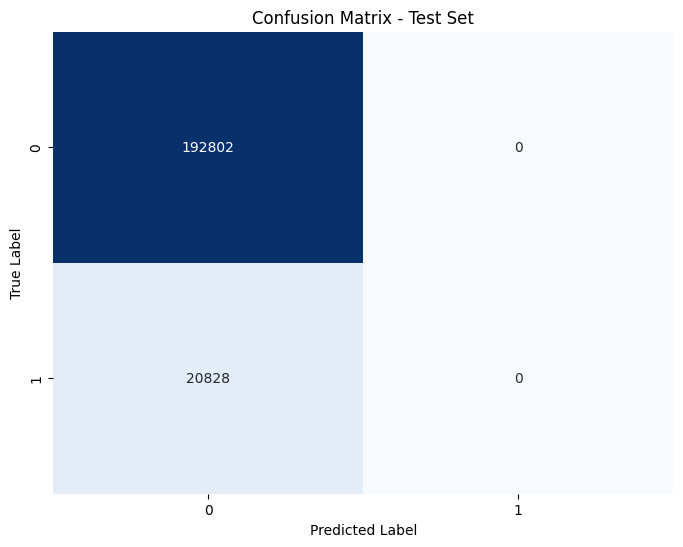

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model


target_column = "REAL_LEAK"
feature_columns = ['LEAKAGE_change_cumulative', 'TIME_ELAPSED', "VALUE_FOB_SG", "FUEL_USED_TOTAL_cumulative_gaussian"]


test_new[feature_columns] = scaler.transform(test_new[feature_columns])


test_generator = DataGenerator(test_new[feature_columns], test_new[target_column], sequence_length, batch_size=64, predict_mode=True)


y_test_pred = model.predict(test_generator)
y_test_pred_classes = (y_test_pred > 0.5).astype(np.int64)


y_test_true = test_new[target_column].values[-len(y_test_pred):]


conf_matrix_test = confusion_matrix(y_test_true, y_test_pred_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()


In [ ]:
# Calculate True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN)
TP = conf_matrix_test[1, 1]
TN = conf_matrix_test[0, 0]
FP = conf_matrix_test[0, 1]
FN = conf_matrix_test[1, 0]

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Calculate precision
precision = TP / (TP + FP)

# Calculate recall (sensitivity)
recall = TP / (TP + FN)

# Calculate specificity
specificity = TN / (TN + FP)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

<ipython-input-37-18c6e9688db6>:11: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)


In [ ]:
print(accuracy)
print(precision)
print(recall)
print(f1_score)

0.9025043299162103
nan
0.0
nan


#### 6.3.2.2 Ingesting 20 artificial leakages (1,0.8)

3078/3078 [==============================] - 201s 65ms/step


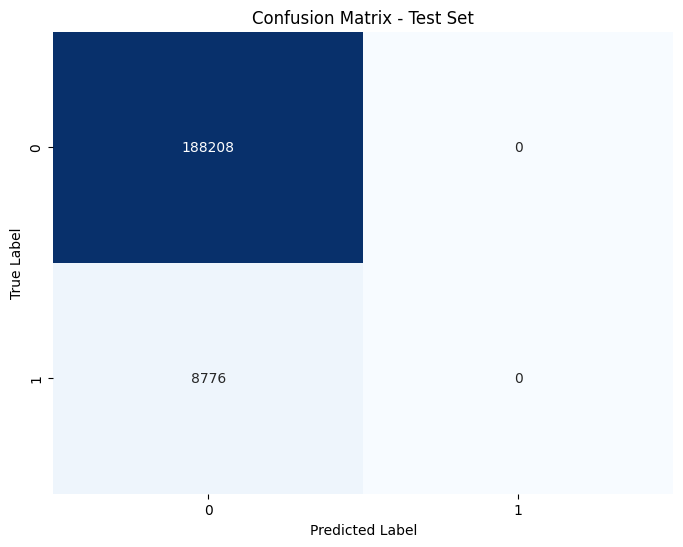

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model


target_column = "REAL_LEAK"
feature_columns = ['LEAKAGE_change_cumulative', 'TIME_ELAPSED', "VALUE_FOB_SG", "FUEL_USED_TOTAL_cumulative_gaussian"]


test_new[feature_columns] = scaler.transform(test_new[feature_columns])


test_generator = DataGenerator(test_new[feature_columns], test_new[target_column], sequence_length, batch_size=64, predict_mode=True)


y_test_pred = model.predict(test_generator)
y_test_pred_classes = (y_test_pred > 0.5).astype(np.int64)


y_test_true = test_new[target_column].values[-len(y_test_pred):]


conf_matrix_test = confusion_matrix(y_test_true, y_test_pred_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

#### 6.3.2.3 Ingesting 10 artificial leakages (20)

2878/2878 [==============================] - 189s 66ms/step


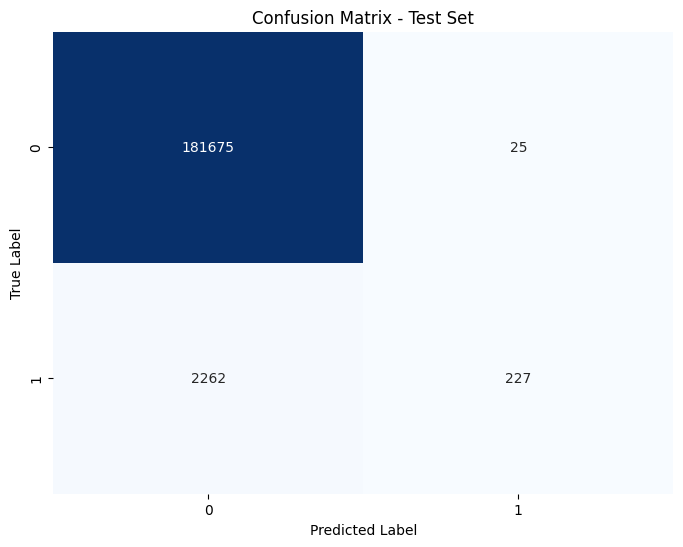

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model


target_column = "REAL_LEAK"
feature_columns = ['LEAKAGE_change_cumulative', 'TIME_ELAPSED', "VALUE_FOB_SG", "FUEL_USED_TOTAL_cumulative_gaussian"]


test_new[feature_columns] = scaler.transform(test_new[feature_columns])


test_generator = DataGenerator(test_new[feature_columns], test_new[target_column], sequence_length, batch_size=64, predict_mode=True)


y_test_pred = model.predict(test_generator)
y_test_pred_classes = (y_test_pred > 0.5).astype(np.int64)


y_test_true = test_new[target_column].values[-len(y_test_pred):]


conf_matrix_test = confusion_matrix(y_test_true, y_test_pred_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

In [ ]:
# Calculate True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN)
TP = conf_matrix_test[1, 1]
TN = conf_matrix_test[0, 0]
FP = conf_matrix_test[0, 1]
FN = conf_matrix_test[1, 0]

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Calculate precision
precision = TP / (TP + FP)

# Calculate recall (sensitivity)
recall = TP / (TP + FN)

# Calculate specificity
specificity = TN / (TN + FP)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

In [ ]:
print(accuracy)
print(precision)
print(recall)
print(f1_score)

0.9875834061751787
0.9007936507936508
0.09120128565689031
0.16563298066399124




---


### 6.3.2 Evaluation


---



Model Evaluation - "Best Model"

**Architecture Summary**

Our enhanced model, "Advanced_Analysis_Model", showcases a more sophisticated architecture with two LSTM layers, each followed by a dropout layer for regularization. The model is designed to handle longer input sequences of 150 time steps, providing a wider temporal context for detecting anomalies in the fuel consumption data. The architecture's complexity is balanced by the inclusion of dropout layers to prevent overfitting, allowing the model to learn robust features. The model has a total of 31,251 parameters, offering a deep yet efficient structure for training and inference.

**Training Summary**

Training was conducted over 10 epochs. The model began with a training accuracy of 79.44% and showed varying degrees of improvement and fluctuation, reaching an accuracy of 85.89%. This variability indicates a complex relationship between the model and the data, which may be addressed through further tuning.

**Validation Performance**

The validation performance presented challenges, with the highest accuracy recorded at 73.20% and the lowest at 64.99%. The fluctuations in validation accuracy and loss suggest the model's sensitivity to the validation set's complexity, emphasizing the need for more nuanced training strategies or additional data preprocessing.

**Loss and Accuracy Trends**

Training and validation accuracy trends show fluctuations over the epochs, which may indicate overfitting or the model's struggle to generalize to the validation set.

Training and validation loss trends demonstrate a decrease in training loss over time, but an increase in validation loss, suggesting a divergence between the training and validation set performance.

**Confusion Matrix**

The confusion matrix for the test set reveals a high number of true positives and true negatives, but also a significant number of false negatives, indicating areas where the model's sensitivity could be improved.

**Insights and Future Work**

The best model demonstrated potential in learning complex patterns but also revealed areas for improvement in handling validation data. Future work will explore further hyperparameter optimization, model complexity adjustments, and enhanced data preprocessing to improve performance. Additionally, techniques like cross-validation may provide a more robust evaluation of the model's generalization capability. The ultimate goal is to develop a model that not only performs well on training data but can also reliably predict anomalies in diverse operational conditions.





---


# 7.OTHER LSTMS


---



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Assuming 'final_df' is your loaded DataFrame

# Prepare the feature columns and target column
feature_columns = ["VALUE_FOB_SG", "FUEL_USED_1_smoothed_10", "FUEL_USED_2_smoothed_10",
                   "FUEL_USED_3_smoothed_10", "FUEL_USED_4_smoothed_10", "FUEL_USED_TOTAL_smoothed",
                   "FUEL_USED_TOTAL_cumulative_smoothed", "FOB_EST_SG", "LEAKAGE",
                   "LEAKAGE_change", "LEAKAGE_change_cumulative"]
target_column = "REAL_LEAK"

# Normalize the feature columns
scaler = StandardScaler()
final_df[feature_columns] = scaler.fit_transform(final_df[feature_columns])

# Split the dataset into training and validation sets based on flights
# This part remains the same as in your snippet

# Define the sequence length and batch size for the model
sequence_length = 150
batch_size = 64

# Custom sequence generator to create tf.data.Dataset
def sequence_generator(dataframe, sequence_length, batch_size):
    def generator():
        for flight in dataframe['Flight'].unique():
            flight_data = dataframe[dataframe['Flight'] == flight]
            indices = range(len(flight_data) - sequence_length)
            for i in indices:
                seq = flight_data.iloc[i:i+sequence_length][feature_columns].values
                target = flight_data.iloc[i+sequence_length][target_column]
                yield seq, target
    return generator

# Create tf.data.Dataset objects for training and validation
train_dataset = tf.data.Dataset.from_generator(
    sequence_generator(train_df, sequence_length, batch_size),
    output_types=(tf.float32, tf.int32),
    output_shapes=((sequence_length, len(feature_columns)), ())
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    sequence_generator(val_df, sequence_length, batch_size),
    output_types=(tf.float32, tf.int32),
    output_shapes=((sequence_length, len(feature_columns)), ())
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(50, input_shape=(sequence_length, len(feature_columns)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Model summary
model.summary()

# Train the model using the generated datasets
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    verbose=1
)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150, 50)           12400     
                                                                 
 dropout (Dropout)           (None, 150, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 32651 (127.54 KB)
Trainable params: 32651 (127.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
7948/79

### **Model Summary:**
- The model is of the "sequential" type, which signifies a linear stack of layers.
* The first layer is an LSTM layer with an output shape of (None, 150, 50). Here, None is a placeholder for the batch size, 150 represents the number of timesteps in each input sequence, and 50 denotes the number of units (neurons) in the LSTM layer.
* A Dropout layer follows, serving the purpose of preventing overfitting by randomly setting a fraction of input units to 0 during training, maintaining the data's shape.
* Another LSTM layer without return_sequences is employed, implying it only outputs the last step's output, leading to the shape (None, 50).
* Another Dropout layer ensues, with the same purpose as the first.
A Dense layer with a single unit and a sigmoid activation function serves as the output layer, suitable for binary classification.

### Training Parameters:

####Total params:
* The total number of parameters in the model is **32,651**, encompassing both weights and biases of all layers.
Trainable params:
* All **32,651 parameters are trainable**, implying they will be updated during the training process.
Non-trainable params:
* There are no non-trainable parameters in this model.

### Training Progress:
* The model has commenced training for the first epoch (Epoch 1/10).
7948/7948 indicates the number of batches processed.
* The loss value is 0.1834, denoting the model's performance as evaluated by the binary cross-entropy loss function.
* The accuracy is 0.9301, reflecting the model's performance on the training data.


Model Summary:
The model is of the "sequential" type, meaning it's a linear stack of layers.
* The first layer is an LSTM layer with an output shape of (None, 150, 50). The None is a placeholder for the batch size, 150 is the number of timesteps in each input sequence, and 50 is the number of units (neurons) in the LSTM layer.
* A Dropout layer follows, which helps prevent overfitting by randomly setting a fraction of input units to 0 during training. It maintains the shape of the data passing through it.
* Another LSTM layer without return_sequences is used, meaning it will only output the last step's output, which results in the shape (None, 50).
* Another Dropout layer follows with the same purpose as the first.
A Dense layer with a single unit and a sigmoid activation function is used as the output layer, suitable for binary classification.
Training Parameters:

Total params:
* The total number of parameters in the model is **32,651**, which includes both weights and biases of all layers.

Trainable params:
* All **32,651 parameters are trainable**, meaning they will be updated during the training process.
Non-trainable params:
* There are no non-trainable parameters in this model.

Training Progress:
* The model has started training for the first epoch (Epoch 1/10).
589/Unknown indicates the number of batches processed.
* The 'Unknown' part suggests that the total number of batches is not precomputed because the dataset might be being generated on-the-fly.
* It's showing the time per step (98ms/step), which is the average time the model takes to process each batch.
* The loss value is 0.0119, which is the model's performance as measured by the binary cross-entropy loss function.
* The accuracy is 0.9971, which is extremely high and might indicate that the model is performing exceptionally well on the training data.

In [ ]:
import pickle
history_dict = history.history
# Save history to Pickle
with open('/content/drive/MyDrive/IE/CORPORATE_PROJECT_AIRBUS/03_MODELS/lstm_model_1_history.pkl', 'wb') as file:
    pickle.dump(history_dict, file)

In [ ]:
model.save('/content/drive/MyDrive/IE/CORPORATE_PROJECT_AIRBUS/03_MODELS/lstm_1_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import pickle
with open('/content/drive/MyDrive/IE/CORPORATE_PROJECT_AIRBUS/03_MODELS/lstm_model_1_history.pkl', 'rb') as file:
    history_dict = pickle.load(file)

history_dict


{'loss': [0.18340642750263214,
  0.20866335928440094,
  0.20763374865055084,
  0.19193600118160248,
  0.18331027030944824,
  0.19677510857582092,
  0.18569688498973846,
  0.2118581384420395,
  0.2154398262500763,
  0.21665719151496887],
 'accuracy': [0.9300593733787537,
  0.9214733242988586,
  0.9140040278434753,
  0.928024411201477,
  0.9336848855018616,
  0.9250457882881165,
  0.9357945322990417,
  0.9229479432106018,
  0.9147905111312866,
  0.9187875986099243],
 'val_loss': [0.9722122550010681,
  1.0454472303390503,
  0.6493478417396545,
  0.6513835191726685,
  0.775560200214386,
  0.4226242005825043,
  0.9481151700019836,
  0.48379889130592346,
  0.7991980314254761,
  0.5636894702911377],
 'val_accuracy': [0.49703601002693176,
  0.6885213851928711,
  0.8057206869125366,
  0.8055344223976135,
  0.7982215881347656,
  0.8869227766990662,
  0.7746716141700745,
  0.8131144642829895,
  0.7829967141151428,
  0.8303882479667664]}

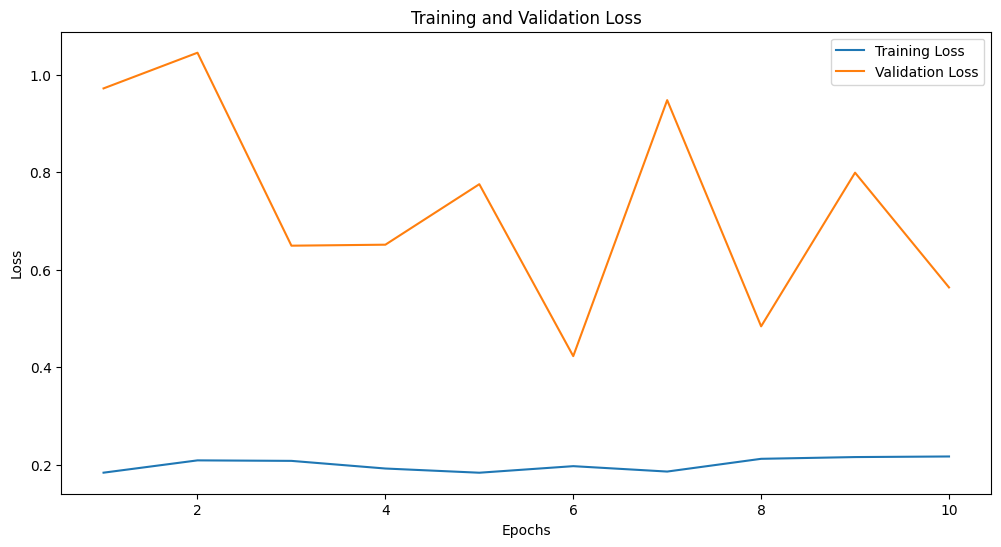

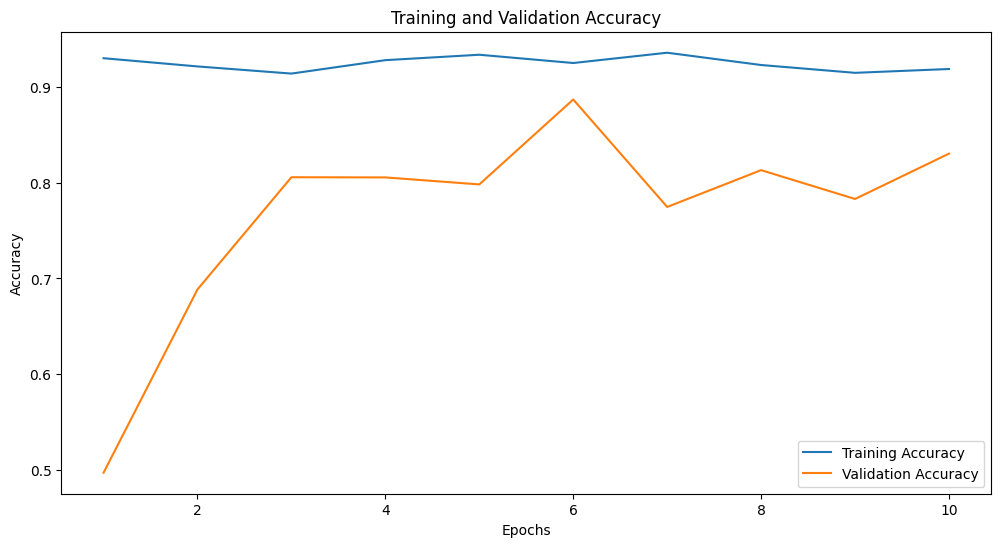

In [ ]:
import matplotlib.pyplot as plt

# Get the training and validation loss
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Get the training and validation accuracy
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, auc

# Assuming 'y_true' are the true labels and 'y_pred_proba' are the predicted probabilities from the model
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Calculate the area under the precision-recall curve
auc_pr = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'y_true' is not defined

Hyperparameter Choices
- LSTM units: Set to 50 as a balance between model complexity and computational demand.
- Epochs: Initially 10, to be adjusted based on convergence and overfitting.
- Batch size: 64, a common starting point that can be adjusted based on GPU memory.
- Validation split: 10%, to monitor overfitting during training.

## 2st LSTM

here i will try a different split ratio. Also we will try a way smaller window and less input featurs

In [ ]:
final_df =pd.read_csv('/content/drive/My Drive/IE/CORPORATE_PROJECT_AIRBUS/01_DATA/msn02_Savgol_600000_for_first_modeling.csv')

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668788 entries, 0 to 668787
Data columns (total 16 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UTC_TIME                             668788 non-null  object 
 1   MSN                                  668788 non-null  object 
 2   Flight                               668788 non-null  object 
 3   FLIGHT_PHASE_COUNT                   668788 non-null  float64
 4   VALUE_FOB_SG                         668788 non-null  float64
 5   FUEL_USED_1_smoothed_10              668788 non-null  float64
 6   FUEL_USED_2_smoothed_10              668788 non-null  float64
 7   FUEL_USED_3_smoothed_10              668788 non-null  float64
 8   FUEL_USED_4_smoothed_10              668788 non-null  float64
 9   FUEL_USED_TOTAL_smoothed             668788 non-null  float64
 10  FUEL_USED_TOTAL_cumulative_smoothed  668788 non-null  float64
 11  FOB_EST_SG   

In [ ]:
final_df['UTC_TIME'] = pd.to_datetime(final_df['UTC_TIME'])

In [ ]:
from sklearn.model_selection import train_test_split

final_df['Has_Leak'] = final_df.groupby('Flight')['REAL_LEAK'].transform('max')

# Sort flights with leakages by their minimum UTC time
flights_with_leak_sorted = final_df[final_df['Has_Leak'] == 1].groupby('Flight')['UTC_TIME'].min().sort_values().index

# Sort flights without leakages by their minimum UTC time
flights_without_leak_sorted = final_df[final_df['Has_Leak'] == 0].groupby('Flight')['UTC_TIME'].min().sort_values().index

# Split flights into training and validation sets, ensuring the earlier flights are in the training set
train_flights_with_leak, val_flights_with_leak = train_test_split(flights_with_leak_sorted, test_size=0.3, shuffle=False)
train_flights_without_leak, val_flights_without_leak = train_test_split(flights_without_leak_sorted, test_size=0.3, shuffle=False)

# Combine the training flights and validation flights back
train_flights = np.concatenate([train_flights_with_leak, train_flights_without_leak])
val_flights = np.concatenate([val_flights_with_leak, val_flights_without_leak])

# Create training and validation DataFrames
train_df = final_df[final_df['Flight'].isin(train_flights)]
val_df = final_df[final_df['Flight'].isin(val_flights)]

# Verify the split
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# Check the proportion of leak to non-leak flights in each set
print("Training set leaks:", train_df['REAL_LEAK'].sum() / len(train_df))
print("Validation set leaks:", val_df['REAL_LEAK'].sum() / len(val_df))

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<ipython-input-38-b107c8aed24a>, line 13)

In [ ]:
print(train_df["UTC_TIME"].min())
print(train_df["UTC_TIME"].max())

2010-10-26 13:32:07
2017-01-27 12:01:55


In [ ]:
print(val_df["UTC_TIME"].min())
print(val_df["UTC_TIME"].max())

2016-10-07 12:11:49
2017-01-28 07:08:33


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Assuming 'final_df' is your loaded DataFrame

# Prepare the feature columns and target column
feature_columns = ["VALUE_FOB_SG", "FUEL_USED_TOTAL_smoothed",
                   "FUEL_USED_TOTAL_cumulative_smoothed", "FOB_EST_SG", "LEAKAGE",
                   "LEAKAGE_change", "LEAKAGE_change_cumulative"]
target_column = "REAL_LEAK"

# Normalize the feature columns
scaler = StandardScaler()
train_df[feature_columns] = scaler.fit_transform(train_df[feature_columns])
val_df[feature_columns] = scaler.fit_transform(val_df[feature_columns])


# Define the sequence length and batch size for the model
sequence_length = 150
batch_size = 64

# Custom sequence generator to create tf.data.Dataset
def sequence_generator(dataframe, sequence_length, batch_size):
    def generator():
        for flight in dataframe['Flight'].unique():
            flight_data = dataframe[dataframe['Flight'] == flight]
            indices = range(len(flight_data) - sequence_length)
            for i in indices:
                seq = flight_data.iloc[i:i+sequence_length][feature_columns].values
                target = flight_data.iloc[i+sequence_length][target_column]
                yield seq, target
    return generator

# Create tf.data.Dataset objects for training and validation
train_dataset = tf.data.Dataset.from_generator(
    sequence_generator(train_df, sequence_length, batch_size),
    output_types=(tf.float32, tf.int32),
    output_shapes=((sequence_length, len(feature_columns)), ())
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    sequence_generator(val_df, sequence_length, batch_size),
    output_types=(tf.float32, tf.int32),
    output_shapes=((sequence_length, len(feature_columns)), ())
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(50, input_shape=(sequence_length, len(feature_columns)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Model summary
model.summary()

# Train the model using the generated datasets
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    verbose=1
)

<ipython-input-41-80bb9fcf6ec8>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[feature_columns] = scaler.fit_transform(train_df[feature_columns])
<ipython-input-41-80bb9fcf6ec8>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[feature_columns] = scaler.fit_transform(val_df[feature_columns])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 150, 50)           11600     
                                                                 
 dropout_2 (Dropout)         (None, 150, 50)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31851 (124.42 KB)
Trainable params: 31851 (124.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
7680/

In [ ]:
import pickle
history_dict = history.history
# Save history to Pickle
with open('/content/drive/MyDrive/IE/CORPORATE_PROJECT_AIRBUS/03_MODELS/lstm_model_2_history.pkl', 'wb') as file:
    pickle.dump(history_dict, file)

In [ ]:
model.save('/content/drive/MyDrive/IE/CORPORATE_PROJECT_AIRBUS/03_MODELS/lstm_2_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1. Data Splitting: Instead of splitting the data purely based on time, you could consider stratified splitting. This ensures that both your training and validation sets have a similar distribution of flights with and without leakages. You can use the stratify parameter in sklearn's train_test_split function for this purpose.

2. Data Augmentation: Since you're dealing with time-series data, you could augment your dataset by introducing variations or perturbations to the existing flights. This can help the model generalize better by exposing it to a wider range of scenarios.

3. Regularization: Experiment with different forms of regularization, such as dropout or L2 regularization, to prevent overfitting. You've already applied dropout, but you may need to adjust the dropout rate or explore other regularization techniques.

4. Model Complexity: Your LSTM model architecture seems reasonable, but you could try simplifying it by reducing the number of LSTM layers or the number of units in each layer. Sometimes simpler models generalize better, especially with limited data.

5. Evaluation Metrics: Instead of solely relying on accuracy, consider using other evaluation metrics such as precision, recall, or F1-score, especially for imbalanced datasets like yours where the number of instances with leakages may be much smaller than those without.

6. Cross-Validation: Perform k-fold cross-validation to get a better estimate of your model's performance. This can help assess how well your model generalizes to unseen data.

## 3rd LSTM

- Reducing Sequence Length to 90 s - 1.5 min
- Splitting without shuffle and stratified based on `final_df["Has_Leak"]`

In [ ]:
final_df =pd.read_csv('/content/drive/My Drive/IE/CORPORATE_PROJECT_AIRBUS/01_DATA/msn02_Savgol_600000_for_first_modeling.csv')

final_df['UTC_TIME'] = pd.to_datetime(final_df['UTC_TIME'])

# Add a helper column to identify flights with any leakage
final_df['Has_Leak'] = final_df.groupby('Flight')['REAL_LEAK'].transform('max')

# Separate flights with and without leaks
flights_with_leak = final_df[final_df['Has_Leak'] == 1]['Flight'].unique()
flights_without_leak = final_df[final_df['Has_Leak'] == 0]['Flight'].unique()

# Sort flights with leak based on first occurrence UTC_TIME
flights_with_leak_sorted = sorted(
    flights_with_leak,
    key=lambda flight: final_df[final_df['Flight'] == flight]['UTC_TIME'].min()
)

# Sort flights without leak based on first occurrence UTC_TIME
flights_without_leak_sorted = sorted(
    flights_without_leak,
    key=lambda flight: final_df[final_df['Flight'] == flight]['UTC_TIME'].min()
)


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Stratified splitting based on the presence of leakages
train_flights_with_leak, val_flights_with_leak = train_test_split(flights_with_leak_sorted, test_size=0.3, shuffle=False)
train_flights_without_leak, val_flights_without_leak = train_test_split(flights_without_leak_sorted, test_size=0.3, shuffle=False)

train_flights = np.concatenate([train_flights_with_leak, train_flights_without_leak])
val_flights = np.concatenate([val_flights_with_leak, val_flights_without_leak])

# Create training and validation DataFrames
train_df = final_df[final_df['Flight'].isin(train_flights)]
val_df = final_df[final_df['Flight'].isin(val_flights)]

# Prepare the feature columns and target column
feature_columns = ["VALUE_FOB_SG", "FUEL_USED_TOTAL_smoothed",
                   "FUEL_USED_TOTAL_cumulative_smoothed", "FOB_EST_SG", "LEAKAGE",
                   "LEAKAGE_change", "LEAKAGE_change_cumulative"]
target_column = "REAL_LEAK"

# Normalize the feature columns
scaler = StandardScaler()
train_df[feature_columns] = scaler.fit_transform(train_df[feature_columns])
val_df[feature_columns] = scaler.fit_transform(val_df[feature_columns])


# Define the sequence length and batch size for the model
sequence_length = 90
batch_size = 64

# Custom sequence generator to create tf.data.Dataset
def sequence_generator(dataframe, sequence_length, batch_size):
    def generator():
        for flight in dataframe['Flight'].unique():
            flight_data = dataframe[dataframe['Flight'] == flight]
            indices = range(len(flight_data) - sequence_length)
            for i in indices:
                seq = flight_data.iloc[i:i+sequence_length][feature_columns].values
                target = flight_data.iloc[i+sequence_length][target_column]
                yield seq, target
    return generator

# Create tf.data.Dataset objects for training and validation
train_dataset = tf.data.Dataset.from_generator(
    sequence_generator(train_df, sequence_length, batch_size),
    output_types=(tf.float32, tf.int32),
    output_shapes=((sequence_length, len(feature_columns)), ())
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    sequence_generator(val_df, sequence_length, batch_size),
    output_types=(tf.float32, tf.int32),
    output_shapes=((sequence_length, len(feature_columns)), ())
).batch(batch_size).prefetch(tf.data.AUTOTUNE)


# Define the LSTM model architecture with L2 regularization
model = Sequential()
model.add(LSTM(50, kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(sequence_length, len(feature_columns))))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])


# Model summary
model.summary()

# Train the model using the generated datasets
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    verbose=1
)


<ipython-input-53-aac006530f2a>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[feature_columns] = scaler.fit_transform(train_df[feature_columns])
<ipython-input-53-aac006530f2a>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[feature_columns] = scaler.fit_transform(val_df[feature_columns])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                11600     
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11651 (45.51 KB)
Trainable params: 11651 (45.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
6806/6806 [==============================] - 757s 111ms/step - loss: 0.1890 - accuracy: 0.9341 - precision_2: 0.8687 - recall_2: 0.8178 - auc_2: 0.9746 - val_loss: 1.0792 - val_accuracy: 0.6511 - val_precision_2: 0.4353 - val_recall_2: 0.8198 - val_auc_2: 0.7946
Epoch 2/

In [ ]:
import pickle
history_dict = history.history
# Save history to Pickle
with open('/content/drive/MyDrive/IE/CORPORATE_PROJECT_AIRBUS/03_MODELS/lstm_model_3_history.pkl', 'wb') as file:
    pickle.dump(history_dict, file)

In [ ]:
model.save('/content/drive/MyDrive/IE/CORPORATE_PROJECT_AIRBUS/03_MODELS/lstm_3_model.h5')

$$
\text{FOB_BASE}(t) = \text{TOTAL_FUEL_USED}(t) + \text{VALUE_FOB}(t)
$$

$$
\text{FOB_BASE}(t) = \text{VALUE_FOB}(t=0)\quad(\text{before engine start})
$$



In [ ]:
\text{FOB_BASE} = \text{FOB_USED}(t) + \text{FUEL_BOARD}(t) = \text{VALUE_FOB}